In [1]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud
from IPython.display import HTML
import warnings
import pymorphy2

warnings.filterwarnings("ignore")


## Обработка датафрейма и EDA

In [2]:
df = pd.read_csv('sample_talks_clear_target_2.csv')\
        .rename(columns = {'transcription_ch_0':'talks'})\
        .drop('Unnamed: 0', axis = 1)

In [3]:
df.head()

talks  target  \
0  здравствуйте пожалуйста аллею здравствуйте мен...       0   
1  здравствуйте пожалуйста аллею здравствуйте мен...       0   
2  здравствуйте пожалуйста аллею здравствуйте мен...       0   
3  компания в каком подскажите пожалуйста квартир...       0   
4  компания в каком подскажите пожалуйста квартир...       0   

                             client  
0  007d183bd4f33cbf07a5cf1fa10e43fc  
1  007d183bd4f33cbf07a5cf1fa10e43fc  
2  007d183bd4f33cbf07a5cf1fa10e43fc  
3  a092a4d4c062a6450415d18fcd499d71  
4  a092a4d4c062a6450415d18fcd499d71

In [4]:
df['hash'] = df.talks.apply(hash)
df = df.drop_duplicates('hash')

df.loc[df.client == '6adf97f83acf6453d4a6a4b1070f3754', 'client'] = None
df.loc[(df.target == 1) & (df.client.isna()), 'target'] = 0
df['target_client'] = df.client.notna().astype('int')

In [5]:
print(f'Всего диалогов: {df.shape[0]}, {df.shape[0]/df.shape[0]*100}%')
print(f'Целевых клиентов: {df.client.notna().sum()}, {round(df.client.notna().sum()/df.shape[0]*100,2)}%')
print(f'Клиентов с покупкой: {df.target.sum()}, {round(df.target.sum()/df.shape[0]*100,2)}%')

Всего диалогов: 999, 100.0%
Целевых клиентов: 244, 24.42%
Клиентов с покупкой: 11, 1.1%


In [6]:
morph = pymorphy2.MorphAnalyzer()
list_numbers = []
def extract_numbers(text):
    words = text.split()
    result = []
    for word in words:
        try:
            parsed_word = morph.parse(word)[0]
            if 'NUMR' in parsed_word.tag or word in ('скидка','скидки','скидок','скидку','скидкой',
                                                     'скидкам','процента','процентов',
                                                     'метр','миллион','миллионов','тысяч'):
                if 'NUMR' in parsed_word.tag:
                    list_numbers.append(word)
                result.append(parsed_word.normal_form)
        except ValueError:
            continue
    return " ".join(result)

tqdm.pandas()
df['extract_numbers'] = df['talks'].fillna("").progress_apply(extract_numbers)

100%|██████████| 999/999 [01:06<00:00, 14.98it/s]


In [7]:
df.extract_numbers[0]

'двадцать пять два девять два девять двадцать двадцать'

In [ ]:
nltk.download('stopwords')

In [11]:

# nltk.download('punkt')
# nltk.download('stopwords')

stop_words = set(stopwords.words('russian')+["здравствуйте", "пожалуйста", "компания", "меня", "группа", "группу", 
                                               "зовут", "самолет", "добрый", "день", "подскажите", "это", "алло",
                                              "который"])
stop_lemm = {"квартир", "вариант", "комплекс", "рассматрива", "проект", "так", "либ", "им", "такж",
            "поэт", "скаж", "наш", "как", "а", "котор", "ээ", "смотр", "прост", "уг", "вообщ", "поня",
            "получа", "например", "нужн", "сам", "вам", "имен", "ваш", "может"}

stemmer = RussianStemmer()

set_numbers = set(list_numbers)

def process_text(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and
                       word.lower() not in set_numbers]
    lemmatized_tokens = [stemmer.stem(token) for token in filtered_tokens if token.isalpha()]
    filtered_lemm = [word for word in lemmatized_tokens if word.lower() not in stop_lemm]
    processed_text = " ".join(filtered_lemm)
    return processed_text

tqdm.pandas()
df['processed_talks'] = df['talks'].fillna("").progress_apply(process_text)

100%|██████████| 999/999 [00:09<00:00, 100.14it/s]


In [12]:
df.head()

talks  target  \
0  здравствуйте пожалуйста аллею здравствуйте мен...       0   
3  компания в каком подскажите пожалуйста квартир...       0   
5  меня зовут едина добрый день даль информировал...       0   
6  добрый день группу самолет меня зовут аркадий ...       0   
7  понял самолет не обращаться а деньги компания ...       0   

                             client                 hash  target_client  \
0  007d183bd4f33cbf07a5cf1fa10e43fc -3894821709851341812              1   
3  a092a4d4c062a6450415d18fcd499d71  2191782931047083450              1   
5                              None  6097196463988193110              0   
6                              None  4698029142364684244              0   
7  c871f7d515b538284f95456debd60b38 -4781059726547084260              1   

                                     extract_numbers  \
0  двадцать пять два девять два девять двадцать д...   
3                                                два   
5                                                      
6  четыре двести десять процент три девять девять...   
7  четыре двести сорок тридцать четырнадцать милл...   

                                     processed_talks  
0  алл алибин групп виктор перевел сориентирова п...  
3                        стандартн первоначальн нетр  
5  един дал информирова жил кварта западн интерне...  
6  аркад назва сво мог интересн обраща буд краток...  
7  обраща деньг ирин жен правильн переда понима с...

In [13]:
all_lemmas = [lemma for lemmas in df['processed_talks'].str.split() for lemma in lemmas]

lemma_counts = Counter(all_lemmas)

print(lemma_counts.most_common(10))

[('метр', 1779), ('год', 1756), ('мог', 1384), ('ипотек', 1210), ('продаж', 1178), ('миллион', 1057), ('процент', 1052), ('офис', 1026), ('отделк', 966), ('срок', 952)]


Анализируя топ-10 лемм, можно заметить, что эти темы чаще всего обсуждаются в контексте жилой недвижимости из-за их прямого отношения к различным аспектам процесса покупки, продажи и управления недвижимостью. Слово "метр" упоминается в с общей площадью объектов недвижимости и цене, что является ключевым критерием для потенциальных покупателей. Термин "год" относится к временным рамкам сделки, упоминание слова "ипотека" указывает на значимость финансовой составляющей сделок с недвижимостью. Упоминание "процента" может указывать на финансовые аспекты сделки, включая процентные ставки по кредитам или скидки на недвижимость. 

In [14]:
#разделим по наличию скидки и конкурентному упоминанию
df['has_discount'] = df['processed_talks'].apply(lambda x: False if 'скидк' not in x else True)
df['has_competitiors'] = df['processed_talks'].apply(lambda x: False if 'пик ' not in x else True)

In [15]:
has_discount_counts = df['has_discount'].value_counts()
has_discount_yes = has_discount_counts[1]
has_discount_no = has_discount_counts[0]
total_dialogs = len(df['has_discount'])

print(f"Диалогов с упоминанием скидок: {has_discount_yes} ({round(has_discount_yes / total_dialogs * 100, 1)}%)")
print(f"Диалогов без упоминания скидок: {has_discount_no} ({round(has_discount_no / total_dialogs * 100, 1)}%)")


Диалогов с упоминанием скидок: 329 (32.9%)
Диалогов без упоминания скидок: 670 (67.1%)


In [16]:
print("Упоминали 'пик' в диалогах:", len(df[df['has_competitiors'] == True]))

Упоминали 'пик' в диалогах: 3


In [17]:
def extract_context(text, lemma):
    """
    Извлекает контексты для каждого вхождения леммы в тексте, с учетом слов и выделением леммы жирным шрифтом.

    Параметры:
        text (str): Текст, в котором нужно найти контексты.
        lemma (str): Лемма, по которой производится поиск контекстов.

    Возвращает:
        str: Строка с контекстами для каждого вхождения леммы в тексте, разделенными троеточиями.
    """
    list_tokens = text.split()
    context_list = []

    for i, token in enumerate(list_tokens):
        if lemma in token:
            start_index = max(0, i - 20)
            end_index = min(len(list_tokens), i + 21)  

            context = list_tokens[start_index:i] + [f"<b>{lemma}</b>"] + list_tokens[i+1:end_index]
            context_list.append(" ".join(context))

    result_summary = " ... ".join(context_list) 

    return result_summary


In [18]:
text = df[df.has_competitiors == True]['talks'].iloc[1]
HTML(extract_context(text, 'пик'))

In [19]:
#Конкуренты в диалоге
df[df['has_discount'] == True].head()

talks  target  \
12  алло его снова добрый день группы самолет я на...       0   
15  здравствуйте группа самали вот меня зовут очен...       0   
17  здравствуйте меня золота ли он груп самолет ни...       0   
22  добрый день группы самолет меня зовут каролина...       0   
23  да компания самолет меня заучили или стоит одн...       0   

                              client                 hash  target_client  \
12  8693d50323eef059522dfe4c3b533ef9 -8980267331348404302              1   
15                              None  4004071889076977521              0   
17                              None  5257538495884621809              0   
22                              None  5210479464745023025              0   
23  071852799080bfddcafdf732a9a7b6a8 -7192077635948326175              1   

                                      extract_numbers  \
12  восемьдесят шесть девяносто девять пять восемь...   
15  тридцать два два тридцать два двадцать двадцат...   
17  шесть миллион двадцать четыре шесть миллион тр...   
22  двадцать двадцать три три десять двадцать пять...   
23  тридцать пять девять тридцать два четыре тридц...   

                                      processed_talks  has_discount  \
12  снов групп запрос смог перевел перевел общенфо...          True   
15  сама очен приятн идут фистов отделк кухон гарн...          True   
17  золот груп никола альбин никола коллег подсказ...          True   
22  групп каролин мог обраща светла очен приятн сл...          True   
23  зауч сто одн комнат дал балкон ласточк студ от...          True   

    has_competitiors  
12             False  
15             False  
17             False  
22             False  
23             False

Скидка поминается в 32% диалогов с вопросами от клиентов и предложениями от менеджеров. В 3 диалогах упоминается конкуренты

In [20]:
df = df.reset_index()
all_lemmas = [lemma for lemmas in df['processed_talks'].str.split() for lemma in lemmas]

lemmas_with_discount = [lemma for idx, lemmas in enumerate(df['processed_talks'].str.split()) if df['has_discount'][idx] for lemma in lemmas]
lemmas_without_discount = [lemma for idx, lemmas in enumerate(df['processed_talks'].str.split()) if not df['has_discount'][idx] for lemma in lemmas]

lemma_counts_with_discount = Counter(lemmas_with_discount)
lemma_counts_without_discount = Counter(lemmas_without_discount)

print("Топ 10 лемм с скидкой:", lemma_counts_with_discount.most_common(10))
print("Топ 10 лемм без скидки:", lemma_counts_without_discount.most_common(10))


Топ 10 лемм с скидкой: [('метр', 1129), ('год', 1101), ('скидк', 755), ('процент', 723), ('ипотек', 698), ('отделк', 651), ('миллион', 649), ('мог', 646), ('продаж', 611), ('офис', 595)]
Топ 10 лемм без скидки: [('мог', 738), ('год', 655), ('метр', 650), ('продаж', 567), ('ипотек', 512), ('офис', 431), ('срок', 425), ('миллион', 408), ('жил', 405), ('номер', 393)]


Сравнивая топ-10 лемм с упоминанием скидки и без нее, можно выделить несколько интересных наблюдений. В обоих случаях слова "метр" и "год" остаются одними из самых часто употребляемых, что свидетельствует о значимости этих аспектов при обсуждении недвижимости. "процент"частотная лемма для наличия скидки, так как обычно обсуждается процент скидки. 


In [21]:
lemma_counts_with_discount.most_common(10)

[('метр', 1129),
 ('год', 1101),
 ('скидк', 755),
 ('процент', 723),
 ('ипотек', 698),
 ('отделк', 651),
 ('миллион', 649),
 ('мог', 646),
 ('продаж', 611),
 ('офис', 595)]

In [22]:
top_lemmas_with_discount = pd.DataFrame.from_dict(lemma_counts_with_discount, orient='index',
                       columns=['Frequency_With_Discount']).reset_index().rename(columns = {"index":"Lemma"})

top_lemmas_without_discount = pd.DataFrame.from_dict(lemma_counts_without_discount, orient='index',
                       columns=['Frequency_Without_Discount']).reset_index().rename(columns = {"index":"Lemma"})

top_lemmas_df = pd.merge(top_lemmas_with_discount, top_lemmas_without_discount, on='Lemma', how='outer')
top_lemmas_df = top_lemmas_df.fillna(0)


In [23]:
top_lemmas_df['Frequency_Difference'] = top_lemmas_df['Frequency_With_Discount']/\
top_lemmas_df['Frequency_With_Discount'].sum() \
                - top_lemmas_df['Frequency_Without_Discount']/top_lemmas_df['Frequency_Without_Discount'].sum()

top_lemmas_df = top_lemmas_df.sort_values(by='Frequency_Difference', ascending=False)

top_lemmas_df.head(30)

Lemma  Frequency_With_Discount  Frequency_Without_Discount  \
10858         скидк                    755.0                         0.0   
9655        процент                    723.0                       329.0   
5314           метр                   1129.0                       650.0   
6983         отделк                    651.0                       315.0   
1878            год                   1101.0                       655.0   
12994           цен                    482.0                       208.0   
11547      стоимост                    518.0                       276.0   
2569   дополнительн                    196.0                        38.0   
3379        заселен                    438.0                       228.0   
8626        посмотр                    395.0                       208.0   
4086       квадратн                    514.0                       301.0   
12169          трет                    312.0                       151.0   
5363        миллион                    649.0                       408.0   
11841          такс                    338.0                       175.0   
13090       четверт                    457.0                       267.0   
9731            пят                    374.0                       208.0   
4766           кухн                    341.0                       186.0   
12255         тысяч                    382.0                       217.0   
7717      планировк                    190.0                        77.0   
635        бесплатн                    209.0                        92.0   
8852      предложен                    176.0                        71.0   
7785           плюс                    194.0                        92.0   
2641        доступн                    305.0                       177.0   
517          балкон                    110.0                        33.0   
4767          кухон                    161.0                        72.0   
6626            одн                    329.0                       200.0   
5393          минут                    530.0                       352.0   
690         ближайш                    330.0                       203.0   
12942         хорош                    228.0                       127.0   
1476           вход                    140.0                        61.0   

       Frequency_Difference  
10858              0.007540  
9655               0.002856  
5314               0.002652  
6983               0.002323  
1878               0.002306  
12994              0.002054  
11547              0.001512  
2569               0.001453  
3379               0.001349  
8626               0.001185  
4086               0.001140  
12169              0.001113  
5363               0.001069  
11841              0.001054  
13090              0.001022  
9731               0.000976  
4766               0.000938  
12255              0.000936  
7717               0.000876  
635                0.000867  
8852               0.000816  
7785               0.000717  
2641               0.000698  
517                0.000661  
4767               0.000653  
6626               0.000632  
5393               0.000623  
690                0.000603  
12942              0.000592  
1476               0.000589

In [24]:
#list(top_lemmas_df.head(30).Lemma)

Слова из списка, которые упоминаются чаще при обсуждении скидки, могут иметь прямое или косвенное отношение к финансовым аспектам сделки или условиям приобретения недвижимости. Например:

1. **Скидка** и **процент** - непосредственно связаны с финансовыми выгодами и условиями покупки, что естественно привлекает внимание в контексте обсуждения скидок.
2. **Метр** - указывает на размер квадратуры, что также связано с ценой и стоимостью.
3. **Отделка** - упоминание отделки может относиться к вопросам дополнительных услуг или включенных в стоимость материалов и работ.
4. **Год** - может указывать год сдачи объекта в эксплуатацию.
5. **Миллион** - связано с ценой.
6. **Цены**, **стоимость** - непосредственно связаны с финансовыми аспектами и стоимостью покупки.
7. **Планировка**, **кухня**, **балкон** - могут указывать на дополнительные условия или особенности жилья, что также влияет на его стоимость.
8. **Бесплатно**, **плюс**, **доступно** - слова, указывающие на преимущества и условия покупки, которые могут быть связаны с предложениями о скидках или бонусах.

Слова, связанные с финальными этапами сделки и условиями приобретения недвижимости, появляются чаще, когда рассматриваются детали финансовых условий, включая скидки. Это может быть связано с тем, что на этом этапе обсуждаются конкретные цены, возможные скидки и преимущества для покупателя. Таким образом, упоминание слов, отражающих финансовые аспекты и условия сделки, в конце диалога может указывать на то, что скидки обсуждаются на более поздних этапах в процессе взаимодействия с клиентом.

In [25]:
#чаще ли говорят про ипотеки и инвестиции
top_lemmas_df.reset_index(drop = True)[(top_lemmas_df.reset_index().Lemma == 'ипотек') |
                                       (top_lemmas_df.reset_index().Lemma == 'инвестиц')]

Lemma  Frequency_With_Discount  Frequency_Without_Discount  \
166    ипотек                    698.0                       512.0   
509  инвестиц                     58.0                        39.0   

     Frequency_Difference  
166              0.000178  
509              0.000062

Нет явно выраженной частотности упоминания ипотеки и инвестиций при обсуждении скидок

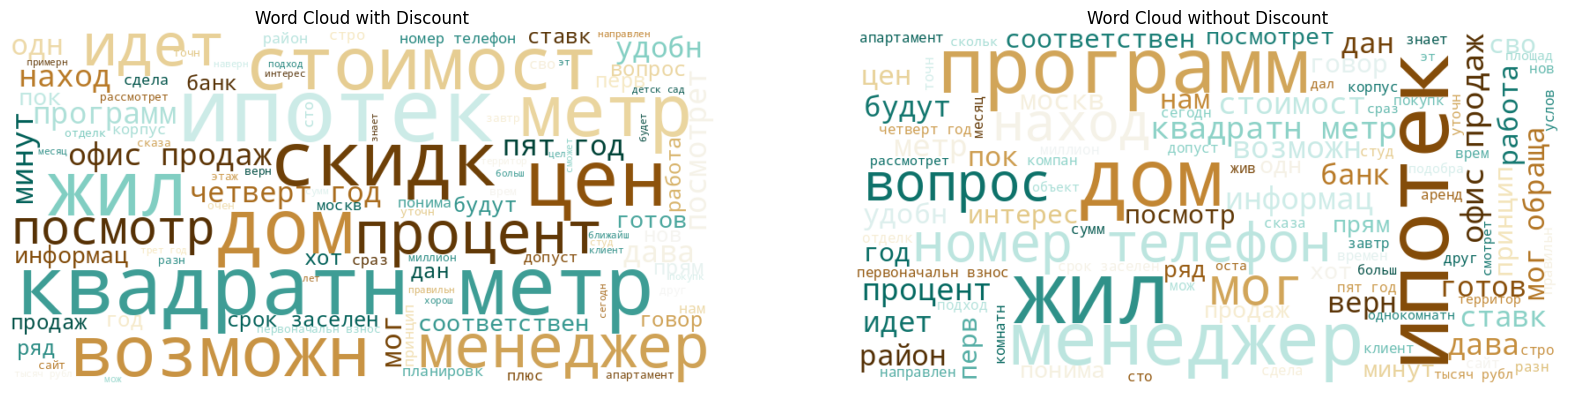

In [26]:
wc_with_discount = WordCloud(width=800, height=400, max_font_size=100, 
                             max_words=100, colormap='BrBG', background_color="white",
                             collocations=True).generate(' '.join(lemmas_with_discount))

wc_without_discount = WordCloud(width=800, height=400, max_font_size=100, 
                                max_words=100, colormap='BrBG', background_color="white",
                                collocations=True).generate(' '.join(lemmas_without_discount))

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wc_with_discount, interpolation='bilinear')
axes[0].set_title('Word Cloud with Discount')
axes[0].axis('off')

axes[1].imshow(wc_without_discount, interpolation='bilinear')
axes[1].set_title('Word Cloud without Discount')
axes[1].axis('off')

plt.show()


(-0.5, 1599.5, 799.5, -0.5)

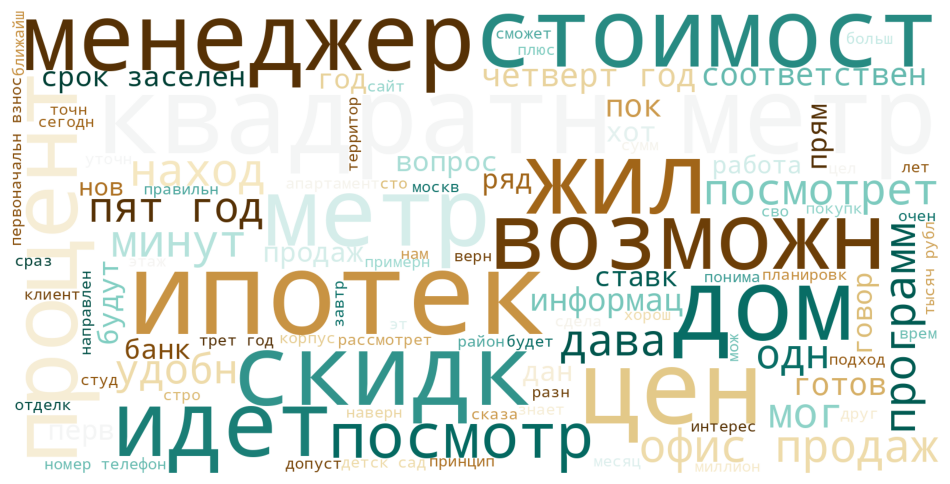

In [27]:

wc = WordCloud(width=1600, height=800, max_font_size=200, 
               max_words=100, colormap='BrBG',background_color="white",
               collocations=True).generate(' '.join(lemmas_with_discount))
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis("off")
#plt.savefig(picture_fn)

Добавим числительные скидок, воспользуемся частотными конструкциями `ЧИСЛ процент скидка` и `скидка ЧИСЛ процент`

(-0.5, 1599.5, 799.5, -0.5)

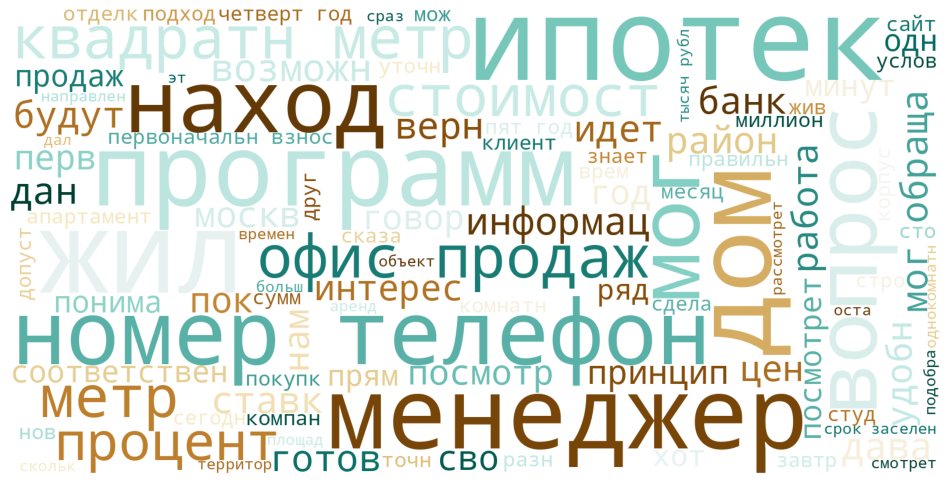

In [28]:
wc = WordCloud(width=1600, height=800, max_font_size=200, 
               max_words=100, colormap='BrBG',background_color="white",
               collocations=True).generate(' '.join(lemmas_without_discount))
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis("off")

In [29]:
lemmas_number_with_discount = [lemma for idx, lemmas in enumerate(df['extract_numbers'].str.split()) if df['has_discount'][idx] for lemma in lemmas]

(-0.5, 1599.5, 799.5, -0.5)

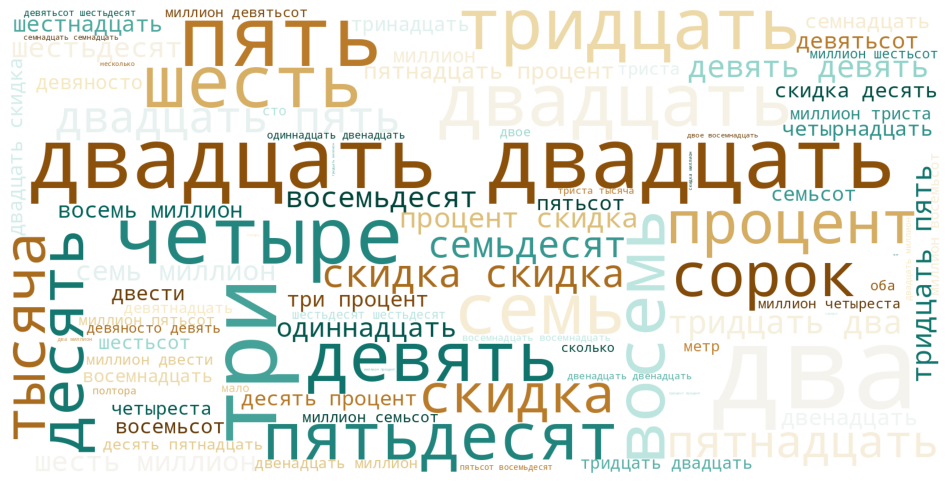

In [30]:
wc = WordCloud(width=1600, height=800, max_font_size=200, 
               max_words=100, colormap='BrBG',background_color="white",
               collocations=True).generate(' '.join(lemmas_number_with_discount))
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis("off")

In [31]:
#два процент скидка
#скидка два процент

text = 'двенадцать миллион два скидка два процент четыре процент скидка'

# Находим слово перед "процент скидка"
match_before_discount = re.search(r'(\S+)\s+процент скидка', text)
word_before_discount = match_before_discount.group(1) if match_before_discount else None

# Находим слово между "скидка" и "процент"
match_between_discount_percent = re.search(r'скидка\s+(\S+)\s+процент', text)
word_between_discount_percent = match_between_discount_percent.group(1) if match_between_discount_percent else None

print("Слово перед 'скидка':", word_before_discount)
print("Слово между 'скидка' и 'процент':", word_between_discount_percent)


Слово перед 'скидка': четыре
Слово между 'скидка' и 'процент': два


In [32]:
numr_dict = {"один":1, "два":2, "три":3, "четыре":4, "пять":5, "шесть":6, "семь":7, "восемь":8, "девять":9, "десять":10}

def get_discount_word(row):
    text = row['extract_numbers']
    # Находим слово перед "скидка"
    match_before_discount = re.search(r'(\S+)\s+процент\s+скидка', text)
    word_before_discount = match_before_discount.group(1) if match_before_discount else None

    # Находим слово между "скидка" и "процент"
    match_between_discount_percent = re.search(r'скидка\s+(\S+)\s+процент', text)
    word_between_discount_percent = match_between_discount_percent.group(1) if match_between_discount_percent else None

    numr_before_discount, numr_between_discount_percent = 1000, 1000
    if word_before_discount and word_between_discount_percent:
        if word_before_discount in numr_dict:
            numr_before_discount = numr_dict[word_before_discount]
        if word_between_discount_percent in numr_dict:
            numr_between_discount_percent = numr_dict[word_between_discount_percent]
        if numr_before_discount < numr_between_discount_percent:
            return word_before_discount
        else:
            return word_between_discount_percent
        #return f"{word_before_discount}, {word_between_discount_percent}"
    elif word_before_discount:
        return word_before_discount
    elif word_between_discount_percent:
        return word_between_discount_percent
    else:
        return None

tqdm.pandas()
df['estimated_discount'] = df.progress_apply(get_discount_word, axis=1)


100%|██████████| 999/999 [00:00<00:00, 26955.75it/s]


In [33]:
print("Всего с упоминaнием скидки", df.has_discount.sum())
print("C оцененной скидкой", df.estimated_discount.notna().sum())

Всего с упоминaнием скидки 329
C оцененной скидкой 133


In [34]:
df.estimated_discount.value_counts().head()

estimated_discount
два         39
десять      25
четыре      17
три         13
двадцать    10
Name: count, dtype: int64

In [35]:
df.estimated_discount.value_counts()

estimated_discount
два           39
десять        25
четыре        17
три           13
двадцать      10
пятнадцать     9
пять           5
шесть          3
тридцать       2
скидка         2
восемь         2
девять         2
девяносто      1
двенадцать     1
семнадцать     1
процент        1
Name: count, dtype: int64

In [36]:
text = df.loc[(df.has_discount == True) & (df.estimated_discount.isna())].talks.iloc[1]
HTML(extract_context(text, 'скидк'))

Оценили числительные скидок и определили только 30% как конкретное предлоежние. Есть диалоги с предложением "горячих скидок", "новогодних скидок"

Частота упоминания скидки в диалоге

In [37]:
# Функция для подсчета упоминаний леммы "скидка"
def count_discount_mentions(text):
    words = text.split()  # Разделение текста на слова
    return Counter(words)['скидк']  # Подсчет упоминаний слова "скидка"

df['discount_mentions'] = df['processed_talks'].apply(count_discount_mentions)

Text(0, 0.5, 'Количество диалогов')

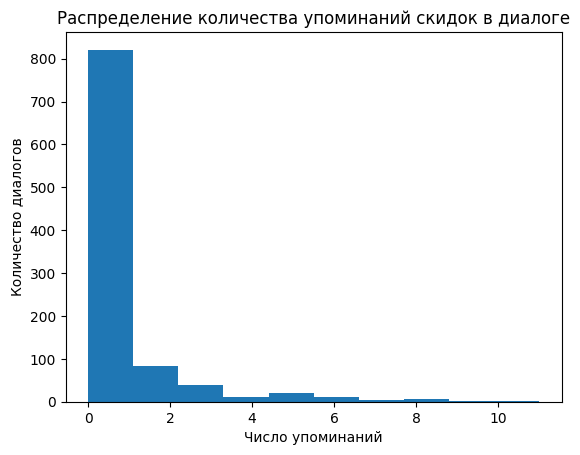

In [38]:
df.discount_mentions.value_counts()
plt.hist(df.discount_mentions)
plt.title('Распределение количества упоминаний скидок в диалоге')
plt.xlabel('Число упоминаний')
plt.ylabel('Количество диалогов')


Text(0, 0.5, 'Количество диалогов')

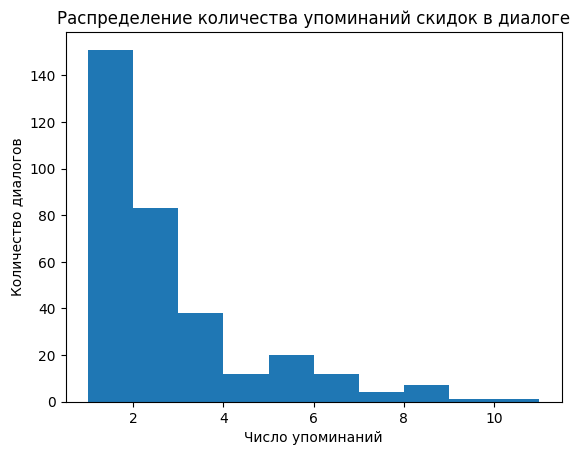

In [39]:
plt.hist(df[df.has_discount].discount_mentions)
plt.title('Распределение количества упоминаний скидок в диалоге')
plt.xlabel('Число упоминаний')
plt.ylabel('Количество диалогов')

В какой части далога впервые и в послежний раз говорят про скидки

In [40]:
def find_discount_part(dialog, index):
    if 'скидк' in dialog:
        parts = dialog.split('скидк')
        if index == 0:
            return len(parts[index]) / len(dialog)
        elif index == -1:
            return (len(dialog) - len(parts[index])) / len(dialog)

df['first_discount_location'] = df['talks'].fillna("").apply(find_discount_part, index = 0)
df['last_discount_location'] = df['talks'].fillna("").apply(find_discount_part, index = -1)


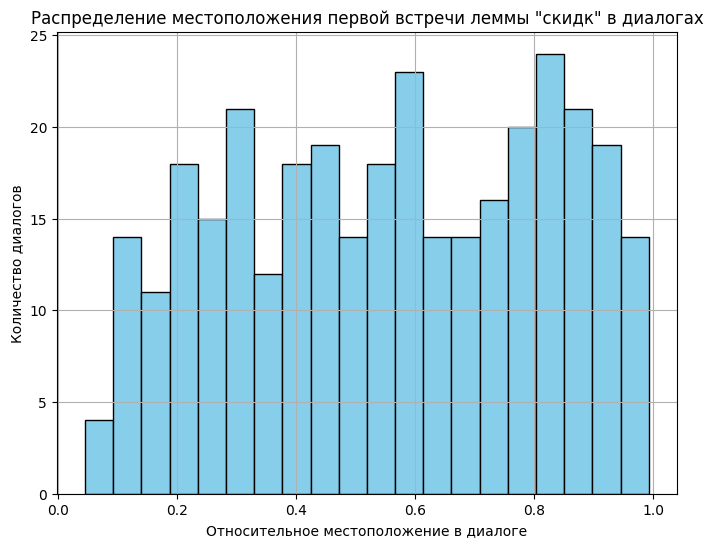

In [41]:
plt.figure(figsize=(8, 6))
plt.hist(df['first_discount_location'], bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение местоположения первой встречи леммы "скидк" в диалогах')
plt.xlabel('Относительное местоположение в диалоге')
plt.ylabel('Количество диалогов')
plt.grid(True)
plt.show()

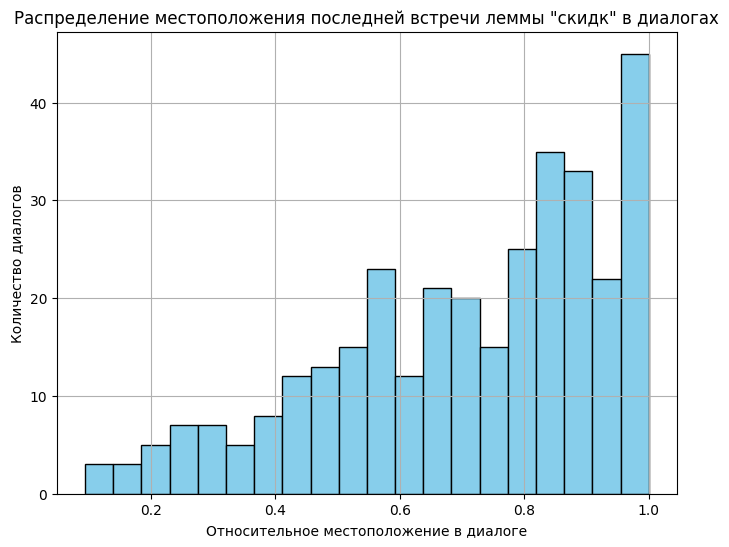

In [42]:
plt.figure(figsize=(8, 6))
plt.hist(df['last_discount_location'], bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение местоположения последней встречи леммы "скидк" в диалогах')
plt.xlabel('Относительное местоположение в диалоге')
plt.ylabel('Количество диалогов')
plt.grid(True)
plt.show()

Зависимости в местоположении первого упоминниния скидки не прослеживается.

## Тест подхода к выделению скидок

In [43]:
import torch
from transformers import AutoTokenizer, AutoModel

#tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
#model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [44]:
def text_similarity(text1, text2, model, tokenizer):
    # Получаем векторные представления для обоих текстов
    embeddings_text1 = embed_bert_cls(text1, model, tokenizer)
    embeddings_text2 = embed_bert_cls(text2, model, tokenizer)

    # Вычисляем косинусное расстояние между векторами
    similarity_score = cosine_similarity(embeddings_text1.reshape(1, -1), embeddings_text2.reshape(1, -1))[0][0]

    return similarity_score

# Пример использования
text1 = "два процент скидки"
text2 = "я хочу получить четыре процента скидки на этот объект"
similarity = text_similarity(text1, text2, model, tokenizer)
print("Косинусная близость между текстами:", similarity)


Косинусная близость между текстами: 0.6613574


In [45]:
morph = pymorphy2.MorphAnalyzer()

def replace_numerals(text):
    words = text.split()
    real_disc_numr = ""
    for i, word in enumerate(words):
        # Проверяем, является ли слово числительным
        parsed_word = morph.parse(word)[0]
        if 'NUMR' in parsed_word.tag:
            # Заменяем числительные на <DISC_NUMR>
            real_disc_numr = parsed_word.normal_form
            words[i] = '<DISC_NUMR>'
    return ' '.join(words), real_disc_numr

# Пример использования функции
text = "здравствуйте я предлагаю вам два процента скидки на эту недвижимость в хорошем районе и т.д."
highlighted_text = "два процента скидки"
processed_text = replace_numerals(text)
print("Исходный текст:", text)
print("Текст с заменой числительных:", processed_text[0])
print("Распознанное числительное:", processed_text[1])


Исходный текст: здравствуйте я предлагаю вам два процента скидки на эту недвижимость в хорошем районе и т.д.
Текст с заменой числительных: здравствуйте я предлагаю вам <DISC_NUMR> процента скидки на эту недвижимость в хорошем районе и т.д.
Распознанное числительное: два


In [49]:
def find_word_ngrams_with_discount(text, target_embedding, model, tokenizer):

    n_grams = [5] #[3,5,9]
    closest_ngram = ''
    max_similarity = 0.0

    words = word_tokenize(text)

    for n in n_grams:
        # Генерируем н-граммы слов
        ngrams = [words[i:i+n] for i in range(len(words)-n+1)]
        for ngram in ngrams:
            if 'скидк' in ' '.join(ngram):  # Проверяем, содержит ли н-грамма лемму 'скидка'
                ngram_text = ' '.join(ngram)
                ngram_embedding = model(**tokenizer(ngram_text, return_tensors='pt')).last_hidden_state.mean(dim=1)
                similarity_score = torch.cosine_similarity(target_embedding, ngram_embedding).item()
                if similarity_score > max_similarity:
                    max_similarity = similarity_score
                    closest_ngram = ngram_text

                    # Извлекаем индексы слов, составляющих текущую н-грамму
                    start_idx = words.index(ngram[0])
                    end_idx = words.index(ngram[-1]) + 1

                    # Заменяем числительное в н-грамме на <DISC_NUMR>
                    replaced_ngram, disc_numr = replace_numerals(ngram_text)

                    # Формируем текст с заменой числительного на <DISC_NUMR>
                    text_w_template = ' '.join(words[:start_idx]) + ' ' + replaced_ngram + ' ' + ' '.join(words[end_idx:])

    if max_similarity >= 0.5:
        return closest_ngram, max_similarity, text_w_template, disc_numr
    else:
        return None, None, text, None
tqdm.pandas()

target_phrase = 'скидка два процента'
target_tokens = tokenizer(target_phrase, return_tensors='pt')['input_ids']
target_embedding_one = model(**tokenizer(target_phrase, return_tensors='pt')).last_hidden_state.mean(dim=1)

target_phrase = 'четыре процента скидки'
target_tokens = tokenizer(target_phrase, return_tensors='pt')['input_ids']
target_embedding_two = model(**tokenizer(target_phrase, return_tensors='pt')).last_hidden_state.mean(dim=1)

target_embedding = (target_embedding_one + target_embedding_two) / 2


In [50]:
text = df[df.has_discount].talks.iloc[1]
find_word_ngrams_with_discount(text, target_embedding, model, tokenizer)

('сейчас два процента скидка для',
 0.90592360496521,
 'здравствуйте группа самали вот меня зовут очень приятно у нас все проекты идут с фистовой отделкой с кухонным гарнитуром то есть это стандарт компара однокомнатное у тридцати двух квадратных метров начинается ну вы для себя же правильно понимаю рассматриваете покупку вот нам нужно с вами с района определиться в проектов очень много а да что именно рассматриваете может какой то город определенный так если юго восток то здесь можно рассмотреть фамилия пар метро как парка два проекта рядом располотомелина будет наверное по бюджетнее потому что стамилина есть у тридцати двух квадратов с предложения а егора там только от сра больше по площади ну сейчас <DISC_NUMR> процента скидка для себя же правильно понимаю рассматриваете покупку вот нам нужно с вами с района определиться в проектов очень много а да что именно рассматриваете может какой то город определенный так если юго восток то здесь можно рассмотреть фамилия пар метро как парка д

In [51]:
df[['closest_word_ngram', 'word_ngrams_similarity', 'text_w_temp_disc', 'disc_numr']] = pd.DataFrame(df['talks']\
    .fillna("")\
    .progress_apply(lambda x: find_word_ngrams_with_discount(x,
                                                             target_embedding,
                                                             model,
                                                             tokenizer)).tolist(), index=df.index)

100%|██████████| 999/999 [01:08<00:00, 14.62it/s]


In [52]:
df.closest_word_ngram.unique()[:20]

array([None, 'действие дополнительная скидка четыре процента',
       'сейчас два процента скидка для', 'два дня после обращения скидки',
       'и даже персональную скидку а', 'горячей скидки за третье есть',
       'новогодние скидки и акции сам',
       'дополнительная скидка один процент зависе',
       'действует скидка четыре процент и',
       'вот скидка на приобретение квартиры',
       'возможно и скидки про акции', 'работаю скидки примерно и мы',
       'на скидку три процента дополнительной',
       'и вообще свои скидки делают',
       'процентов скидки десять процентов скидки',
       'делать расчеты по скидкам от',
       'внизу скидка десять процентов цена',
       'можно выбрать есть скидки цена', 'то есть маленькая скидка а',
       'дополнительная скидка один процент то'], dtype=object)

In [53]:
df.disc_numr.value_counts()

disc_numr
              199
два            32
десять         27
четыре         19
три            11
двадцать        6
пять            5
семь            4
пятнадцать      3
восемь          3
девятьсот       2
семьсот         2
триста          2
шесть           2
четыреста       1
сорок           1
двенадцать      1
тридцать        1
пятьсот         1
тринадцать      1
девять          1
оба             1
Name: count, dtype: int64

In [54]:
df.estimated_discount.value_counts()

estimated_discount
два           39
десять        25
четыре        17
три           13
двадцать      10
пятнадцать     9
пять           5
шесть          3
тридцать       2
скидка         2
восемь         2
девять         2
девяносто      1
двенадцать     1
семнадцать     1
процент        1
Name: count, dtype: int64

In [55]:
df[['disc_numr', 'estimated_discount']].value_counts()

disc_numr   estimated_discount
два         два                   25
десять      десять                17
            два                   13
четыре      четыре                12
три         три                    9
            пятнадцать             8
            двадцать               4
            десять                 4
двадцать    двадцать               4
пять        пять                   3
            три                    3
            четыре                 3
            тридцать               2
            девять                 2
пятнадцать  пятнадцать             1
пятьсот     четыре                 1
            восемь                 1
три         пять                   1
десять      четыре                 1
тридцать    десять                 1
четыре      два                    1
            двадцать               1
            десять                 1
десять      шесть                  1
два         три                    1
десять      скидка                 1
двадцат

In [56]:
text = df[df.estimated_discount == 'двадцать'].text_w_temp_disc.iloc[1]
HTML(extract_context(text, 'двадцать'))

In [57]:
df[df.estimated_discount == 'двадцать'].iloc[1]

index                                                                    185
talks                      добрый день просто самолет меня зовут евгения ...
target                                                                     0
client                                                                  None
hash                                                      258861359691145401
target_client                                                              0
extract_numbers            пятнадцать двадцать двадцать двадцать тридцать...
processed_talks            евген остойт плох голос метр замечательн рассм...
has_discount                                                            True
has_competitiors                                                       False
estimated_discount                                                  двадцать
discount_mentions                                                          8
first_discount_location                                             0.137726

In [58]:
text = df[df.disc_numr.notna()].iloc[1].text_w_temp_disc
HTML(extract_context(text, 'DISC_NUMR'))

In [59]:
df.to_csv('data_prep_05_05.csv')

## Ресерч таргетов

In [60]:
df.target.value_counts(),df.target.value_counts() / len(df)

(target
 0    988
 1     11
 Name: count, dtype: int64,
 target
 0    0.988989
 1    0.011011
 Name: count, dtype: float64)

In [61]:
df.groupby('client',as_index = False).talks.count().talks.value_counts()

talks
1    244
Name: count, dtype: int64

In [62]:
#длина диалогов

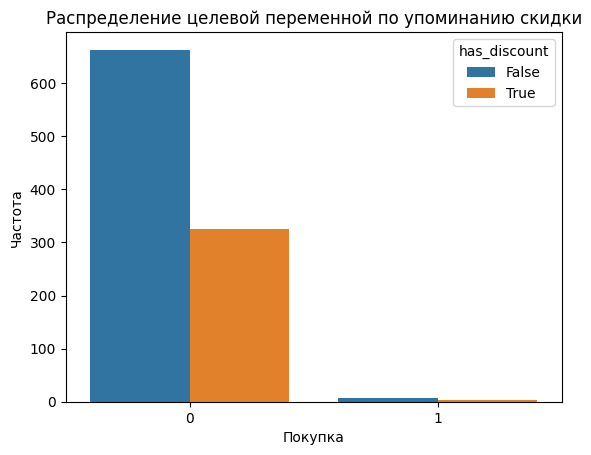

In [63]:
sns.countplot(data=df, x='target', hue='has_discount')
plt.title('Распределение целевой переменной по упоминанию скидки')
plt.xlabel('Покупка')
plt.ylabel('Частота')
plt.show()


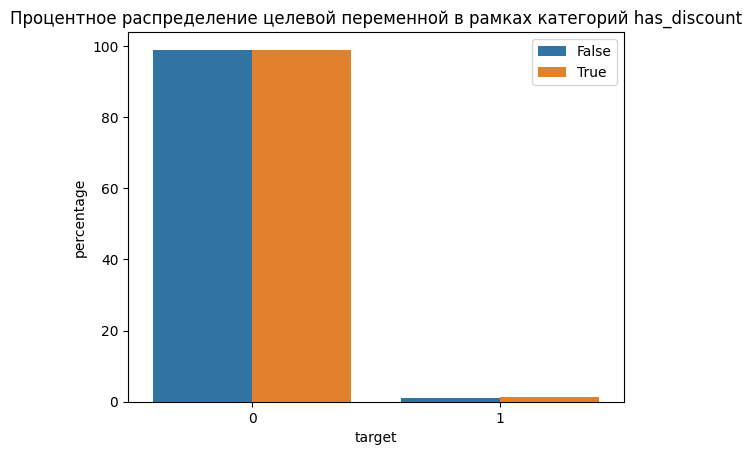

In [64]:
grouped_data = df.groupby('has_discount')['target'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

sns.barplot(data=grouped_data, x='target', hue='has_discount', y = 'percentage')
plt.title('Процентное распределение целевой переменной в рамках категорий has_discount')
plt.legend()
plt.show()


In [65]:
grouped_data

has_discount  target  percentage
0         False       0   98.955224
1         False       1    1.044776
2          True       0   98.784195
3          True       1    1.215805

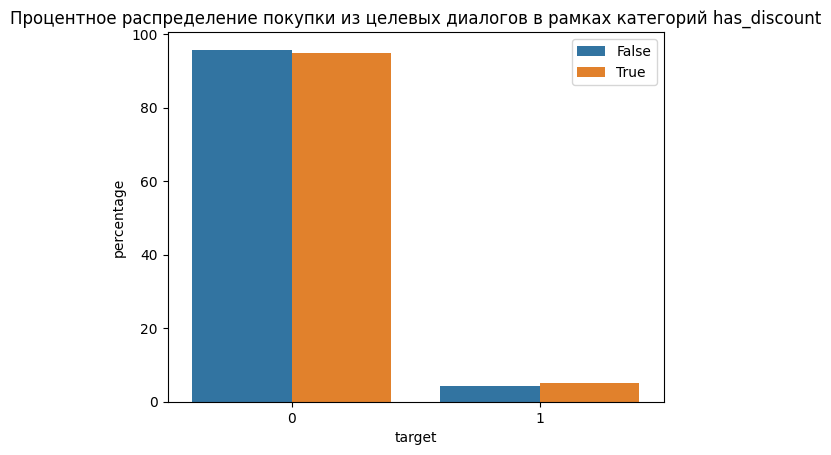

In [66]:
grouped_data = df.loc[df.client.notna()].groupby('has_discount')['target'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

sns.barplot(data=grouped_data, x='target', hue='has_discount', y = 'percentage')
plt.title('Процентное распределение покупки из целевых диалогов в рамках категорий has_discount')
plt.legend()
plt.show()


In [67]:
grouped_data

has_discount  target  percentage
0         False       0   95.757576
1         False       1    4.242424
2          True       0   94.936709
3          True       1    5.063291

In [68]:
df['offer_specific_discount'] = df.disc_numr.notna()

In [69]:
df.groupby('offer_specific_discount')['target'].value_counts()

offer_specific_discount  target
False                    0         667
                         1           7
True                     0         321
                         1           4
Name: count, dtype: int64

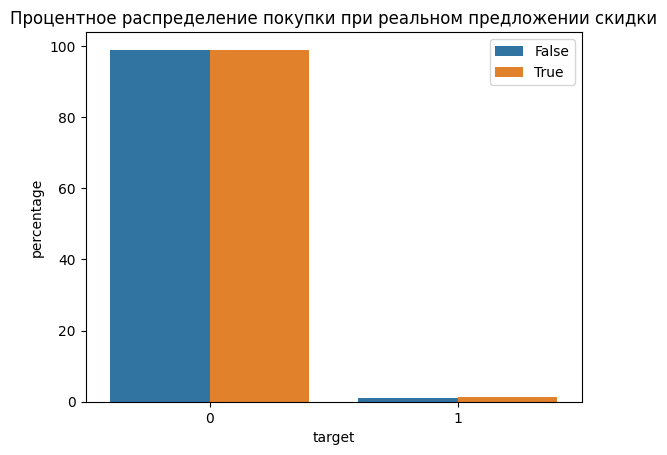

In [70]:
grouped_data = df.groupby('offer_specific_discount')['target'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

sns.barplot(data=grouped_data, x='target', hue='offer_specific_discount', y = 'percentage')
plt.title('Процентное распределение покупки при реальном предложении скидки')
plt.legend()
plt.show()


In [71]:
all_lemmas = [lemma for lemmas in df['processed_talks'].str.split() for lemma in lemmas]

lemmas_with_target = [lemma for idx, lemmas in enumerate(df['processed_talks'].str.split()) if df['target'][idx] for lemma in lemmas]
lemmas_without_target = [lemma for idx, lemmas in enumerate(df['processed_talks'].str.split()) if not df['target'][idx] for lemma in lemmas]

lemma_counts_with_target = Counter(lemmas_with_target)
lemma_counts_without_target = Counter(lemmas_without_target)

top_lemmas_with_target = pd.DataFrame.from_dict(lemma_counts_with_target, orient='index',
                       columns=['Frequency_With_Target']).reset_index().rename(columns = {"index":"Lemma"})

top_lemmas_without_target = pd.DataFrame.from_dict(lemma_counts_without_target, orient='index',
                       columns=['Frequency_Without_Target']).reset_index().rename(columns = {"index":"Lemma"})

top_lemmas_df = pd.merge(top_lemmas_with_target, top_lemmas_without_target, on='Lemma', how='outer')
top_lemmas_df = top_lemmas_df.fillna(0)

top_lemmas_df['Frequency_Difference'] = top_lemmas_df['Frequency_With_Target']/\
top_lemmas_df['Frequency_With_Target'].sum() \
                - top_lemmas_df['Frequency_Without_Target']/top_lemmas_df['Frequency_Without_Target'].sum()

top_lemmas_df = top_lemmas_df.sort_values(by='Frequency_Difference', ascending=False)

top_lemmas_df.head(10)

Lemma  Frequency_With_Discount  Frequency_Without_Discount  \
5457           мог                     30.0                      1354.0   
10665       сегодн                     21.0                       302.0   
11912      телефон                     21.0                       581.0   
6326         номер                     20.0                       687.0   
5258      менеджер                     20.0                       818.0   
10858        скидк                     17.0                       738.0   
5762        назнач                     11.0                       104.0   
13040          час                     10.0                       238.0   
3025   забронирова                      8.0                        88.0   
1084           виж                      8.0                       119.0   

       Frequency_Difference  
5457               0.013379  
10665              0.013075  
11912              0.011472  
6326               0.010158  
5258               0.009405  
10858              0.007749  
5762               0.007160  
13040              0.005685  
3025               0.005136  
1084               0.004958

In [72]:
#как связан таргет с остальными фичами

In [75]:
df['dialog_length'] = df['talks'].apply(lambda x: len(str(x).split()))

In [76]:
df_features = df[['target', 'target_client', 'has_discount', 'discount_mentions',
    'first_discount_location', 'last_discount_location', 
    'word_ngrams_similarity', 'disc_numr', 'dialog_length']]

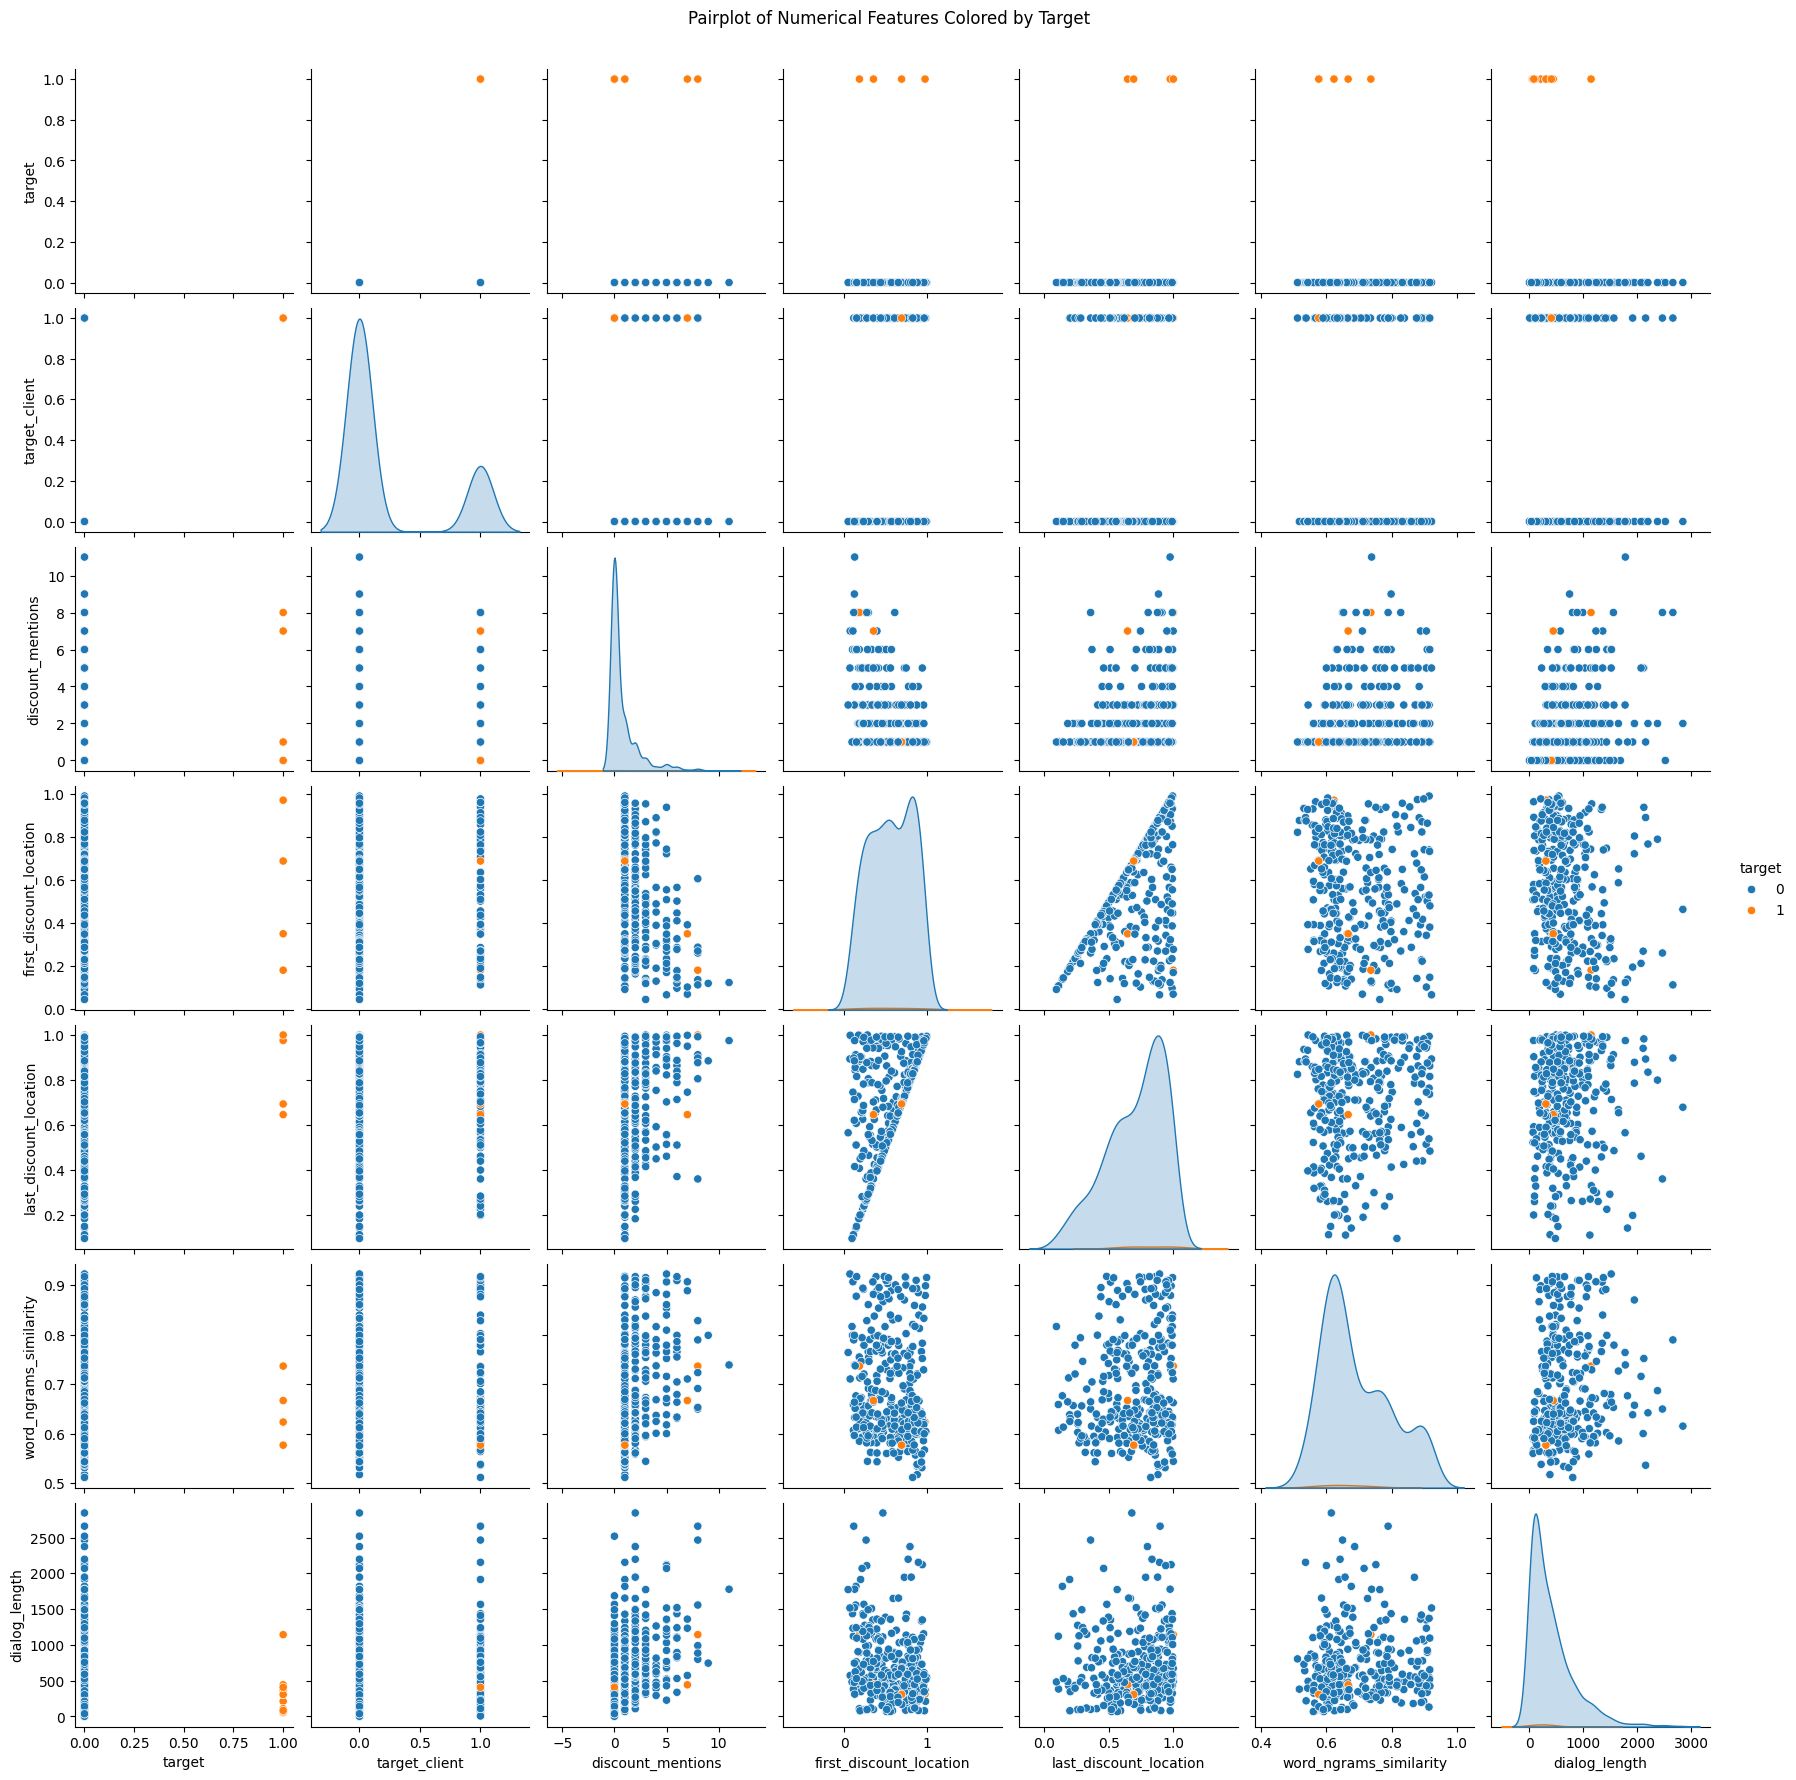

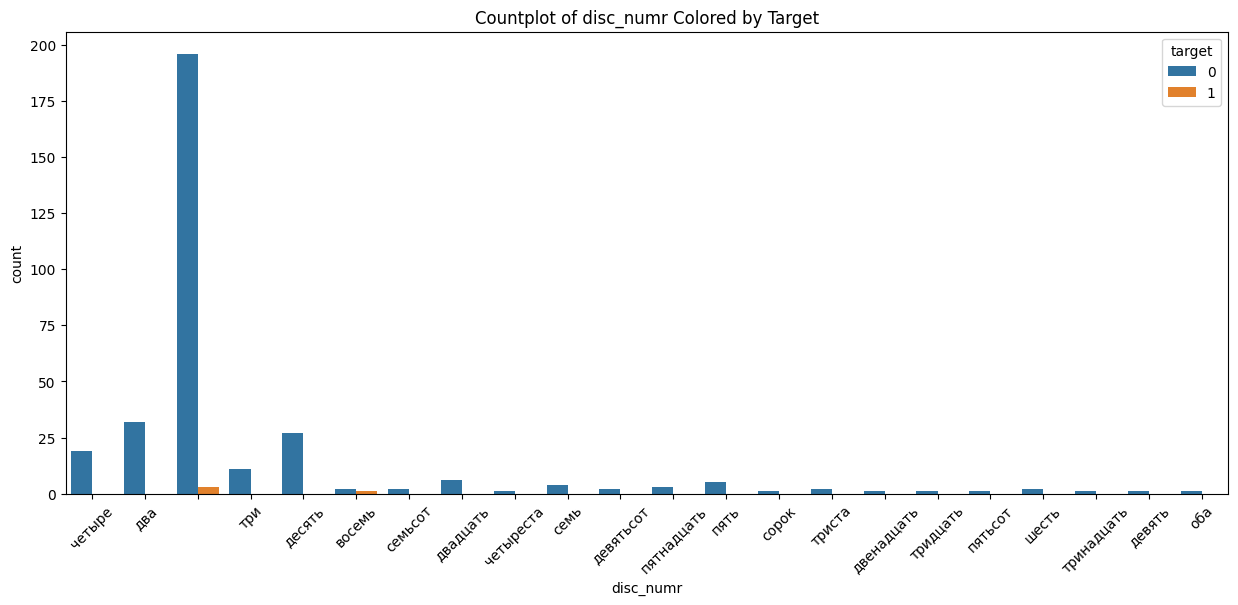

In [77]:
numerical_features = df_features.select_dtypes(include=['float64', 'int64']).columns.tolist()

sns.pairplot(df_features, hue='target', vars=numerical_features)
plt.suptitle('Pairplot of Numerical Features Colored by Target', y=1.02)
plt.show()

categorical_features = df_features.select_dtypes(include=['object', 'category']).columns.tolist()

for feature in categorical_features:
    plt.figure(figsize=(15, 6))
    sns.countplot(data=df_features, x=feature, hue='target')
    plt.title(f'Countplot of {feature} Colored by Target')
    plt.xticks(rotation=45)
    plt.show()

Text(0.5, 1.0, 'Матрица корреляций')

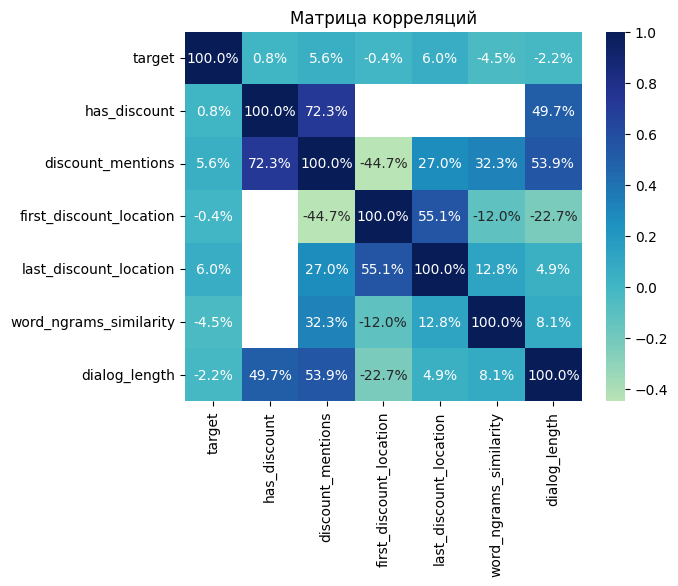

In [451]:
df_corr = df[['target', 'has_discount', 'discount_mentions',
    'first_discount_location', 'last_discount_location', 
    'word_ngrams_similarity', 'dialog_length']].corr()
sns.heatmap(df_corr, annot=True, fmt=".1%", center = 0, cmap="YlGnBu")
plt.title('Матрица корреляций')

In [78]:
df.to_csv('data_prep_05_05.csv')

## Создание модели

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from mlxtend.evaluate import lift_score
import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric
from sklearn.calibration import CalibratedClassifierCV


In [313]:
def evaluate_model_predictions(y_test, y_pred_proba, threshold=0.5, visual=True, save_metrics_df=None, model_name=None):
    """
    Оценивает метрики и строит графики ROC AUC и PR AUC на основе предсказаний модели.

    Parameters:
    y_test: array-like
        Истинные метки.
    y_pred_proba: array-like
        Предсказанные вероятности.
    threshold: float
        Порог для бинарной классификации.
    visual: bool, optional (default=True)
        Флаг для отображения графиков.
    save: bool, optional (default=False)
        Флаг для сохранения метрик в датафрейм.
    metrics_df: pd.DataFrame, optional
        Датафрейм для сохранения метрик (если save=True).
    model_name: object, optional
        Название модели.

    Returns:
    dict
        Словарь с метриками.
    """
    y_pred = (y_pred_proba > threshold).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_vals, precision_vals)

    pos_rate = np.mean(y_test)
    #max_lift = 1 / pos_rate
    #lift = calculate_lift(y_test, y_pred_proba, len(y_test))
    #lift = recall / pos_rate
    lift = lift_score(y_test, y_pred)
    max_lift = lift_score(y_test, y_test)

    # Вывод метрик
    if visual:
        print("Evaluation Metrics:")
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1)
        print("ROC AUC score:", roc_auc)
        print("PR AUC score:", pr_auc)
        print("Lift:", lift, '(Max lift:', max_lift, ')')
        print()

        # Построение графика ROC AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")

        # Построение графика PR AUC
        plt.subplot(1, 2, 2)
        plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall (PR) Curve')
        plt.legend(loc="lower left")

        plt.tight_layout()
        plt.show()

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "lift": lift,
        "max_lift": max_lift
    }

    if model_name and save_metrics_df is not None:
        metrics_row = pd.DataFrame.from_dict(metrics, orient='index')
        metrics_row.loc['model_name'] = model_name
        metrics_row.loc['threshold'] = threshold
        save_metrics_df = pd.concat([save_metrics_df, metrics_row.T])

    return metrics, save_metrics_df

metrics_df = pd.DataFrame(columns=["model_name", "precision", "recall", "f1_score", "roc_auc", "pr_auc", "lift"#"max_lift"
                                  ])

In [456]:
df = pd.read_csv('data_prep_05_05.csv')
#target_column = 'target'
target_column = 'target_client'

In [457]:
df.processed_talks = df.processed_talks.fillna("")
df['target_client'] = df.client.notna().astype('int')
df.text_w_temp_disc = df.text_w_temp_disc.fillna("")

### Базовая модель - всем по два процента

Не знаем, что с теми, кто не купил. Могли им дать скидку и конвертировать в покупку. Проведем оценку снизу, предлагаем всем по два процента скидки и посчитаем, что бы получили из таргетированных клиентов


In [458]:
#df.test_two_disc.disc_numr.value_counts()

In [459]:
test_two_disc = df.copy()
test_two_disc['y_pred'] = 0
print('Потери продаж:', test_two_disc.loc[(test_two_disc.disc_numr != 'два') & (test_two_disc.disc_numr.notna()), 'target'].sum())
print('Потери продаж (за счет купленных с большей скидкой), %:', round(test_two_disc.loc[(test_two_disc.disc_numr != 'два') & (test_two_disc.disc_numr.notna()), 'target'].sum() / test_two_disc.target.sum() * 100,2))
print('Рост продаж (за счет не предложенной скидки), %:', None)
#трансформировать эту историю в пересчет вероятностей в зависимости от числительного скидки
#на тестовой выборке скор


Потери продаж: 1
Потери продаж (за счет купленных с большей скидкой), %: 9.09
Рост продаж (за счет не предложенной скидки), %: None


### Модель с использованием эмбедингов

In [460]:
train_data, test_data = train_test_split(df, test_size=0.4, random_state=42, stratify=df[target_column])
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42, stratify=test_data[target_column])

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['processed_talks'])
X_test = vectorizer.transform(test_data['processed_talks'])
X_val = vectorizer.transform(test_data['processed_talks'])

y_train = train_data[target_column]
y_test = test_data[target_column]
y_val = test_data[target_column]

X_train_array = X_train.toarray()
X_test_array = X_test.toarray()
X_val_array = X_val.toarray()

Learning rate set to 0.027921
0:	learn: 0.6845461	test: 0.6850135	best: 0.6850135 (0)	total: 27.8ms	remaining: 27.8s
100:	learn: 0.4350344	test: 0.5547073	best: 0.5521842 (82)	total: 2.27s	remaining: 20.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5521841958
bestIteration = 82

Shrink model to first 83 iterations.
Evaluation Metrics:
Precision: 0.245
Recall: 1.0
F1-score: 0.39357429718875503
ROC AUC score: 0.5830517637518584
PR AUC score: 0.2971532888589506
Lift: 1.0 (Max lift: 4.081632653061225 )



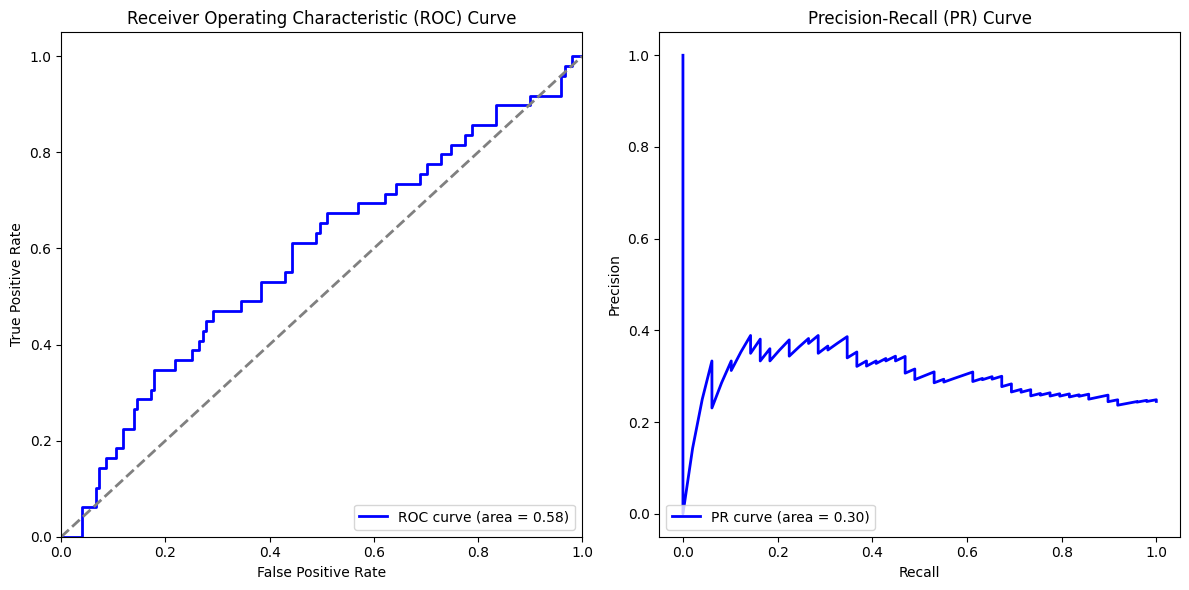

In [461]:
catboost_model = CatBoostClassifier(iterations=1000, verbose=100, early_stopping_rounds=50, use_best_model = True
                                   )
catboost_model.fit(X_train_array, y_train, eval_set=(X_test_array, y_test))

y_pred_proba = catboost_model.predict_proba(X_test_array)[:, 1]

metrics = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.1)

In [845]:
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5000),
        'subsample': trial.suggest_float("subsample", 0.05, 1.0),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostClassifier(**params, iterations=1000, verbose=100, early_stopping_rounds=50, use_best_model = True, random_seed=42)
    model.fit(X_train_array, y_train, eval_set=(X_test_array, y_test))
    y_pred_proba = model.predict_proba(X_test_array)[:, 1]
    metrics = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.1, visual = False)[0]['roc_auc']
    return metrics

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)


[I 2024-06-24 10:48:07,611] A new study created in memory with name: no-name-d8859c08-8550-47c0-b920-263bc0acb756


0:	learn: 0.6887817	test: 0.6889303	best: 0.6889303 (0)	total: 72ms	remaining: 1m 11s
100:	learn: 0.5550428	test: 0.5722142	best: 0.5722142 (100)	total: 6.22s	remaining: 55.4s
200:	learn: 0.5398028	test: 0.5638910	best: 0.5638800 (199)	total: 12.4s	remaining: 49.3s
300:	learn: 0.5314584	test: 0.5626474	best: 0.5626321 (298)	total: 18.6s	remaining: 43.2s
400:	learn: 0.5249054	test: 0.5615952	best: 0.5615952 (400)	total: 24.7s	remaining: 36.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5612486335
bestIteration = 434

Shrink model to first 435 iterations.


[I 2024-06-24 10:48:40,866] Trial 0 finished with value: 0.4845249358021354 and parameters: {'depth': 8, 'l2_leaf_reg': 1431.410535416947, 'subsample': 0.26550888088599295, 'colsample_bylevel': 0.5737490306287467, 'min_data_in_leaf': 72}. Best is trial 0 with value: 0.4845249358021354.


0:	learn: 0.6911668	test: 0.6913780	best: 0.6913780 (0)	total: 27.1ms	remaining: 27s
100:	learn: 0.5905983	test: 0.5959070	best: 0.5959070 (100)	total: 2.5s	remaining: 22.3s
200:	learn: 0.5596918	test: 0.5703526	best: 0.5703526 (200)	total: 4.91s	remaining: 19.5s
300:	learn: 0.5423318	test: 0.5633590	best: 0.5633590 (300)	total: 7.37s	remaining: 17.1s
400:	learn: 0.5340233	test: 0.5619579	best: 0.5619579 (400)	total: 9.83s	remaining: 14.7s
500:	learn: 0.5282550	test: 0.5612714	best: 0.5612714 (500)	total: 12.3s	remaining: 12.3s
600:	learn: 0.5233246	test: 0.5607958	best: 0.5607883 (597)	total: 14.8s	remaining: 9.82s
700:	learn: 0.5204831	test: 0.5604998	best: 0.5604932 (694)	total: 17.3s	remaining: 7.38s
800:	learn: 0.5178522	test: 0.5604823	best: 0.5604347 (758)	total: 19.8s	remaining: 4.92s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5604346557
bestIteration = 758

Shrink model to first 759 iterations.


[I 2024-06-24 10:49:04,482] Trial 1 finished with value: 0.5038518718745777 and parameters: {'depth': 6, 'l2_leaf_reg': 4903.840227724692, 'subsample': 0.7005882516556201, 'colsample_bylevel': 0.5068853064101428, 'min_data_in_leaf': 40}. Best is trial 1 with value: 0.5038518718745777.


0:	learn: 0.6906169	test: 0.6906192	best: 0.6906192 (0)	total: 17.2ms	remaining: 17.2s
100:	learn: 0.5787009	test: 0.5810049	best: 0.5810049 (100)	total: 1.84s	remaining: 16.4s
200:	learn: 0.5562308	test: 0.5618670	best: 0.5618670 (200)	total: 3.63s	remaining: 14.4s
300:	learn: 0.5483612	test: 0.5588119	best: 0.5587606 (298)	total: 5.45s	remaining: 12.6s
400:	learn: 0.5433996	test: 0.5577870	best: 0.5577870 (400)	total: 7.25s	remaining: 10.8s
500:	learn: 0.5396859	test: 0.5571817	best: 0.5571817 (500)	total: 9.02s	remaining: 8.99s
600:	learn: 0.5362049	test: 0.5564711	best: 0.5564708 (599)	total: 10.9s	remaining: 7.21s
700:	learn: 0.5330426	test: 0.5557085	best: 0.5557085 (700)	total: 12.7s	remaining: 5.4s
800:	learn: 0.5297468	test: 0.5555203	best: 0.5554783 (774)	total: 14.5s	remaining: 3.6s
900:	learn: 0.5270159	test: 0.5552454	best: 0.5552103 (891)	total: 16.3s	remaining: 1.79s
999:	learn: 0.5244322	test: 0.5550209	best: 0.5549998 (958)	total: 18.1s	remaining: 0us

bestTest = 0.554

[I 2024-06-24 10:49:26,210] Trial 2 finished with value: 0.5599405325043925 and parameters: {'depth': 5, 'l2_leaf_reg': 3645.519487212824, 'subsample': 0.46664363244564316, 'colsample_bylevel': 0.10669400177908993, 'min_data_in_leaf': 40}. Best is trial 2 with value: 0.5599405325043925.


0:	learn: 0.6885628	test: 0.6888283	best: 0.6888283 (0)	total: 80.2ms	remaining: 1m 20s
100:	learn: 0.5486201	test: 0.5690142	best: 0.5690142 (100)	total: 6.22s	remaining: 55.4s
200:	learn: 0.5333456	test: 0.5615875	best: 0.5615875 (200)	total: 12.4s	remaining: 49.1s
300:	learn: 0.5245015	test: 0.5602371	best: 0.5602235 (293)	total: 18.5s	remaining: 43s
400:	learn: 0.5166057	test: 0.5588274	best: 0.5588274 (400)	total: 24.7s	remaining: 36.9s
500:	learn: 0.5083545	test: 0.5581659	best: 0.5580583 (460)	total: 31s	remaining: 30.9s
600:	learn: 0.5019550	test: 0.5570255	best: 0.5570255 (600)	total: 37.2s	remaining: 24.7s
700:	learn: 0.4957540	test: 0.5563510	best: 0.5563287 (694)	total: 43.3s	remaining: 18.5s
800:	learn: 0.4890681	test: 0.5557427	best: 0.5556956 (794)	total: 49.5s	remaining: 12.3s
900:	learn: 0.4828229	test: 0.5554122	best: 0.5552914 (894)	total: 55.6s	remaining: 6.11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5552913674
bestIteration = 894

Shrink

[I 2024-06-24 10:50:28,327] Trial 3 finished with value: 0.5546695499391809 and parameters: {'depth': 8, 'l2_leaf_reg': 913.2761605370464, 'subsample': 0.2166791683401179, 'colsample_bylevel': 0.5549738051497465, 'min_data_in_leaf': 54}. Best is trial 2 with value: 0.5599405325043925.


0:	learn: 0.6912308	test: 0.6913823	best: 0.6913823 (0)	total: 77ms	remaining: 1m 16s
100:	learn: 0.5885656	test: 0.5954583	best: 0.5954583 (100)	total: 5.96s	remaining: 53s
200:	learn: 0.5547390	test: 0.5696499	best: 0.5696499 (200)	total: 12.1s	remaining: 47.9s
300:	learn: 0.5377557	test: 0.5634687	best: 0.5634687 (300)	total: 18.1s	remaining: 42.1s
400:	learn: 0.5300305	test: 0.5628678	best: 0.5628675 (399)	total: 24s	remaining: 35.9s
500:	learn: 0.5252294	test: 0.5621920	best: 0.5621799 (495)	total: 30.2s	remaining: 30.1s
600:	learn: 0.5215034	test: 0.5616809	best: 0.5616809 (600)	total: 36.3s	remaining: 24.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5616660489
bestIteration = 616

Shrink model to first 617 iterations.


[I 2024-06-24 10:51:12,066] Trial 4 finished with value: 0.4935802135423706 and parameters: {'depth': 8, 'l2_leaf_reg': 4247.30953859487, 'subsample': 0.7382325586176035, 'colsample_bylevel': 0.6304723351437037, 'min_data_in_leaf': 73}. Best is trial 2 with value: 0.5599405325043925.


0:	learn: 0.6889344	test: 0.6888135	best: 0.6888135 (0)	total: 18.3ms	remaining: 18.3s
100:	learn: 0.5586344	test: 0.5692328	best: 0.5692328 (100)	total: 1.76s	remaining: 15.6s
200:	learn: 0.5437801	test: 0.5606467	best: 0.5606467 (200)	total: 3.47s	remaining: 13.8s
300:	learn: 0.5376914	test: 0.5591183	best: 0.5591117 (299)	total: 5.16s	remaining: 12s
400:	learn: 0.5321251	test: 0.5587968	best: 0.5587245 (372)	total: 6.86s	remaining: 10.2s
500:	learn: 0.5275718	test: 0.5578369	best: 0.5578369 (500)	total: 8.52s	remaining: 8.49s
600:	learn: 0.5230742	test: 0.5572856	best: 0.5572856 (600)	total: 10.2s	remaining: 6.77s
700:	learn: 0.5194513	test: 0.5568603	best: 0.5567908 (693)	total: 11.9s	remaining: 5.07s
800:	learn: 0.5155050	test: 0.5564295	best: 0.5564295 (800)	total: 13.6s	remaining: 3.38s
900:	learn: 0.5116688	test: 0.5561665	best: 0.5561026 (881)	total: 15.3s	remaining: 1.68s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5560965598
bestIteration = 912

Shrin

[I 2024-06-24 10:51:32,171] Trial 5 finished with value: 0.5514258683605893 and parameters: {'depth': 5, 'l2_leaf_reg': 1809.5814894559483, 'subsample': 0.2668500693350078, 'colsample_bylevel': 0.32902834406938786, 'min_data_in_leaf': 64}. Best is trial 2 with value: 0.5599405325043925.


0:	learn: 0.6893996	test: 0.6896252	best: 0.6896252 (0)	total: 10ms	remaining: 10s
100:	learn: 0.5623050	test: 0.5679508	best: 0.5679508 (100)	total: 798ms	remaining: 7.1s
200:	learn: 0.5474636	test: 0.5583201	best: 0.5582886 (199)	total: 1.54s	remaining: 6.11s
300:	learn: 0.5400105	test: 0.5560345	best: 0.5560345 (300)	total: 2.32s	remaining: 5.4s
400:	learn: 0.5339124	test: 0.5556671	best: 0.5556169 (394)	total: 3.09s	remaining: 4.62s
500:	learn: 0.5292035	test: 0.5553162	best: 0.5552626 (490)	total: 3.85s	remaining: 3.84s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5551166938
bestIteration = 528

Shrink model to first 529 iterations.


[I 2024-06-24 10:51:40,058] Trial 6 finished with value: 0.5695364238410596 and parameters: {'depth': 3, 'l2_leaf_reg': 2169.0721622249616, 'subsample': 0.45931962516316155, 'colsample_bylevel': 0.5190008427677909, 'min_data_in_leaf': 43}. Best is trial 6 with value: 0.5695364238410596.


0:	learn: 0.6896670	test: 0.6900163	best: 0.6900163 (0)	total: 20ms	remaining: 20s
100:	learn: 0.5591210	test: 0.5699525	best: 0.5699525 (100)	total: 1.7s	remaining: 15.1s
200:	learn: 0.5406479	test: 0.5591790	best: 0.5591790 (200)	total: 3.33s	remaining: 13.3s
300:	learn: 0.5322152	test: 0.5569904	best: 0.5569821 (297)	total: 4.92s	remaining: 11.4s
400:	learn: 0.5270250	test: 0.5560745	best: 0.5560675 (398)	total: 6.54s	remaining: 9.76s
500:	learn: 0.5243528	test: 0.5558419	best: 0.5558397 (496)	total: 8.14s	remaining: 8.11s
600:	learn: 0.5212101	test: 0.5556399	best: 0.5556091 (583)	total: 9.75s	remaining: 6.47s
700:	learn: 0.5187468	test: 0.5555419	best: 0.5554833 (683)	total: 11.3s	remaining: 4.83s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5554833213
bestIteration = 683

Shrink model to first 684 iterations.


[I 2024-06-24 10:51:55,525] Trial 7 finished with value: 0.5507501013650493 and parameters: {'depth': 5, 'l2_leaf_reg': 2132.3301835070783, 'subsample': 0.8987197049612781, 'colsample_bylevel': 0.9469520172936856, 'min_data_in_leaf': 51}. Best is trial 6 with value: 0.5695364238410596.


0:	learn: 0.6862455	test: 0.6861304	best: 0.6861304 (0)	total: 43.4ms	remaining: 43.4s
100:	learn: 0.5400984	test: 0.5589522	best: 0.5589522 (100)	total: 4.01s	remaining: 35.7s
200:	learn: 0.5278099	test: 0.5550831	best: 0.5550763 (199)	total: 7.81s	remaining: 31.1s
300:	learn: 0.5160890	test: 0.5533613	best: 0.5533505 (299)	total: 11.6s	remaining: 27s
400:	learn: 0.5055139	test: 0.5529403	best: 0.5527465 (395)	total: 15.5s	remaining: 23.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5527464547
bestIteration = 395

Shrink model to first 396 iterations.


[I 2024-06-24 10:52:16,195] Trial 8 finished with value: 0.5788620083795107 and parameters: {'depth': 7, 'l2_leaf_reg': 578.9763570013993, 'subsample': 0.35142120772930485, 'colsample_bylevel': 0.4440849013559502, 'min_data_in_leaf': 87}. Best is trial 8 with value: 0.5788620083795107.


0:	learn: 0.6898605	test: 0.6899961	best: 0.6899961 (0)	total: 19.6ms	remaining: 19.6s
100:	learn: 0.5651007	test: 0.5732293	best: 0.5732293 (100)	total: 1.65s	remaining: 14.7s
200:	learn: 0.5457668	test: 0.5598731	best: 0.5598731 (200)	total: 3.29s	remaining: 13.1s
300:	learn: 0.5369350	test: 0.5574299	best: 0.5574299 (300)	total: 4.94s	remaining: 11.5s
400:	learn: 0.5323615	test: 0.5563863	best: 0.5563863 (399)	total: 6.62s	remaining: 9.89s
500:	learn: 0.5293038	test: 0.5557274	best: 0.5557267 (499)	total: 8.29s	remaining: 8.25s
600:	learn: 0.5265514	test: 0.5552890	best: 0.5552869 (599)	total: 9.93s	remaining: 6.59s
700:	learn: 0.5238221	test: 0.5549972	best: 0.5549508 (684)	total: 11.6s	remaining: 4.95s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5549508104
bestIteration = 684

Shrink model to first 685 iterations.


[I 2024-06-24 10:52:31,976] Trial 9 finished with value: 0.576294093796459 and parameters: {'depth': 5, 'l2_leaf_reg': 2415.688287049259, 'subsample': 0.9862817963301698, 'colsample_bylevel': 0.5435108632968189, 'min_data_in_leaf': 62}. Best is trial 8 with value: 0.5788620083795107.


0:	learn: 0.6848843	test: 0.6853862	best: 0.6853862 (0)	total: 122ms	remaining: 2m 1s
100:	learn: 0.5015315	test: 0.5608952	best: 0.5608952 (100)	total: 12s	remaining: 1m 47s
200:	learn: 0.4597413	test: 0.5587980	best: 0.5582127 (193)	total: 23.9s	remaining: 1m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5582127227
bestIteration = 193

Shrink model to first 194 iterations.


[I 2024-06-24 10:53:04,516] Trial 10 finished with value: 0.5296661711042033 and parameters: {'depth': 10, 'l2_leaf_reg': 50.19529763283447, 'subsample': 0.12243322757984867, 'colsample_bylevel': 0.859496692848841, 'min_data_in_leaf': 99}. Best is trial 8 with value: 0.5788620083795107.


0:	learn: 0.6902673	test: 0.6903493	best: 0.6903493 (0)	total: 9.08ms	remaining: 9.07s
100:	learn: 0.5727376	test: 0.5760497	best: 0.5760497 (100)	total: 761ms	remaining: 6.77s
200:	learn: 0.5528322	test: 0.5596528	best: 0.5596528 (200)	total: 1.57s	remaining: 6.25s
300:	learn: 0.5444671	test: 0.5563356	best: 0.5563345 (299)	total: 2.35s	remaining: 5.47s
400:	learn: 0.5394033	test: 0.5547173	best: 0.5547135 (399)	total: 3.15s	remaining: 4.71s
500:	learn: 0.5351961	test: 0.5533136	best: 0.5533058 (498)	total: 3.93s	remaining: 3.91s
600:	learn: 0.5309554	test: 0.5523544	best: 0.5523350 (586)	total: 4.69s	remaining: 3.11s
700:	learn: 0.5265005	test: 0.5518991	best: 0.5518390 (684)	total: 5.44s	remaining: 2.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5518389511
bestIteration = 684

Shrink model to first 685 iterations.


[I 2024-06-24 10:53:14,202] Trial 11 finished with value: 0.586565752128666 and parameters: {'depth': 3, 'l2_leaf_reg': 3156.8652365100597, 'subsample': 0.9501096071969615, 'colsample_bylevel': 0.30169657418057505, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.586565752128666.


0:	learn: 0.6902831	test: 0.6903115	best: 0.6903115 (0)	total: 8.92ms	remaining: 8.91s
100:	learn: 0.5743958	test: 0.5773958	best: 0.5773958 (100)	total: 766ms	remaining: 6.82s
200:	learn: 0.5540375	test: 0.5599759	best: 0.5599759 (200)	total: 1.51s	remaining: 6.01s
300:	learn: 0.5459013	test: 0.5567042	best: 0.5566838 (298)	total: 2.26s	remaining: 5.25s
400:	learn: 0.5403479	test: 0.5554229	best: 0.5554229 (400)	total: 3s	remaining: 4.48s
500:	learn: 0.5358820	test: 0.5544233	best: 0.5544233 (500)	total: 3.75s	remaining: 3.74s
600:	learn: 0.5318386	test: 0.5537247	best: 0.5537217 (593)	total: 4.47s	remaining: 2.97s
700:	learn: 0.5284558	test: 0.5534515	best: 0.5534358 (674)	total: 5.25s	remaining: 2.24s
800:	learn: 0.5253503	test: 0.5532568	best: 0.5532507 (797)	total: 5.96s	remaining: 1.48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5531673183
bestIteration = 817

Shrink model to first 818 iterations.


[I 2024-06-24 10:53:24,138] Trial 12 finished with value: 0.5873766725233139 and parameters: {'depth': 3, 'l2_leaf_reg': 3263.7998611988314, 'subsample': 0.6400897521309037, 'colsample_bylevel': 0.27585733062819695, 'min_data_in_leaf': 1}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6902861	test: 0.6903734	best: 0.6903734 (0)	total: 9.64ms	remaining: 9.63s
100:	learn: 0.5744788	test: 0.5772982	best: 0.5772982 (100)	total: 752ms	remaining: 6.7s
200:	learn: 0.5547593	test: 0.5605586	best: 0.5605586 (200)	total: 1.48s	remaining: 5.88s
300:	learn: 0.5468846	test: 0.5580525	best: 0.5580525 (300)	total: 2.21s	remaining: 5.14s
400:	learn: 0.5417270	test: 0.5568742	best: 0.5568521 (398)	total: 3.06s	remaining: 4.58s
500:	learn: 0.5371320	test: 0.5558775	best: 0.5558502 (494)	total: 3.78s	remaining: 3.76s
600:	learn: 0.5333048	test: 0.5553675	best: 0.5552924 (591)	total: 4.52s	remaining: 3s
700:	learn: 0.5303005	test: 0.5548994	best: 0.5548994 (700)	total: 5.25s	remaining: 2.24s
800:	learn: 0.5273786	test: 0.5545158	best: 0.5545057 (797)	total: 6.01s	remaining: 1.49s
900:	learn: 0.5241513	test: 0.5543034	best: 0.5542950 (899)	total: 6.75s	remaining: 742ms
999:	learn: 0.5214266	test: 0.5539489	best: 0.5539489 (999)	total: 7.54s	remaining: 0us

bestTest = 0.55394

[I 2024-06-24 10:53:35,234] Trial 13 finished with value: 0.5781862413839709 and parameters: {'depth': 3, 'l2_leaf_reg': 3286.378842082462, 'subsample': 0.6670460429218463, 'colsample_bylevel': 0.1782066457552982, 'min_data_in_leaf': 2}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6903472	test: 0.6903592	best: 0.6903592 (0)	total: 9.48ms	remaining: 9.47s
100:	learn: 0.5746291	test: 0.5774658	best: 0.5774658 (100)	total: 727ms	remaining: 6.47s
200:	learn: 0.5549499	test: 0.5607140	best: 0.5607140 (200)	total: 1.47s	remaining: 5.84s
300:	learn: 0.5452997	test: 0.5570212	best: 0.5570149 (294)	total: 2.23s	remaining: 5.17s
400:	learn: 0.5399601	test: 0.5556406	best: 0.5556396 (399)	total: 2.96s	remaining: 4.43s
500:	learn: 0.5355711	test: 0.5547011	best: 0.5546882 (498)	total: 3.69s	remaining: 3.68s
600:	learn: 0.5312946	test: 0.5538095	best: 0.5537940 (592)	total: 4.46s	remaining: 2.96s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5537939761
bestIteration = 592

Shrink model to first 593 iterations.


[I 2024-06-24 10:53:43,430] Trial 14 finished with value: 0.5823759967563185 and parameters: {'depth': 3, 'l2_leaf_reg': 3230.0221142679884, 'subsample': 0.8585435497347534, 'colsample_bylevel': 0.2860674909851963, 'min_data_in_leaf': 1}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6902657	test: 0.6903098	best: 0.6903098 (0)	total: 12.9ms	remaining: 12.8s
100:	learn: 0.5701286	test: 0.5749048	best: 0.5749048 (100)	total: 1.19s	remaining: 10.6s
200:	learn: 0.5505893	test: 0.5597570	best: 0.5597570 (200)	total: 2.31s	remaining: 9.16s
300:	learn: 0.5425741	test: 0.5572826	best: 0.5572791 (299)	total: 3.48s	remaining: 8.09s
400:	learn: 0.5370663	test: 0.5559317	best: 0.5559317 (400)	total: 4.65s	remaining: 6.94s
500:	learn: 0.5318917	test: 0.5551366	best: 0.5551366 (500)	total: 5.81s	remaining: 5.79s
600:	learn: 0.5276675	test: 0.5547811	best: 0.5547520 (581)	total: 6.98s	remaining: 4.63s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.554752003
bestIteration = 581

Shrink model to first 582 iterations.


[I 2024-06-24 10:53:54,176] Trial 15 finished with value: 0.576158940397351 and parameters: {'depth': 4, 'l2_leaf_reg': 2907.9085002133015, 'subsample': 0.6011598873698475, 'colsample_bylevel': 0.2999976115812993, 'min_data_in_leaf': 16}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6908060	test: 0.6907728	best: 0.6907728 (0)	total: 11.4ms	remaining: 11.4s
100:	learn: 0.5835201	test: 0.5849911	best: 0.5849911 (100)	total: 1.12s	remaining: 10s
200:	learn: 0.5604669	test: 0.5632750	best: 0.5632750 (200)	total: 2.29s	remaining: 9.1s
300:	learn: 0.5511928	test: 0.5584488	best: 0.5584488 (300)	total: 3.46s	remaining: 8.04s
400:	learn: 0.5454385	test: 0.5571295	best: 0.5571295 (400)	total: 4.6s	remaining: 6.87s
500:	learn: 0.5411392	test: 0.5562442	best: 0.5562442 (500)	total: 5.77s	remaining: 5.75s
600:	learn: 0.5373634	test: 0.5556919	best: 0.5556885 (599)	total: 6.93s	remaining: 4.6s
700:	learn: 0.5341595	test: 0.5550380	best: 0.5550380 (700)	total: 8.1s	remaining: 3.46s
800:	learn: 0.5312279	test: 0.5545771	best: 0.5545771 (800)	total: 9.29s	remaining: 2.31s
900:	learn: 0.5287230	test: 0.5543182	best: 0.5543002 (893)	total: 10.5s	remaining: 1.15s
999:	learn: 0.5264141	test: 0.5541102	best: 0.5540865 (996)	total: 11.6s	remaining: 0us

bestTest = 0.5540865

[I 2024-06-24 10:54:09,388] Trial 16 finished with value: 0.5731855656169752 and parameters: {'depth': 4, 'l2_leaf_reg': 4154.630908778585, 'subsample': 0.8031220064762382, 'colsample_bylevel': 0.05850602363767701, 'min_data_in_leaf': 20}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6909379	test: 0.6911173	best: 0.6911173 (0)	total: 14.9ms	remaining: 14.9s
100:	learn: 0.5816019	test: 0.5866091	best: 0.5866091 (100)	total: 1.12s	remaining: 9.99s
200:	learn: 0.5542149	test: 0.5646268	best: 0.5646268 (200)	total: 2.26s	remaining: 8.97s
300:	learn: 0.5384670	test: 0.5583656	best: 0.5583656 (300)	total: 3.37s	remaining: 7.84s
400:	learn: 0.5334239	test: 0.5567873	best: 0.5567873 (400)	total: 4.52s	remaining: 6.75s
500:	learn: 0.5315372	test: 0.5562532	best: 0.5562532 (500)	total: 5.66s	remaining: 5.64s
600:	learn: 0.5298606	test: 0.5559050	best: 0.5559050 (600)	total: 6.81s	remaining: 4.52s
700:	learn: 0.5286627	test: 0.5558243	best: 0.5558171 (697)	total: 7.9s	remaining: 3.37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5558170577
bestIteration = 697

Shrink model to first 698 iterations.


[I 2024-06-24 10:54:21,265] Trial 17 finished with value: 0.5493985673739694 and parameters: {'depth': 4, 'l2_leaf_reg': 4050.9448502298683, 'subsample': 0.9979768041091475, 'colsample_bylevel': 0.7271310687957806, 'min_data_in_leaf': 21}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6900665	test: 0.6900395	best: 0.6900395 (0)	total: 8.73ms	remaining: 8.72s
100:	learn: 0.5709343	test: 0.5736836	best: 0.5736836 (100)	total: 761ms	remaining: 6.78s
200:	learn: 0.5541557	test: 0.5599031	best: 0.5599031 (200)	total: 1.48s	remaining: 5.87s
300:	learn: 0.5471785	test: 0.5569850	best: 0.5569850 (300)	total: 2.22s	remaining: 5.16s
400:	learn: 0.5413763	test: 0.5556166	best: 0.5556166 (400)	total: 2.94s	remaining: 4.4s
500:	learn: 0.5363720	test: 0.5545963	best: 0.5545878 (497)	total: 3.66s	remaining: 3.64s
600:	learn: 0.5324107	test: 0.5541744	best: 0.5540976 (585)	total: 4.36s	remaining: 2.9s
700:	learn: 0.5286802	test: 0.5541944	best: 0.5540463 (678)	total: 5.1s	remaining: 2.17s
800:	learn: 0.5254120	test: 0.5539565	best: 0.5538823 (765)	total: 5.84s	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5538823302
bestIteration = 765

Shrink model to first 766 iterations.


[I 2024-06-24 10:54:30,557] Trial 18 finished with value: 0.5675766995539938 and parameters: {'depth': 3, 'l2_leaf_reg': 2829.5082006636303, 'subsample': 0.5796791397473287, 'colsample_bylevel': 0.20671166296578508, 'min_data_in_leaf': 28}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6912105	test: 0.6913204	best: 0.6913204 (0)	total: 121ms	remaining: 2m
100:	learn: 0.5908972	test: 0.5971396	best: 0.5971396 (100)	total: 11.4s	remaining: 1m 41s
200:	learn: 0.5586148	test: 0.5706139	best: 0.5706139 (200)	total: 23s	remaining: 1m 31s
300:	learn: 0.5405850	test: 0.5636717	best: 0.5636710 (299)	total: 34.3s	remaining: 1m 19s
400:	learn: 0.5322959	test: 0.5628793	best: 0.5628793 (400)	total: 45.7s	remaining: 1m 8s
500:	learn: 0.5267796	test: 0.5624328	best: 0.5624180 (488)	total: 57.1s	remaining: 56.9s
600:	learn: 0.5237916	test: 0.5623644	best: 0.5622986 (579)	total: 1m 8s	remaining: 45.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5622985844
bestIteration = 579

Shrink model to first 580 iterations.


[I 2024-06-24 10:55:46,005] Trial 19 finished with value: 0.4912826057575348 and parameters: {'depth': 10, 'l2_leaf_reg': 4773.810021830688, 'subsample': 0.8003194476282758, 'colsample_bylevel': 0.3822892776627673, 'min_data_in_leaf': 9}. Best is trial 12 with value: 0.5873766725233139.


0:	learn: 0.6904241	test: 0.6904004	best: 0.6904004 (0)	total: 9.11ms	remaining: 9.1s
100:	learn: 0.5740818	test: 0.5773887	best: 0.5773887 (100)	total: 737ms	remaining: 6.55s
200:	learn: 0.5534401	test: 0.5604396	best: 0.5604396 (200)	total: 1.49s	remaining: 5.91s
300:	learn: 0.5443988	test: 0.5570783	best: 0.5570742 (299)	total: 2.22s	remaining: 5.15s
400:	learn: 0.5394108	test: 0.5555665	best: 0.5555328 (398)	total: 2.99s	remaining: 4.47s
500:	learn: 0.5348985	test: 0.5547681	best: 0.5546862 (491)	total: 3.76s	remaining: 3.74s
600:	learn: 0.5309813	test: 0.5540269	best: 0.5540119 (578)	total: 4.5s	remaining: 2.99s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5538109302
bestIteration = 620

Shrink model to first 621 iterations.
Evaluation Metrics:
Precision: 0.245
Recall: 1.0
F1-score: 0.39357429718875503
ROC AUC score: 0.5833220705500745
PR AUC score: 0.2774277437445908
Lift: 1.0 (Max lift: 4.081632653061225 )



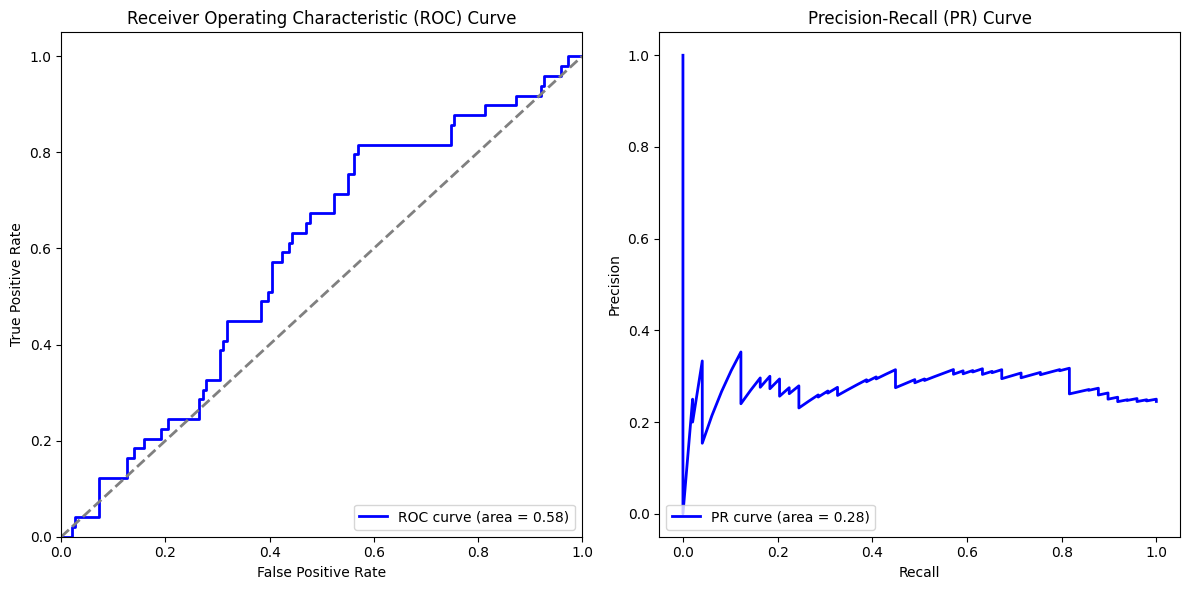

{'depth': 3,
 'l2_leaf_reg': 3263.7998611988314,
 'subsample': 0.6400897521309037,
 'colsample_bylevel': 0.27585733062819695,
 'min_data_in_leaf': 1}

In [846]:
catboost_model = CatBoostClassifier(**study.best_params, iterations=1000, verbose=100, early_stopping_rounds=50, use_best_model = True)
catboost_model.fit(X_train_array, y_train, eval_set=(X_test_array, y_test))

y_pred_proba = catboost_model.predict_proba(X_test_array)[:, 1]

metrics = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.1)
study.best_params

In [847]:
# def custom_early_stopping(model, X_test, y_test, threshold=0.85):
#     for iteration in range(1, model.get_params()['iterations'] + 1):
#         model = CatBoostClassifier(iterations=iteration, verbose=100, early_stopping_rounds=50)
#         model.fit(X_train_array, y_train)
        
#         y_pred_proba = model.predict_proba(X_train_array)[:, 1]
#         roc_auc = roc_auc_score(y_train, y_pred_proba)
        
#         print(f"Iteration: {iteration}, ROC AUC train: {roc_auc}")
        
#         if roc_auc >= threshold:
#             print(f"Early stopping at iteration {iteration} with ROC AUC: {roc_auc}")
#             break

# custom_early_stopping(catboost_model, X_test_array, y_test, threshold=1)

# y_pred_proba = model.predict_proba(X_test_array)[:, 1]
# best_metrics = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.2)

# print(best_metrics)

Лучший порог: 0.10 с F1-score: 0.39
Evaluation Metrics:
Precision: 0.24373956594323873
Recall: 1.0
F1-score: 0.3919463087248322
ROC AUC score: 0.7982098037436873
PR AUC score: 0.5624678819179872
Lift: 1.0 (Max lift: 4.102739726027397 )



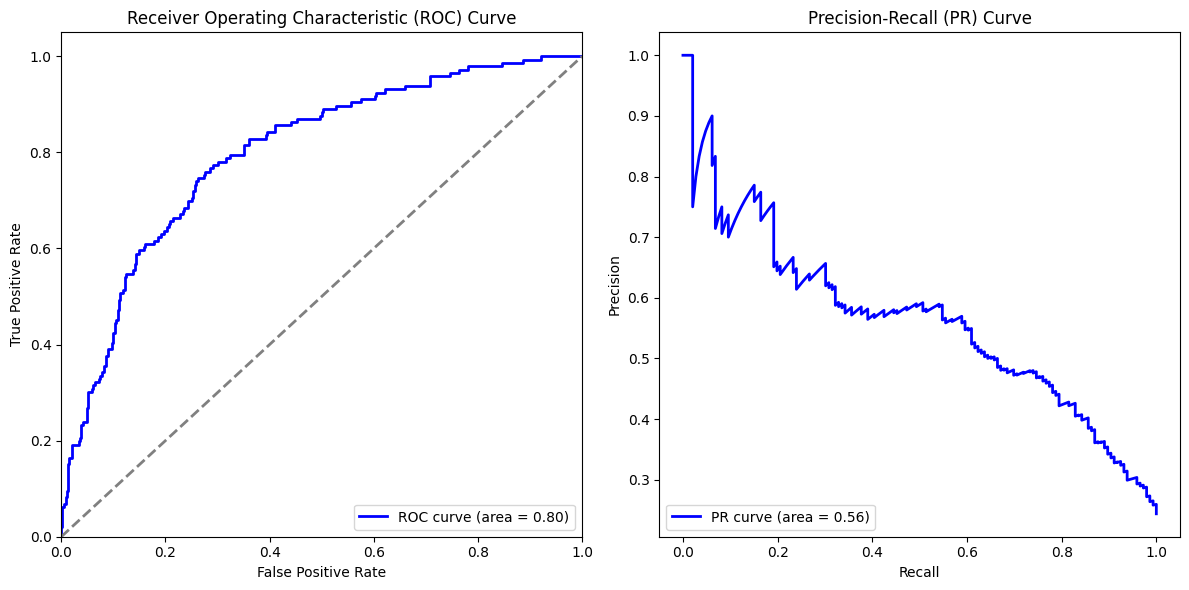

Evaluation Metrics:
Precision: 0.245
Recall: 1.0
F1-score: 0.39357429718875503
ROC AUC score: 0.5833220705500745
PR AUC score: 0.2774277437445908
Lift: 1.0 (Max lift: 4.081632653061225 )



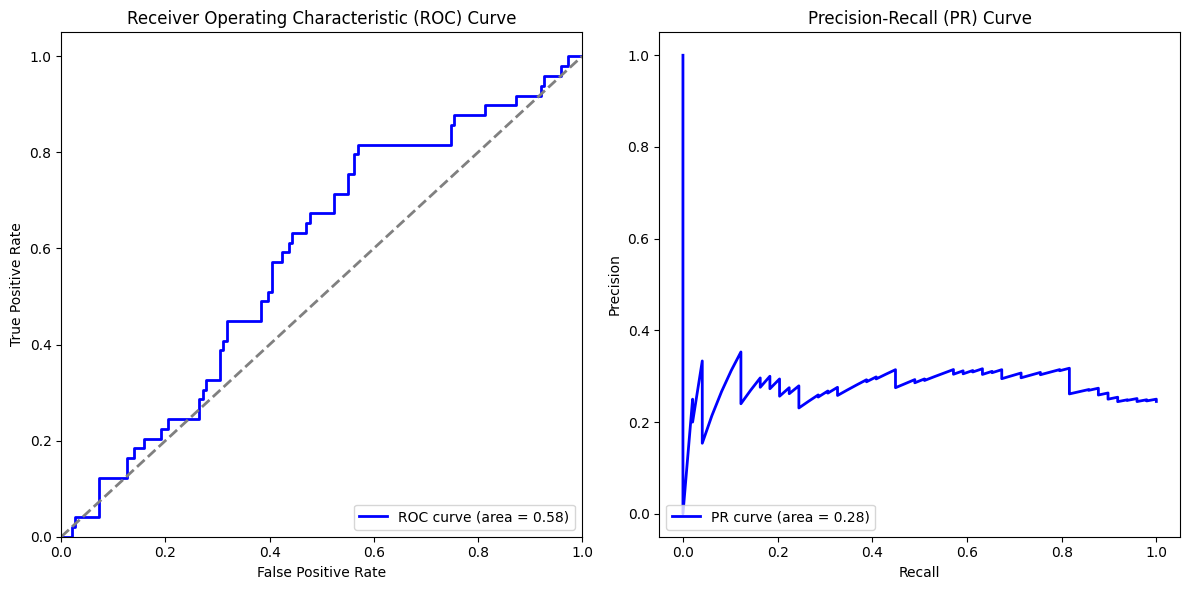

Evaluation Metrics:
Precision: 0.245
Recall: 1.0
F1-score: 0.39357429718875503
ROC AUC score: 0.5833220705500745
PR AUC score: 0.2774277437445908
Lift: 1.0 (Max lift: 4.081632653061225 )



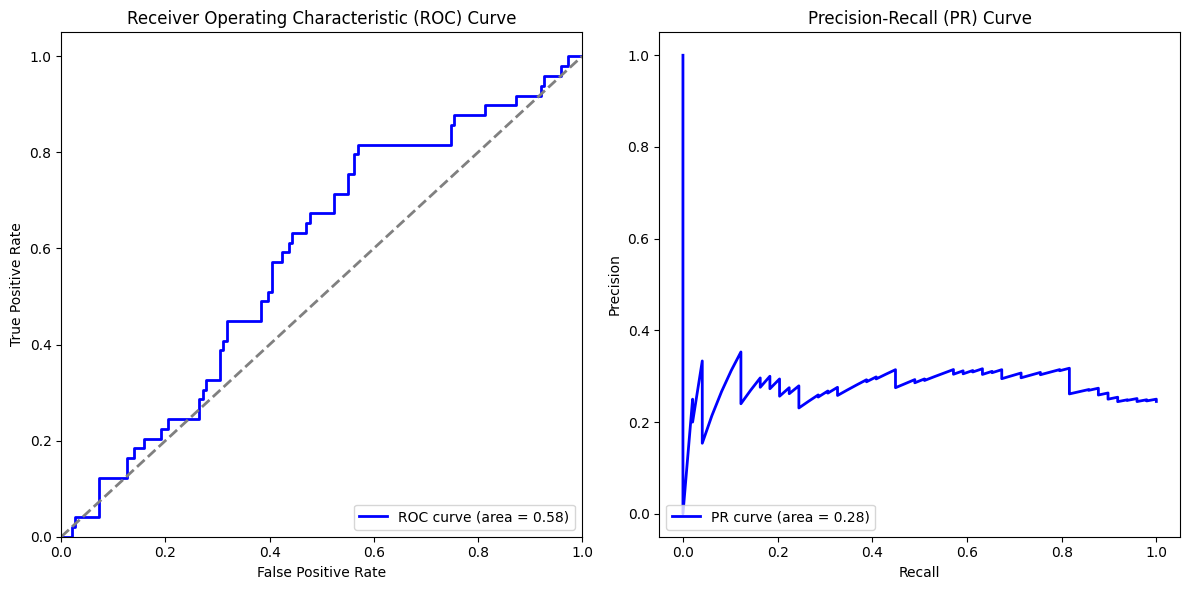

model_name precision recall  f1_score   roc_auc    pr_auc  \
0  tfidf_catboost_optimal_th     0.245    1.0  0.393574  0.583322  0.277428   

  lift  max_lift threshold  
0  1.0  4.081633       0.1

In [848]:
thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    metrics, _ = evaluate_model_predictions(y_test, y_pred_proba, threshold=threshold, visual = False)
    if metrics['f1_score'] > best_f1:
        best_f1 = metrics['f1_score']
        best_threshold = threshold

print(f"Лучший порог: {best_threshold:.2f} с F1-score: {best_f1:.2f}")

#train
y_train_pred_proba = catboost_model.predict_proba(X_train_array)[:, 1]
best_metrics, train_tfidf_catboost_optimal_th = evaluate_model_predictions(y_train, y_train_pred_proba, threshold=best_threshold,
                                          save_metrics_df=metrics_df, model_name = "tfidf_catboost_optimal_th")
#test
y_test_pred_proba = catboost_model.predict_proba(X_test_array)[:, 1]
best_metrics, test_tfidf_catboost_optimal_th = evaluate_model_predictions(y_test, y_test_pred_proba, threshold=best_threshold,
                                          save_metrics_df=metrics_df, model_name = "tfidf_catboost_optimal_th")
#val
y_val_pred_proba = catboost_model.predict_proba(X_val_array)[:, 1]
best_metrics, val_tfidf_catboost_optimal_th = evaluate_model_predictions(y_val, y_val_pred_proba, threshold=best_threshold,
                                          save_metrics_df=metrics_df, model_name = "tfidf_catboost_optimal_th")

val_tfidf_catboost_optimal_th

In [849]:
predictions_df = pd.DataFrame({
    'text': test_data['talks'],
    'predict_proba': y_test_pred_proba,
    'target_client': y_test
})

top_predictions = predictions_df.sort_values(by='predict_proba', ascending=False).head(5)

# Вывод топ 5 диалогов с самыми высокими predict_proba и реальными метками
for index, row in top_predictions.iterrows():
    print(f"Predicted Probability: {row['predict_proba']}")
    print(f"Real Target: {row['target_client']}")
    print(f"Text: {row['text']}\n")

Predicted Probability: 0.35110723146678396
Real Target: 0
Text: добрый день группу самолет меня зовут алина как могу к вам обращаться какой вопрос интересует ипотека правильно поняла что комплекс какой рассматриваете хорошо обращайтесь нам как агенты хорошо тогда сейчас соединю вас азила подальше более подробная консультацию по вашему вопрос вы также подскажите контактный номер телефона у вас заканчивается на ноль четыре два нуля актуален хорошо оставайтесь на линии сейчас соединен добрый день порт какой то определенный срок так как по там ну так как по вариантам средняя именно такая квадратура отдел тридцать шесть квадратка будет двадцать пять он здесь у нас как по вариантам аква ва варианта это два года процент ставка процентов предоставляет банка лир в два года оплата тысяча рублей далее на сосед восемь процентов тридцать девять тридцать да это как не ипотека траншем то есть именно здесь возможность досрочного как погашения будет рассматриваться ипотека трансом у нас на данный момен

In [850]:
feature_importances = catboost_model.get_feature_importance()
feature_names = vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)


In [851]:
importance_df.head(20)

feature  importance
963         вопрос   17.168106
5173         отдел   10.042023
4698         номер    6.316239
4812        обраща    3.177921
6236         получ    1.874060
8718          студ    1.701562
9293          узна    1.697429
8913       телефон    1.460453
4451         наход    1.366930
7267           пят    1.316820
4696           нол    1.235432
1846           дом    1.177513
3897      менеджер    1.123785
7207       процент    0.999333
8392  соответствен    0.927510
5734     планирует    0.814124
7935          связ    0.737641
9463           утр    0.736664
4333           нам    0.732626
1638           дел    0.732265

In [473]:
# top_importance_list = list(importance_df.iloc[:20].feature)
# top_lemmas_df.query("Lemma in @top_importance_list")
# importance_df.head(20).merge(top_lemmas_df.query("Lemma in @top_importance_list"), left_on = 'feature', right_on = 'Lemma', how = 'left')

In [474]:
tokenizer = AutoTokenizer.from_pretrained("sergeyzh/LaBSE-ru-sts")
model = AutoModel.from_pretrained("sergeyzh/LaBSE-ru-sts")

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings.detach().numpy()[0]

tqdm.pandas()
df['embeddings'] = df['talks'].fillna("").progress_apply(get_embeddings)


100%|██████████| 999/999 [08:09<00:00,  2.04it/s]


In [519]:
X_train, X_test, y_train, y_test = train_test_split(df['embeddings'].tolist(), df[target_column], 
                                                    test_size=0.4, random_state=42, stratify=df[target_column])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                    test_size=0.5, random_state=42, stratify=y_test)
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)
X_val_array = np.array(X_val)

In [484]:
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5000),
        'subsample': trial.suggest_float("subsample", 0.05, 1.0),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100), #минимальное количество данных/выборки/количество на лист
    }

    model = CatBoostClassifier(**params, iterations=3000, verbose=100, early_stopping_rounds=50, use_best_model = True, random_seed=42)
    model.fit(X_train_array, y_train, eval_set=(X_test_array, y_test))
    y_pred_proba = model.predict_proba(X_test_array)[:, 1]
    metrics = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.1, visual = False)[0]['pr_auc']
    return metrics

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2024-06-24 03:42:47,615] A new study created in memory with name: no-name-c0ce5f15-e1a0-4ebf-a7e4-b54a7988ece0


0:	learn: 0.6929954	test: 0.6930650	best: 0.6930650 (0)	total: 100ms	remaining: 5m
100:	learn: 0.6765559	test: 0.6822907	best: 0.6822907 (100)	total: 16.1s	remaining: 7m 42s
200:	learn: 0.6620696	test: 0.6732534	best: 0.6732534 (200)	total: 32s	remaining: 7m 25s
300:	learn: 0.6418908	test: 0.6595699	best: 0.6595699 (300)	total: 48.1s	remaining: 7m 11s
400:	learn: 0.6211791	test: 0.6457054	best: 0.6457054 (400)	total: 1m 4s	remaining: 6m 55s
500:	learn: 0.6015139	test: 0.6324876	best: 0.6324876 (500)	total: 1m 20s	remaining: 6m 40s
600:	learn: 0.5873791	test: 0.6238475	best: 0.6238475 (600)	total: 1m 36s	remaining: 6m 24s
700:	learn: 0.5759916	test: 0.6179647	best: 0.6179647 (700)	total: 1m 52s	remaining: 6m 8s
800:	learn: 0.5641556	test: 0.6111494	best: 0.6111494 (800)	total: 2m 8s	remaining: 5m 52s
1500:	learn: 0.5092604	test: 0.5875881	best: 0.5875881 (1500)	total: 4m	remaining: 4m
1600:	learn: 0.5029132	test: 0.5852887	best: 0.5852887 (1600)	total: 4m 16s	remaining: 3m 44s
1700:	lea

[I 2024-06-24 03:50:49,583] Trial 0 finished with value: 0.3785437062920063 and parameters: {'depth': 8, 'l2_leaf_reg': 1431.410535416947, 'subsample': 0.26550888088599295, 'colsample_bylevel': 0.5737490306287467, 'min_data_in_leaf': 72}. Best is trial 0 with value: 0.3785437062920063.


0:	learn: 0.6930448	test: 0.6930752	best: 0.6930752 (0)	total: 27ms	remaining: 1m 21s
100:	learn: 0.6772343	test: 0.6794141	best: 0.6794141 (100)	total: 4.07s	remaining: 1m 56s
200:	learn: 0.6624728	test: 0.6667557	best: 0.6667557 (200)	total: 8.22s	remaining: 1m 54s
300:	learn: 0.6402047	test: 0.6498135	best: 0.6498135 (300)	total: 12.4s	remaining: 1m 51s
400:	learn: 0.6088083	test: 0.6282899	best: 0.6282899 (400)	total: 16.5s	remaining: 1m 47s
500:	learn: 0.5904812	test: 0.6160191	best: 0.6160191 (500)	total: 20.7s	remaining: 1m 43s
600:	learn: 0.5758136	test: 0.6068815	best: 0.6068815 (600)	total: 24.9s	remaining: 1m 39s
700:	learn: 0.5604015	test: 0.5979318	best: 0.5979318 (700)	total: 29s	remaining: 1m 35s
800:	learn: 0.5503366	test: 0.5925211	best: 0.5925211 (800)	total: 33.2s	remaining: 1m 31s
900:	learn: 0.5420577	test: 0.5884800	best: 0.5884800 (900)	total: 37.4s	remaining: 1m 27s
1000:	learn: 0.5325883	test: 0.5836115	best: 0.5836115 (1000)	total: 41.6s	remaining: 1m 23s
1100

[I 2024-06-24 03:52:57,257] Trial 1 finished with value: 0.3681905274998988 and parameters: {'depth': 6, 'l2_leaf_reg': 4903.840227724692, 'subsample': 0.7005882516556201, 'colsample_bylevel': 0.5068853064101428, 'min_data_in_leaf': 40}. Best is trial 0 with value: 0.3785437062920063.


0:	learn: 0.6929485	test: 0.6929939	best: 0.6929939 (0)	total: 6.37ms	remaining: 19.1s
100:	learn: 0.6611291	test: 0.6645531	best: 0.6645531 (100)	total: 701ms	remaining: 20.1s
200:	learn: 0.6381543	test: 0.6442836	best: 0.6442836 (200)	total: 1.35s	remaining: 18.8s
300:	learn: 0.6129831	test: 0.6238615	best: 0.6238615 (300)	total: 2.05s	remaining: 18.4s
400:	learn: 0.5831872	test: 0.6024552	best: 0.6024552 (400)	total: 2.69s	remaining: 17.5s
500:	learn: 0.5673436	test: 0.5920911	best: 0.5920911 (500)	total: 3.39s	remaining: 16.9s
600:	learn: 0.5531550	test: 0.5834109	best: 0.5834109 (600)	total: 4.06s	remaining: 16.2s
700:	learn: 0.5419775	test: 0.5777734	best: 0.5777734 (700)	total: 4.76s	remaining: 15.6s
800:	learn: 0.5330442	test: 0.5730054	best: 0.5730054 (800)	total: 5.44s	remaining: 14.9s
900:	learn: 0.5243287	test: 0.5684636	best: 0.5684636 (900)	total: 6.11s	remaining: 14.2s
1000:	learn: 0.5177501	test: 0.5654476	best: 0.5654476 (1000)	total: 6.77s	remaining: 13.5s
1100:	learn

[I 2024-06-24 03:53:19,862] Trial 2 finished with value: 0.38010518535549187 and parameters: {'depth': 5, 'l2_leaf_reg': 3645.519487212824, 'subsample': 0.46664363244564316, 'colsample_bylevel': 0.10669400177908993, 'min_data_in_leaf': 40}. Best is trial 2 with value: 0.38010518535549187.


0:	learn: 0.6929173	test: 0.6929820	best: 0.6929820 (0)	total: 94.2ms	remaining: 4m 42s
100:	learn: 0.6653442	test: 0.6742906	best: 0.6742906 (100)	total: 15.9s	remaining: 7m 35s
200:	learn: 0.6432737	test: 0.6599936	best: 0.6599936 (200)	total: 31.6s	remaining: 7m 20s
300:	learn: 0.6185517	test: 0.6438811	best: 0.6438811 (300)	total: 47.3s	remaining: 7m 4s
400:	learn: 0.5965943	test: 0.6300752	best: 0.6300752 (400)	total: 1m 2s	remaining: 6m 48s
500:	learn: 0.5810598	test: 0.6218314	best: 0.6218314 (500)	total: 1m 18s	remaining: 6m 31s
600:	learn: 0.5644339	test: 0.6122728	best: 0.6122728 (600)	total: 1m 34s	remaining: 6m 15s
700:	learn: 0.5510238	test: 0.6059324	best: 0.6059324 (700)	total: 1m 49s	remaining: 5m 59s
800:	learn: 0.5390449	test: 0.6004671	best: 0.6004671 (800)	total: 2m 5s	remaining: 5m 43s
900:	learn: 0.5272289	test: 0.5951114	best: 0.5951114 (900)	total: 2m 20s	remaining: 5m 27s
1000:	learn: 0.5166985	test: 0.5905718	best: 0.5905718 (1000)	total: 2m 35s	remaining: 5m 

[I 2024-06-24 04:01:10,241] Trial 3 finished with value: 0.3766940441307044 and parameters: {'depth': 8, 'l2_leaf_reg': 913.2761605370464, 'subsample': 0.2166791683401179, 'colsample_bylevel': 0.5549738051497465, 'min_data_in_leaf': 54}. Best is trial 2 with value: 0.38010518535549187.


0:	learn: 0.6931100	test: 0.6931326	best: 0.6931326 (0)	total: 103ms	remaining: 5m 9s
100:	learn: 0.6864941	test: 0.6887003	best: 0.6887003 (100)	total: 17.2s	remaining: 8m 13s
200:	learn: 0.6789048	test: 0.6833755	best: 0.6833755 (200)	total: 34.2s	remaining: 7m 56s
300:	learn: 0.6678952	test: 0.6760004	best: 0.6760004 (300)	total: 51.2s	remaining: 7m 39s
400:	learn: 0.6367259	test: 0.6544741	best: 0.6544741 (400)	total: 1m 8s	remaining: 7m 22s
500:	learn: 0.6181777	test: 0.6422909	best: 0.6422909 (500)	total: 1m 25s	remaining: 7m 5s
600:	learn: 0.6060318	test: 0.6349002	best: 0.6349002 (600)	total: 1m 42s	remaining: 6m 48s
700:	learn: 0.5929486	test: 0.6272801	best: 0.6272801 (700)	total: 1m 59s	remaining: 6m 30s
800:	learn: 0.5817044	test: 0.6210217	best: 0.6210217 (800)	total: 2m 16s	remaining: 6m 13s
900:	learn: 0.5740478	test: 0.6170483	best: 0.6170483 (900)	total: 2m 33s	remaining: 5m 57s
1000:	learn: 0.5651494	test: 0.6124440	best: 0.6124440 (1000)	total: 2m 50s	remaining: 5m 4

[I 2024-06-24 04:09:44,194] Trial 4 finished with value: 0.35424460528367174 and parameters: {'depth': 8, 'l2_leaf_reg': 4247.30953859487, 'subsample': 0.7382325586176035, 'colsample_bylevel': 0.6304723351437037, 'min_data_in_leaf': 73}. Best is trial 2 with value: 0.38010518535549187.


0:	learn: 0.6913753	test: 0.6914238	best: 0.6914238 (0)	total: 12.4ms	remaining: 37.3s
100:	learn: 0.6417394	test: 0.6466738	best: 0.6466738 (100)	total: 1.69s	remaining: 48.6s
200:	learn: 0.6069739	test: 0.6173105	best: 0.6173105 (200)	total: 3.36s	remaining: 46.8s
300:	learn: 0.5797434	test: 0.5968593	best: 0.5968593 (300)	total: 5.03s	remaining: 45.1s
400:	learn: 0.5609180	test: 0.5846268	best: 0.5846268 (400)	total: 6.67s	remaining: 43.3s
500:	learn: 0.5457196	test: 0.5751906	best: 0.5751906 (500)	total: 8.32s	remaining: 41.5s
600:	learn: 0.5338265	test: 0.5689812	best: 0.5689812 (600)	total: 9.98s	remaining: 39.8s
700:	learn: 0.5237012	test: 0.5640751	best: 0.5640751 (700)	total: 11.7s	remaining: 38.2s
800:	learn: 0.5147655	test: 0.5601099	best: 0.5601099 (800)	total: 13.3s	remaining: 36.5s
900:	learn: 0.5061142	test: 0.5565636	best: 0.5565636 (900)	total: 15s	remaining: 34.9s
1000:	learn: 0.4986265	test: 0.5544473	best: 0.5544473 (1000)	total: 16.6s	remaining: 33.2s
1100:	learn: 

[I 2024-06-24 04:10:24,487] Trial 5 finished with value: 0.3913454704866466 and parameters: {'depth': 5, 'l2_leaf_reg': 1809.5814894559483, 'subsample': 0.2668500693350078, 'colsample_bylevel': 0.32902834406938786, 'min_data_in_leaf': 64}. Best is trial 5 with value: 0.3913454704866466.


0:	learn: 0.6908315	test: 0.6909998	best: 0.6909998 (0)	total: 7.09ms	remaining: 21.3s
100:	learn: 0.6049356	test: 0.6119060	best: 0.6119060 (100)	total: 730ms	remaining: 20.9s
200:	learn: 0.5643604	test: 0.5764613	best: 0.5764613 (200)	total: 1.39s	remaining: 19.4s
300:	learn: 0.5397751	test: 0.5610176	best: 0.5610176 (300)	total: 2.11s	remaining: 18.9s
400:	learn: 0.5222177	test: 0.5527831	best: 0.5527831 (400)	total: 2.78s	remaining: 18s
500:	learn: 0.5093600	test: 0.5486642	best: 0.5486642 (500)	total: 3.47s	remaining: 17.3s
600:	learn: 0.4981604	test: 0.5463403	best: 0.5463403 (600)	total: 4.16s	remaining: 16.6s
700:	learn: 0.4882705	test: 0.5451862	best: 0.5451810 (699)	total: 4.89s	remaining: 16.1s
800:	learn: 0.4796991	test: 0.5439479	best: 0.5439294 (797)	total: 5.56s	remaining: 15.3s
900:	learn: 0.4718268	test: 0.5428365	best: 0.5428365 (900)	total: 6.26s	remaining: 14.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5427932753
bestIteration = 905

Shrin

[I 2024-06-24 04:10:32,035] Trial 6 finished with value: 0.36629525480366265 and parameters: {'depth': 3, 'l2_leaf_reg': 2169.0721622249616, 'subsample': 0.45931962516316155, 'colsample_bylevel': 0.5190008427677909, 'min_data_in_leaf': 43}. Best is trial 5 with value: 0.3913454704866466.


0:	learn: 0.6926946	test: 0.6927693	best: 0.6927693 (0)	total: 25ms	remaining: 1m 15s
100:	learn: 0.6398972	test: 0.6457659	best: 0.6457659 (100)	total: 2.75s	remaining: 1m 19s
200:	learn: 0.6034775	test: 0.6148433	best: 0.6148433 (200)	total: 5.48s	remaining: 1m 16s
300:	learn: 0.5699526	test: 0.5937259	best: 0.5937259 (300)	total: 8.23s	remaining: 1m 13s
400:	learn: 0.5407969	test: 0.5796992	best: 0.5796992 (400)	total: 10.9s	remaining: 1m 10s
500:	learn: 0.5188032	test: 0.5705998	best: 0.5705998 (500)	total: 13.6s	remaining: 1m 8s
600:	learn: 0.5010802	test: 0.5641739	best: 0.5641739 (600)	total: 16.3s	remaining: 1m 5s
700:	learn: 0.4870142	test: 0.5604237	best: 0.5604237 (700)	total: 19.1s	remaining: 1m 2s
800:	learn: 0.4738506	test: 0.5569880	best: 0.5569880 (800)	total: 21.8s	remaining: 59.7s
900:	learn: 0.4620552	test: 0.5541393	best: 0.5541025 (899)	total: 24.5s	remaining: 57.1s
1000:	learn: 0.4514787	test: 0.5527571	best: 0.5527571 (1000)	total: 27.2s	remaining: 54.4s
1100:	le

[I 2024-06-24 04:11:26,366] Trial 7 finished with value: 0.3313052558897018 and parameters: {'depth': 5, 'l2_leaf_reg': 2132.3301835070783, 'subsample': 0.8987197049612781, 'colsample_bylevel': 0.9469520172936856, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.3913454704866466.


0:	learn: 0.6923587	test: 0.6925389	best: 0.6925389 (0)	total: 40.6ms	remaining: 2m 1s
100:	learn: 0.6338168	test: 0.6488850	best: 0.6488850 (100)	total: 6.61s	remaining: 3m 9s
200:	learn: 0.5939227	test: 0.6223263	best: 0.6223263 (200)	total: 13.3s	remaining: 3m 5s
300:	learn: 0.5617971	test: 0.6045234	best: 0.6045234 (300)	total: 20s	remaining: 2m 59s
400:	learn: 0.5325018	test: 0.5892288	best: 0.5892288 (400)	total: 27.2s	remaining: 2m 56s
500:	learn: 0.5091747	test: 0.5793356	best: 0.5793356 (500)	total: 34.2s	remaining: 2m 50s
600:	learn: 0.4892775	test: 0.5721355	best: 0.5721355 (600)	total: 41.2s	remaining: 2m 44s
700:	learn: 0.4721853	test: 0.5666735	best: 0.5666735 (700)	total: 48.3s	remaining: 2m 38s
800:	learn: 0.4563919	test: 0.5625814	best: 0.5625814 (800)	total: 55.5s	remaining: 2m 32s
900:	learn: 0.4421860	test: 0.5592723	best: 0.5592576 (898)	total: 1m 2s	remaining: 2m 25s
1000:	learn: 0.4286559	test: 0.5563241	best: 0.5563241 (1000)	total: 1m 9s	remaining: 2m 18s
1100:

[I 2024-06-24 04:13:58,485] Trial 8 finished with value: 0.36421275458739716 and parameters: {'depth': 7, 'l2_leaf_reg': 578.9763570013993, 'subsample': 0.35142120772930485, 'colsample_bylevel': 0.4440849013559502, 'min_data_in_leaf': 87}. Best is trial 5 with value: 0.3913454704866466.


0:	learn: 0.6926816	test: 0.6926820	best: 0.6926820 (0)	total: 17.6ms	remaining: 52.8s
100:	learn: 0.6488102	test: 0.6533208	best: 0.6533208 (100)	total: 2.4s	remaining: 1m 8s
200:	learn: 0.6138174	test: 0.6229387	best: 0.6229387 (200)	total: 4.8s	remaining: 1m 6s
300:	learn: 0.5822842	test: 0.6010295	best: 0.6010295 (300)	total: 7.17s	remaining: 1m 4s
400:	learn: 0.5496099	test: 0.5828905	best: 0.5828905 (400)	total: 9.54s	remaining: 1m 1s
500:	learn: 0.5287086	test: 0.5730037	best: 0.5730037 (500)	total: 11.9s	remaining: 59.6s
600:	learn: 0.5107905	test: 0.5657621	best: 0.5657621 (600)	total: 14.3s	remaining: 57.2s
700:	learn: 0.4970375	test: 0.5609673	best: 0.5609673 (700)	total: 16.7s	remaining: 54.8s
800:	learn: 0.4841599	test: 0.5570558	best: 0.5570385 (799)	total: 19.1s	remaining: 52.4s
900:	learn: 0.4733277	test: 0.5543349	best: 0.5543349 (900)	total: 21.4s	remaining: 50s
1000:	learn: 0.4629464	test: 0.5522811	best: 0.5522811 (1000)	total: 23.8s	remaining: 47.5s
1100:	learn: 0.

[I 2024-06-24 04:14:51,775] Trial 9 finished with value: 0.3327744024529138 and parameters: {'depth': 5, 'l2_leaf_reg': 2415.688287049259, 'subsample': 0.9862817963301698, 'colsample_bylevel': 0.5435108632968189, 'min_data_in_leaf': 62}. Best is trial 5 with value: 0.3913454704866466.


0:	learn: 0.6921565	test: 0.6928888	best: 0.6928888 (0)	total: 45ms	remaining: 2m 14s
100:	learn: 0.5709699	test: 0.6297132	best: 0.6297132 (100)	total: 4.25s	remaining: 2m 1s
200:	learn: 0.4936709	test: 0.5980339	best: 0.5980339 (200)	total: 8.46s	remaining: 1m 57s
300:	learn: 0.4330063	test: 0.5734163	best: 0.5734163 (300)	total: 12.6s	remaining: 1m 53s
400:	learn: 0.3880923	test: 0.5607434	best: 0.5607434 (400)	total: 16.8s	remaining: 1m 48s
500:	learn: 0.3522864	test: 0.5528366	best: 0.5528366 (500)	total: 21s	remaining: 1m 44s
600:	learn: 0.3216612	test: 0.5471847	best: 0.5471847 (600)	total: 25.3s	remaining: 1m 40s
700:	learn: 0.2948186	test: 0.5449888	best: 0.5446371 (674)	total: 29.4s	remaining: 1m 36s
800:	learn: 0.2714705	test: 0.5433304	best: 0.5432613 (797)	total: 33.5s	remaining: 1m 31s
900:	learn: 0.2514381	test: 0.5427130	best: 0.5426550 (897)	total: 37.7s	remaining: 1m 27s
1000:	learn: 0.2335708	test: 0.5413486	best: 0.5410622 (992)	total: 41.8s	remaining: 1m 23s
1100:	

[I 2024-06-24 04:15:47,434] Trial 10 finished with value: 0.4023651284526998 and parameters: {'depth': 10, 'l2_leaf_reg': 99.04152681159394, 'subsample': 0.10596293205233581, 'colsample_bylevel': 0.17262365671126978, 'min_data_in_leaf': 11}. Best is trial 10 with value: 0.4023651284526998.


0:	learn: 0.6883350	test: 0.6916372	best: 0.6916372 (0)	total: 49.9ms	remaining: 2m 29s
100:	learn: 0.3913307	test: 0.5720561	best: 0.5720561 (100)	total: 4.23s	remaining: 2m 1s
200:	learn: 0.2758417	test: 0.5455683	best: 0.5455683 (200)	total: 8.43s	remaining: 1m 57s
300:	learn: 0.2104133	test: 0.5381807	best: 0.5356238 (255)	total: 12.7s	remaining: 1m 54s


[I 2024-06-24 04:16:00,876] Trial 11 finished with value: 0.4141932861159321 and parameters: {'depth': 10, 'l2_leaf_reg': 20.186883024539384, 'subsample': 0.169480655300783, 'colsample_bylevel': 0.178422461982709, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.4141932861159321.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.535623801
bestIteration = 255

Shrink model to first 256 iterations.
0:	learn: 0.6907109	test: 0.6917454	best: 0.6917454 (0)	total: 14.5ms	remaining: 43.6s
100:	learn: 0.5077654	test: 0.5879222	best: 0.5879222 (100)	total: 1.56s	remaining: 44.9s
200:	learn: 0.4214968	test: 0.5571854	best: 0.5571331 (197)	total: 3.13s	remaining: 43.7s
300:	learn: 0.3629907	test: 0.5461193	best: 0.5461193 (300)	total: 4.69s	remaining: 42.1s
400:	learn: 0.3174491	test: 0.5425578	best: 0.5425578 (400)	total: 6.25s	remaining: 40.5s
500:	learn: 0.2810159	test: 0.5402075	best: 0.5400966 (487)	total: 7.78s	remaining: 38.8s


[I 2024-06-24 04:16:10,037] Trial 12 finished with value: 0.35769927175029437 and parameters: {'depth': 10, 'l2_leaf_reg': 56.54780531884928, 'subsample': 0.0684164634135255, 'colsample_bylevel': 0.05216027284318686, 'min_data_in_leaf': 2}. Best is trial 11 with value: 0.4141932861159321.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5399928466
bestIteration = 501

Shrink model to first 502 iterations.
0:	learn: 0.6912467	test: 0.6922455	best: 0.6922455 (0)	total: 54.6ms	remaining: 2m 43s
100:	learn: 0.5312900	test: 0.5962138	best: 0.5962138 (100)	total: 5.52s	remaining: 2m 38s
200:	learn: 0.4494033	test: 0.5581774	best: 0.5581774 (200)	total: 10.9s	remaining: 2m 31s
300:	learn: 0.3983077	test: 0.5470423	best: 0.5470423 (300)	total: 16.3s	remaining: 2m 26s
400:	learn: 0.3567334	test: 0.5422594	best: 0.5422594 (400)	total: 21.8s	remaining: 2m 21s
500:	learn: 0.3226515	test: 0.5387165	best: 0.5385696 (499)	total: 27.2s	remaining: 2m 15s


[I 2024-06-24 04:16:42,938] Trial 13 finished with value: 0.3858547921481198 and parameters: {'depth': 10, 'l2_leaf_reg': 77.61112511143756, 'subsample': 0.06563945847721842, 'colsample_bylevel': 0.2337586059355799, 'min_data_in_leaf': 2}. Best is trial 11 with value: 0.4141932861159321.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5372375897
bestIteration = 543

Shrink model to first 544 iterations.
0:	learn: 0.6930414	test: 0.6931293	best: 0.6931293 (0)	total: 52.2ms	remaining: 2m 36s
100:	learn: 0.6802112	test: 0.6876278	best: 0.6876278 (100)	total: 5.33s	remaining: 2m 32s
200:	learn: 0.6675632	test: 0.6820166	best: 0.6820166 (200)	total: 10.5s	remaining: 2m 26s
300:	learn: 0.6540058	test: 0.6756999	best: 0.6756999 (300)	total: 15.8s	remaining: 2m 21s
400:	learn: 0.6398388	test: 0.6684682	best: 0.6684682 (400)	total: 21s	remaining: 2m 16s
500:	learn: 0.6273269	test: 0.6622862	best: 0.6622862 (500)	total: 26.3s	remaining: 2m 11s
600:	learn: 0.6137381	test: 0.6551082	best: 0.6551082 (600)	total: 31.5s	remaining: 2m 5s
700:	learn: 0.6025951	test: 0.6503159	best: 0.6503159 (700)	total: 36.7s	remaining: 2m
800:	learn: 0.5925041	test: 0.6461867	best: 0.6461867 (800)	total: 42s	remaining: 1m 55s
900:	learn: 0.5831896	test: 0.6425339	best: 0.6425339 (

[I 2024-06-24 04:19:23,536] Trial 14 finished with value: 0.3797902648525636 and parameters: {'depth': 10, 'l2_leaf_reg': 1004.3950057231252, 'subsample': 0.17484677094403067, 'colsample_bylevel': 0.2254352185120271, 'min_data_in_leaf': 22}. Best is trial 11 with value: 0.4141932861159321.


0:	learn: 0.6930834	test: 0.6931062	best: 0.6931062 (0)	total: 225ms	remaining: 11m 14s
100:	learn: 0.6873138	test: 0.6899647	best: 0.6899647 (100)	total: 37.7s	remaining: 18m 2s
200:	learn: 0.6813891	test: 0.6865326	best: 0.6865326 (200)	total: 1m 15s	remaining: 17m 36s
300:	learn: 0.6734411	test: 0.6819212	best: 0.6819212 (300)	total: 1m 53s	remaining: 17m
400:	learn: 0.6521690	test: 0.6682021	best: 0.6682021 (400)	total: 2m 31s	remaining: 16m 24s
500:	learn: 0.6350456	test: 0.6562585	best: 0.6562585 (500)	total: 3m 9s	remaining: 15m 45s
600:	learn: 0.6211370	test: 0.6471090	best: 0.6471090 (600)	total: 3m 47s	remaining: 15m 8s
700:	learn: 0.6086398	test: 0.6396608	best: 0.6396608 (700)	total: 4m 26s	remaining: 14m 32s
800:	learn: 0.5980616	test: 0.6337014	best: 0.6337014 (800)	total: 5m 4s	remaining: 13m 54s
900:	learn: 0.5899684	test: 0.6294077	best: 0.6294077 (900)	total: 5m 42s	remaining: 13m 17s
1000:	learn: 0.5827636	test: 0.6259561	best: 0.6259561 (1000)	total: 6m 20s	remainin

[I 2024-06-24 04:38:29,357] Trial 15 finished with value: 0.3592904989688719 and parameters: {'depth': 9, 'l2_leaf_reg': 3257.8174696968167, 'subsample': 0.6011598873698475, 'colsample_bylevel': 0.7988651137632168, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.4141932861159321.


0:	learn: 0.6928402	test: 0.6929898	best: 0.6929898 (0)	total: 120ms	remaining: 5m 58s
100:	learn: 0.6636435	test: 0.6774215	best: 0.6774215 (100)	total: 21.6s	remaining: 10m 18s
200:	learn: 0.6388245	test: 0.6648164	best: 0.6648164 (200)	total: 43s	remaining: 9m 58s
300:	learn: 0.6098036	test: 0.6492066	best: 0.6492066 (300)	total: 1m 4s	remaining: 9m 41s
400:	learn: 0.5823012	test: 0.6345469	best: 0.6345469 (400)	total: 1m 26s	remaining: 9m 19s
500:	learn: 0.5560355	test: 0.6220953	best: 0.6220839 (499)	total: 1m 48s	remaining: 8m 59s
600:	learn: 0.5381501	test: 0.6148496	best: 0.6148496 (600)	total: 2m 9s	remaining: 8m 37s
700:	learn: 0.5214043	test: 0.6087180	best: 0.6087180 (700)	total: 2m 31s	remaining: 8m 15s
800:	learn: 0.5063696	test: 0.6034747	best: 0.6034747 (800)	total: 2m 52s	remaining: 7m 53s
900:	learn: 0.4886861	test: 0.5962428	best: 0.5962428 (900)	total: 3m 14s	remaining: 7m 32s
1000:	learn: 0.4744206	test: 0.5916610	best: 0.5916610 (1000)	total: 3m 35s	remaining: 7m 

[I 2024-06-24 04:49:19,745] Trial 16 finished with value: 0.3848256769424416 and parameters: {'depth': 9, 'l2_leaf_reg': 579.313057425107, 'subsample': 0.3721766066868233, 'colsample_bylevel': 0.360374625057731, 'min_data_in_leaf': 22}. Best is trial 11 with value: 0.4141932861159321.


0:	learn: 0.6931086	test: 0.6931327	best: 0.6931327 (0)	total: 73.4ms	remaining: 3m 40s
100:	learn: 0.6866240	test: 0.6892727	best: 0.6892727 (100)	total: 13.6s	remaining: 6m 29s
200:	learn: 0.6805775	test: 0.6856846	best: 0.6856846 (200)	total: 27.2s	remaining: 6m 18s
300:	learn: 0.6735924	test: 0.6811965	best: 0.6811965 (300)	total: 41s	remaining: 6m 7s
400:	learn: 0.6660512	test: 0.6760932	best: 0.6760932 (400)	total: 54.8s	remaining: 5m 55s
500:	learn: 0.6587547	test: 0.6712121	best: 0.6712121 (500)	total: 1m 8s	remaining: 5m 41s
600:	learn: 0.6524291	test: 0.6671986	best: 0.6671986 (600)	total: 1m 22s	remaining: 5m 28s
700:	learn: 0.6455730	test: 0.6628002	best: 0.6628002 (700)	total: 1m 35s	remaining: 5m 14s
800:	learn: 0.6392027	test: 0.6587240	best: 0.6587240 (800)	total: 1m 49s	remaining: 5m
900:	learn: 0.6336062	test: 0.6552867	best: 0.6552867 (900)	total: 2m 3s	remaining: 4m 46s
1000:	learn: 0.6281154	test: 0.6518652	best: 0.6518652 (1000)	total: 2m 16s	remaining: 4m 33s
110

[I 2024-06-24 04:56:12,475] Trial 17 finished with value: 0.36563596389281383 and parameters: {'depth': 9, 'l2_leaf_reg': 3041.5372318722007, 'subsample': 0.13719251582875555, 'colsample_bylevel': 0.21101221985073237, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.4141932861159321.


0:	learn: 0.6914281	test: 0.6916088	best: 0.6916088 (0)	total: 3.25ms	remaining: 9.76s
100:	learn: 0.5829120	test: 0.5906147	best: 0.5906147 (100)	total: 301ms	remaining: 8.64s
200:	learn: 0.5470662	test: 0.5619190	best: 0.5619190 (200)	total: 612ms	remaining: 8.53s
300:	learn: 0.5283344	test: 0.5522184	best: 0.5522184 (300)	total: 908ms	remaining: 8.14s
400:	learn: 0.5144917	test: 0.5464221	best: 0.5464221 (400)	total: 1.2s	remaining: 7.77s
500:	learn: 0.5030163	test: 0.5436789	best: 0.5436480 (497)	total: 1.49s	remaining: 7.44s
600:	learn: 0.4924940	test: 0.5424772	best: 0.5424367 (570)	total: 1.79s	remaining: 7.17s
700:	learn: 0.4826919	test: 0.5414169	best: 0.5412861 (677)	total: 2.11s	remaining: 6.91s
800:	learn: 0.4738837	test: 0.5408868	best: 0.5407773 (792)	total: 2.39s	remaining: 6.57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5407773139
bestIteration = 792

Shrink model to first 793 iterations.


[I 2024-06-24 04:56:15,680] Trial 18 finished with value: 0.38827372701065976 and parameters: {'depth': 3, 'l2_leaf_reg': 1393.8970150382427, 'subsample': 0.3544502984588007, 'colsample_bylevel': 0.141134057689275, 'min_data_in_leaf': 30}. Best is trial 11 with value: 0.4141932861159321.


0:	learn: 0.6917505	test: 0.6918282	best: 0.6918282 (0)	total: 33.5ms	remaining: 1m 40s
100:	learn: 0.6007577	test: 0.6153726	best: 0.6153726 (100)	total: 5.75s	remaining: 2m 45s
200:	learn: 0.5559876	test: 0.5813248	best: 0.5813248 (200)	total: 11.5s	remaining: 2m 39s
300:	learn: 0.5280403	test: 0.5647206	best: 0.5647206 (300)	total: 17.1s	remaining: 2m 33s
400:	learn: 0.5099651	test: 0.5580655	best: 0.5580355 (397)	total: 22.8s	remaining: 2m 27s
500:	learn: 0.4953550	test: 0.5542255	best: 0.5542047 (499)	total: 28.6s	remaining: 2m 22s
600:	learn: 0.4823937	test: 0.5514546	best: 0.5514546 (600)	total: 34.4s	remaining: 2m 17s
700:	learn: 0.4703594	test: 0.5492609	best: 0.5492609 (700)	total: 40.1s	remaining: 2m 11s
800:	learn: 0.4587777	test: 0.5481264	best: 0.5480929 (798)	total: 45.8s	remaining: 2m 5s
900:	learn: 0.4478305	test: 0.5460105	best: 0.5460105 (900)	total: 51.6s	remaining: 2m
1000:	learn: 0.4377592	test: 0.5446152	best: 0.5445165 (997)	total: 57.4s	remaining: 1m 54s
1100:	

[I 2024-06-24 04:57:22,545] Trial 19 finished with value: 0.3922689060772176 and parameters: {'depth': 7, 'l2_leaf_reg': 404.9219970471289, 'subsample': 0.05586153583525255, 'colsample_bylevel': 0.35100482865245164, 'min_data_in_leaf': 31}. Best is trial 11 with value: 0.4141932861159321.


Learning rate set to 0.279822
0:	learn: 0.6096375	test: 0.6302033	best: 0.6302033 (0)	total: 39.2ms	remaining: 157ms
4:	learn: 0.4242209	test: 0.5775720	best: 0.5775720 (4)	total: 149ms	remaining: 0us

bestTest = 0.5775720019
bestIteration = 4

Train accuracy: 0.8113522537562604
Test accuracy: 0.735
Лучший порог: 0.20 с F1-score: 0.40
Evaluation Metrics:
Precision: 0.3444976076555024
Recall: 0.9863013698630136
F1-score: 0.5106382978723404
ROC AUC score: 0.9152680758414226
PR AUC score: 0.833807647655556
Lift: 1.4133840204496297 (Max lift: 4.102739726027397 )



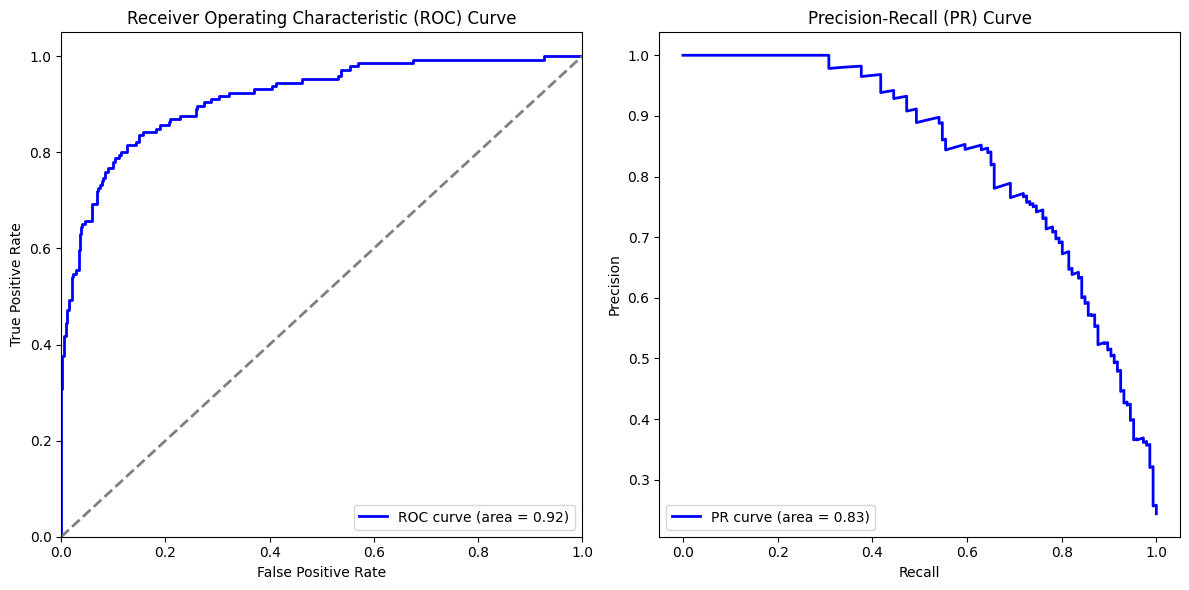

Evaluation Metrics:
Precision: 0.25595238095238093
Recall: 0.8775510204081632
F1-score: 0.39631336405529954
ROC AUC score: 0.5491282605757536
PR AUC score: 0.2554131360865979
Lift: 1.044703595724004 (Max lift: 4.081632653061225 )



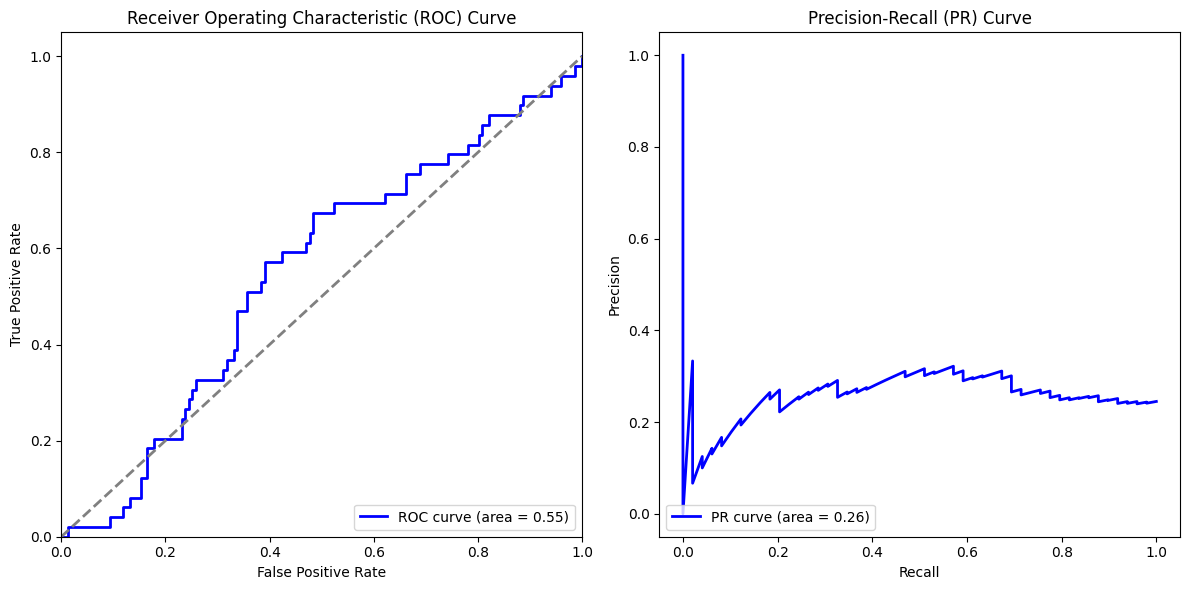

Evaluation Metrics:
Precision: 0.25
Recall: 0.7142857142857143
F1-score: 0.37037037037037035
ROC AUC score: 0.5800783889714827
PR AUC score: 0.32389026554781364
Lift: 1.0204081632653061 (Max lift: 4.081632653061225 )



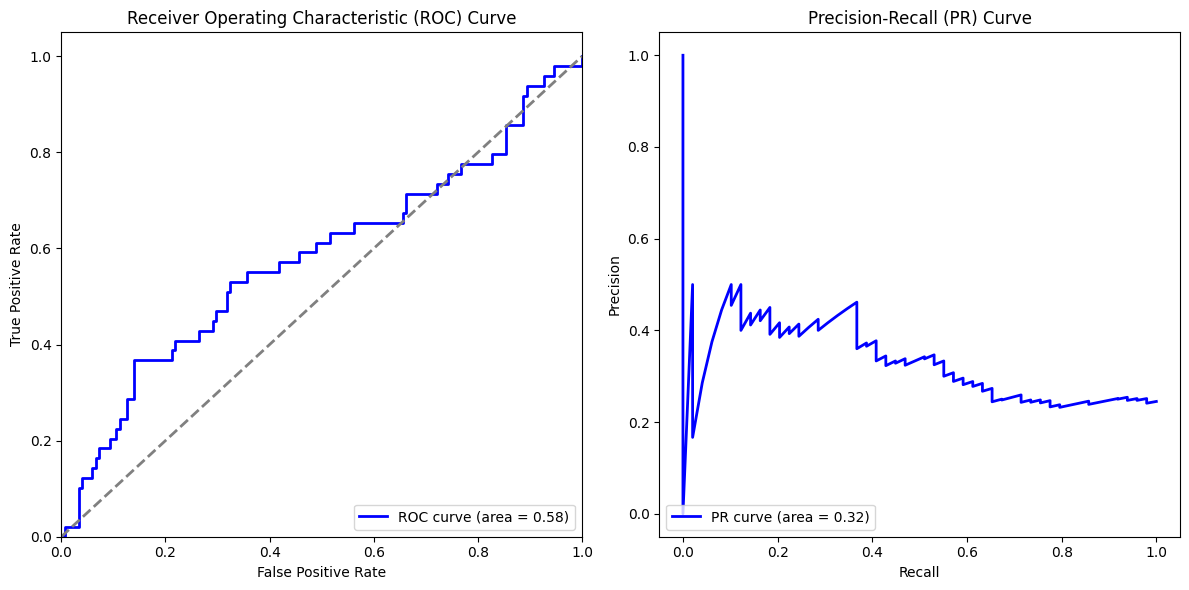

model_name precision    recall  f1_score   roc_auc  \
0  tfidf_catboost_optimal_th  0.352941  0.122449  0.181818  0.583322   
0             LaBSE_catboost      0.25  0.714286   0.37037  0.580078   

     pr_auc      lift  max_lift threshold  
0  0.277428  1.440576  4.081633       0.3  
0   0.32389  1.020408  4.081633       0.2

In [529]:
model = CatBoostClassifier(#**study.best_params,
                           iterations=5,
                           verbose=100,
                           early_stopping_rounds=50,
                           random_seed=42,
                           use_best_model = True
                          )

model.fit(X_train_array, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

train_score = model.score(X_train_array, y_train)
test_score = model.score(X_test_array, y_test)
print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

y_pred_proba = model.predict_proba(X_test_array)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    metrics, _ = evaluate_model_predictions(y_test, y_pred_proba, threshold=threshold, visual = False)
    if metrics['f1_score'] > best_f1:
        best_f1 = metrics['f1_score']
        best_threshold = threshold

print(f"Лучший порог: {best_threshold:.2f} с F1-score: {best_f1:.2f}")

#train
y_train_pred_proba = model.predict_proba(X_train_array)[:, 1]
best_metrics, train_labse_catboost = evaluate_model_predictions(y_train, y_train_pred_proba, threshold=best_threshold,
                                          save_metrics_df=train_tfidf_catboost_optimal_th
                                          , model_name = "LaBSE_catboost")
#test
y_test_pred_proba = model.predict_proba(X_test_array)[:, 1]
best_metrics, test_labse_catboost = evaluate_model_predictions(y_test, y_test_pred_proba, threshold=best_threshold,
                                          save_metrics_df=test_tfidf_catboost_optimal_th
                                          , model_name = "LaBSE_catboost")
#val
y_val_pred_proba = model.predict_proba(X_val_array)[:, 1]
best_metrics, val_labse_catboost = evaluate_model_predictions(y_val, y_val_pred_proba, threshold=best_threshold,
                                          save_metrics_df=val_tfidf_catboost_optimal_th
                                         , model_name = "LaBSE_catboost")

val_labse_catboost

### Модель с использованием фичей

In [764]:
df_features = df[['target', 'target_client', 'has_discount', 'discount_mentions',
    'first_discount_location', 'last_discount_location', 
    'word_ngrams_similarity', 'disc_numr', 'dialog_length']]
df_features.first_discount_location = df_features.first_discount_location.fillna(0)
df_features.last_discount_location = df_features.last_discount_location.fillna(0)
df_features.word_ngrams_similarity = df_features.word_ngrams_similarity.fillna(0)
df_features.disc_numr = df_features.disc_numr.fillna('ноль')

In [765]:
features = ['has_discount', 'discount_mentions',
    'first_discount_location', 'last_discount_location', 
    'word_ngrams_similarity', 'disc_numr', 'dialog_length']
X_train, X_test, y_train, y_test = train_test_split(df_features[features], df_features[target_column],
                                                    test_size=0.2, random_state=42, stratify=df_features[target_column])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                  test_size=0.5, random_state=42, stratify=y_test)


In [782]:
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5000),
        'subsample': trial.suggest_float("subsample", 0.05, 1.0),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100), #минимальное количество данных/выборки/количество на лист
    }

    model = CatBoostClassifier(**params, cat_features=['disc_numr'], iterations=1000, 
                               verbose=100, early_stopping_rounds=50, use_best_model = True, random_seed=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.1, visual = False)[0]['pr_auc']
    return metrics

sampler = TPESampler(seed=123)
study_features = optuna.create_study(direction='maximize', sampler=sampler)
study_features.optimize(objective, n_trials=20)
study_features.best_params

[I 2024-06-24 10:33:24,310] A new study created in memory with name: no-name-d1e41ed2-88db-4127-a8b7-4fcf68351e25


0:	learn: 0.6903708	test: 0.6906741	best: 0.6906741 (0)	total: 2.58ms	remaining: 2.58s
100:	learn: 0.5695165	test: 0.5828758	best: 0.5828758 (100)	total: 175ms	remaining: 1.56s
200:	learn: 0.5555354	test: 0.5734864	best: 0.5734762 (199)	total: 358ms	remaining: 1.42s
300:	learn: 0.5507336	test: 0.5722692	best: 0.5722143 (292)	total: 576ms	remaining: 1.34s


[I 2024-06-24 10:33:25,435] Trial 0 finished with value: 0.2317484876377891 and parameters: {'depth': 8, 'l2_leaf_reg': 1431.410535416947, 'subsample': 0.26550888088599295, 'colsample_bylevel': 0.5737490306287467, 'min_data_in_leaf': 72}. Best is trial 0 with value: 0.2317484876377891.


400:	learn: 0.5470975	test: 0.5717932	best: 0.5716831 (361)	total: 811ms	remaining: 1.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5716830772
bestIteration = 361

Shrink model to first 362 iterations.
0:	learn: 0.6922650	test: 0.6923813	best: 0.6923813 (0)	total: 1.97ms	remaining: 1.97s
100:	learn: 0.6057025	test: 0.6127695	best: 0.6127695 (100)	total: 143ms	remaining: 1.27s
200:	learn: 0.5752138	test: 0.5863025	best: 0.5863025 (200)	total: 288ms	remaining: 1.15s
300:	learn: 0.5624491	test: 0.5766263	best: 0.5766253 (299)	total: 422ms	remaining: 981ms
400:	learn: 0.5569392	test: 0.5742632	best: 0.5742632 (400)	total: 569ms	remaining: 850ms
500:	learn: 0.5532783	test: 0.5730821	best: 0.5730586 (496)	total: 738ms	remaining: 735ms
600:	learn: 0.5505501	test: 0.5724047	best: 0.5724030 (598)	total: 912ms	remaining: 605ms
700:	learn: 0.5484029	test: 0.5720767	best: 0.5720767 (700)	total: 1.07s	remaining: 457ms
800:	learn: 0.5465882	test: 0.5718428	best: 0.5718428 (

[I 2024-06-24 10:33:27,416] Trial 1 finished with value: 0.23978255685864244 and parameters: {'depth': 6, 'l2_leaf_reg': 4903.840227724692, 'subsample': 0.7005882516556201, 'colsample_bylevel': 0.5068853064101428, 'min_data_in_leaf': 40}. Best is trial 1 with value: 0.23978255685864244.


900:	learn: 0.5449288	test: 0.5716437	best: 0.5716358 (898)	total: 1.38s	remaining: 151ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5716358348
bestIteration = 898

Shrink model to first 899 iterations.
0:	learn: 0.6899100	test: 0.6899857	best: 0.6899857 (0)	total: 1.03ms	remaining: 1.03s
100:	learn: 0.5749463	test: 0.5813735	best: 0.5813735 (100)	total: 95.2ms	remaining: 848ms
200:	learn: 0.5583735	test: 0.5675596	best: 0.5675596 (200)	total: 188ms	remaining: 747ms
300:	learn: 0.5549151	test: 0.5655331	best: 0.5655331 (300)	total: 283ms	remaining: 657ms
400:	learn: 0.5536625	test: 0.5653707	best: 0.5653707 (400)	total: 385ms	remaining: 575ms


[I 2024-06-24 10:33:28,257] Trial 2 finished with value: 0.2268483708358935 and parameters: {'depth': 5, 'l2_leaf_reg': 3645.519487212824, 'subsample': 0.46664363244564316, 'colsample_bylevel': 0.10669400177908993, 'min_data_in_leaf': 40}. Best is trial 1 with value: 0.23978255685864244.


500:	learn: 0.5530193	test: 0.5652818	best: 0.5652580 (485)	total: 483ms	remaining: 481ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.56525796
bestIteration = 485

Shrink model to first 486 iterations.
0:	learn: 0.6904364	test: 0.6908007	best: 0.6908007 (0)	total: 3.04ms	remaining: 3.03s
100:	learn: 0.5629473	test: 0.5788277	best: 0.5788277 (100)	total: 174ms	remaining: 1.54s
200:	learn: 0.5527681	test: 0.5743430	best: 0.5743430 (200)	total: 363ms	remaining: 1.44s
300:	learn: 0.5481323	test: 0.5738693	best: 0.5738693 (300)	total: 570ms	remaining: 1.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5738084983
bestIteration = 303

Shrink model to first 304 iterations.


[I 2024-06-24 10:33:29,315] Trial 3 finished with value: 0.21538836859805532 and parameters: {'depth': 8, 'l2_leaf_reg': 913.2761605370464, 'subsample': 0.2166791683401179, 'colsample_bylevel': 0.5549738051497465, 'min_data_in_leaf': 54}. Best is trial 1 with value: 0.23978255685864244.


0:	learn: 0.6916094	test: 0.6918137	best: 0.6918137 (0)	total: 2.63ms	remaining: 2.63s
100:	learn: 0.5948736	test: 0.6024628	best: 0.6024628 (100)	total: 190ms	remaining: 1.69s
200:	learn: 0.5702907	test: 0.5822753	best: 0.5822753 (200)	total: 362ms	remaining: 1.44s
300:	learn: 0.5600298	test: 0.5751582	best: 0.5751582 (300)	total: 537ms	remaining: 1.25s
400:	learn: 0.5557885	test: 0.5740399	best: 0.5740367 (399)	total: 795ms	remaining: 1.19s
500:	learn: 0.5522816	test: 0.5734452	best: 0.5734415 (499)	total: 1.05s	remaining: 1.05s
600:	learn: 0.5493980	test: 0.5730338	best: 0.5730249 (599)	total: 1.31s	remaining: 872ms
700:	learn: 0.5472600	test: 0.5728905	best: 0.5728905 (700)	total: 1.58s	remaining: 673ms


[I 2024-06-24 10:33:31,699] Trial 4 finished with value: 0.23366034759872245 and parameters: {'depth': 8, 'l2_leaf_reg': 4247.30953859487, 'subsample': 0.7382325586176035, 'colsample_bylevel': 0.6304723351437037, 'min_data_in_leaf': 73}. Best is trial 1 with value: 0.23978255685864244.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5727105189
bestIteration = 748

Shrink model to first 749 iterations.
0:	learn: 0.6908759	test: 0.6909860	best: 0.6909860 (0)	total: 2.32ms	remaining: 2.32s
100:	learn: 0.5691092	test: 0.5797938	best: 0.5797938 (100)	total: 123ms	remaining: 1.09s
200:	learn: 0.5563267	test: 0.5714514	best: 0.5714514 (200)	total: 247ms	remaining: 982ms
300:	learn: 0.5525244	test: 0.5699541	best: 0.5699239 (299)	total: 373ms	remaining: 866ms
400:	learn: 0.5497761	test: 0.5694380	best: 0.5693931 (381)	total: 518ms	remaining: 773ms
500:	learn: 0.5480945	test: 0.5689047	best: 0.5688287 (490)	total: 648ms	remaining: 645ms
600:	learn: 0.5466029	test: 0.5685812	best: 0.5685812 (600)	total: 775ms	remaining: 514ms
700:	learn: 0.5453705	test: 0.5683325	best: 0.5682971 (670)	total: 901ms	remaining: 384ms


[I 2024-06-24 10:33:33,212] Trial 5 finished with value: 0.2588829168954111 and parameters: {'depth': 5, 'l2_leaf_reg': 1809.5814894559483, 'subsample': 0.2668500693350078, 'colsample_bylevel': 0.32902834406938786, 'min_data_in_leaf': 64}. Best is trial 5 with value: 0.2588829168954111.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5681376087
bestIteration = 740

Shrink model to first 741 iterations.
0:	learn: 0.6902226	test: 0.6902588	best: 0.6902588 (0)	total: 1.99ms	remaining: 1.99s
100:	learn: 0.5740721	test: 0.5853420	best: 0.5853420 (100)	total: 124ms	remaining: 1.11s
200:	learn: 0.5570307	test: 0.5719394	best: 0.5719394 (200)	total: 241ms	remaining: 960ms
300:	learn: 0.5522656	test: 0.5698765	best: 0.5698044 (297)	total: 353ms	remaining: 820ms
400:	learn: 0.5495629	test: 0.5689323	best: 0.5688975 (395)	total: 479ms	remaining: 715ms


[I 2024-06-24 10:33:34,059] Trial 6 finished with value: 0.23510086600439803 and parameters: {'depth': 3, 'l2_leaf_reg': 2169.0721622249616, 'subsample': 0.45931962516316155, 'colsample_bylevel': 0.5190008427677909, 'min_data_in_leaf': 43}. Best is trial 5 with value: 0.2588829168954111.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.568897482
bestIteration = 395

Shrink model to first 396 iterations.
0:	learn: 0.6908536	test: 0.6911081	best: 0.6911081 (0)	total: 2.26ms	remaining: 2.26s
100:	learn: 0.5768120	test: 0.5885350	best: 0.5885350 (100)	total: 161ms	remaining: 1.43s
200:	learn: 0.5575009	test: 0.5735011	best: 0.5735011 (200)	total: 316ms	remaining: 1.26s


[I 2024-06-24 10:33:34,832] Trial 7 finished with value: 0.22073623343486187 and parameters: {'depth': 5, 'l2_leaf_reg': 2132.3301835070783, 'subsample': 0.8987197049612781, 'colsample_bylevel': 0.9469520172936856, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.2588829168954111.


300:	learn: 0.5515399	test: 0.5715685	best: 0.5714378 (291)	total: 476ms	remaining: 1.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5714377822
bestIteration = 291

Shrink model to first 292 iterations.
0:	learn: 0.6882042	test: 0.6888818	best: 0.6888818 (0)	total: 1.59ms	remaining: 1.58s
100:	learn: 0.5573727	test: 0.5726676	best: 0.5726284 (99)	total: 143ms	remaining: 1.27s
200:	learn: 0.5492667	test: 0.5703756	best: 0.5702550 (199)	total: 295ms	remaining: 1.17s


[I 2024-06-24 10:33:35,463] Trial 8 finished with value: 0.2280261858066445 and parameters: {'depth': 7, 'l2_leaf_reg': 578.9763570013993, 'subsample': 0.35142120772930485, 'colsample_bylevel': 0.4440849013559502, 'min_data_in_leaf': 87}. Best is trial 5 with value: 0.2588829168954111.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5700235045
bestIteration = 233

Shrink model to first 234 iterations.
0:	learn: 0.6907595	test: 0.6910312	best: 0.6910312 (0)	total: 1.86ms	remaining: 1.86s
100:	learn: 0.5786166	test: 0.5885843	best: 0.5885843 (100)	total: 133ms	remaining: 1.19s
200:	learn: 0.5600002	test: 0.5742412	best: 0.5742412 (200)	total: 271ms	remaining: 1.07s
300:	learn: 0.5536303	test: 0.5717729	best: 0.5717729 (300)	total: 414ms	remaining: 962ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5712882546
bestIteration = 341

Shrink model to first 342 iterations.


[I 2024-06-24 10:33:36,348] Trial 9 finished with value: 0.2268999061325775 and parameters: {'depth': 5, 'l2_leaf_reg': 2415.688287049259, 'subsample': 0.9862817963301698, 'colsample_bylevel': 0.5435108632968189, 'min_data_in_leaf': 62}. Best is trial 5 with value: 0.2588829168954111.


0:	learn: 0.6858454	test: 0.6865498	best: 0.6865498 (0)	total: 3.75ms	remaining: 3.75s
100:	learn: 0.5495891	test: 0.5655213	best: 0.5652418 (96)	total: 119ms	remaining: 1.06s


[I 2024-06-24 10:33:36,896] Trial 10 finished with value: 0.2702744604744122 and parameters: {'depth': 10, 'l2_leaf_reg': 99.04152681159394, 'subsample': 0.10596293205233581, 'colsample_bylevel': 0.17262365671126978, 'min_data_in_leaf': 11}. Best is trial 10 with value: 0.2702744604744122.


200:	learn: 0.5453247	test: 0.5647524	best: 0.5647502 (199)	total: 233ms	remaining: 925ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5642452977
bestIteration = 226

Shrink model to first 227 iterations.
0:	learn: 0.6848633	test: 0.6852949	best: 0.6852949 (0)	total: 3.54ms	remaining: 3.54s
100:	learn: 0.5440657	test: 0.5635386	best: 0.5634195 (89)	total: 116ms	remaining: 1.03s


[I 2024-06-24 10:33:37,248] Trial 11 finished with value: 0.24727428553560032 and parameters: {'depth': 10, 'l2_leaf_reg': 20.186883024539384, 'subsample': 0.169480655300783, 'colsample_bylevel': 0.178422461982709, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.2702744604744122.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.563176033
bestIteration = 105

Shrink model to first 106 iterations.
0:	learn: 0.6910295	test: 0.6911028	best: 0.6911028 (0)	total: 2.17ms	remaining: 2.17s
100:	learn: 0.5689006	test: 0.5821821	best: 0.5821821 (100)	total: 175ms	remaining: 1.55s
200:	learn: 0.5566921	test: 0.5746779	best: 0.5746779 (200)	total: 400ms	remaining: 1.59s
300:	learn: 0.5525356	test: 0.5725762	best: 0.5725005 (295)	total: 601ms	remaining: 1.4s
400:	learn: 0.5500156	test: 0.5719613	best: 0.5719400 (398)	total: 864ms	remaining: 1.29s
500:	learn: 0.5479038	test: 0.5711558	best: 0.5710808 (490)	total: 1.11s	remaining: 1.11s


[I 2024-06-24 10:33:39,117] Trial 12 finished with value: 0.23233758221970519 and parameters: {'depth': 10, 'l2_leaf_reg': 1409.3040347442711, 'subsample': 0.06143518185019163, 'colsample_bylevel': 0.304370745502643, 'min_data_in_leaf': 14}. Best is trial 10 with value: 0.2702744604744122.


600:	learn: 0.5462462	test: 0.5709377	best: 0.5708848 (560)	total: 1.38s	remaining: 918ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5708847569
bestIteration = 560

Shrink model to first 561 iterations.
0:	learn: 0.6910887	test: 0.6912631	best: 0.6912631 (0)	total: 1.97ms	remaining: 1.97s
100:	learn: 0.5846966	test: 0.5922294	best: 0.5922294 (100)	total: 105ms	remaining: 936ms
200:	learn: 0.5636171	test: 0.5755980	best: 0.5755980 (200)	total: 210ms	remaining: 833ms
300:	learn: 0.5574071	test: 0.5717102	best: 0.5717102 (300)	total: 314ms	remaining: 729ms
400:	learn: 0.5549065	test: 0.5701559	best: 0.5701559 (400)	total: 421ms	remaining: 629ms
500:	learn: 0.5533999	test: 0.5695168	best: 0.5695059 (498)	total: 524ms	remaining: 522ms
600:	learn: 0.5524604	test: 0.5691439	best: 0.5691439 (600)	total: 626ms	remaining: 416ms
700:	learn: 0.5517674	test: 0.5686600	best: 0.5686599 (699)	total: 730ms	remaining: 311ms
800:	learn: 0.5511248	test: 0.5681510	best: 0.5681455 (

[I 2024-06-24 10:33:40,770] Trial 13 finished with value: 0.24313097354848887 and parameters: {'depth': 3, 'l2_leaf_reg': 3417.0573083057, 'subsample': 0.06563945847721842, 'colsample_bylevel': 0.2877036757390636, 'min_data_in_leaf': 24}. Best is trial 10 with value: 0.2702744604744122.


0:	learn: 0.6841295	test: 0.6842551	best: 0.6842551 (0)	total: 1.49ms	remaining: 1.49s
100:	learn: 0.5381314	test: 0.5571003	best: 0.5564128 (87)	total: 110ms	remaining: 980ms


[I 2024-06-24 10:33:41,069] Trial 14 finished with value: 0.3740982804503173 and parameters: {'depth': 4, 'l2_leaf_reg': 1.7416737625135283, 'subsample': 0.3405355115008802, 'colsample_bylevel': 0.3042015243403287, 'min_data_in_leaf': 100}. Best is trial 14 with value: 0.3740982804503173.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5564127638
bestIteration = 87

Shrink model to first 88 iterations.
0:	learn: 0.6846100	test: 0.6848117	best: 0.6848117 (0)	total: 870us	remaining: 870ms
100:	learn: 0.5517412	test: 0.5617095	best: 0.5617095 (100)	total: 89.3ms	remaining: 795ms
200:	learn: 0.5461217	test: 0.5616900	best: 0.5615769 (164)	total: 193ms	remaining: 768ms


[I 2024-06-24 10:33:41,690] Trial 15 finished with value: 0.3010090938141581 and parameters: {'depth': 9, 'l2_leaf_reg': 16.803929226568062, 'subsample': 0.6011598873698475, 'colsample_bylevel': 0.09902543293699011, 'min_data_in_leaf': 89}. Best is trial 14 with value: 0.3740982804503173.


300:	learn: 0.5408621	test: 0.5608243	best: 0.5608243 (300)	total: 281ms	remaining: 653ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5605534068
bestIteration = 317

Shrink model to first 318 iterations.
0:	learn: 0.6855154	test: 0.6856953	best: 0.6856953 (0)	total: 1.36ms	remaining: 1.36s
100:	learn: 0.5557761	test: 0.5645939	best: 0.5645939 (100)	total: 103ms	remaining: 918ms
200:	learn: 0.5546305	test: 0.5643067	best: 0.5642778 (181)	total: 197ms	remaining: 784ms
300:	learn: 0.5538199	test: 0.5640057	best: 0.5639116 (279)	total: 280ms	remaining: 650ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5639115752
bestIteration = 279

Shrink model to first 280 iterations.


[I 2024-06-24 10:33:42,351] Trial 16 finished with value: 0.2583485395789039 and parameters: {'depth': 4, 'l2_leaf_reg': 643.0223151046448, 'subsample': 0.6109616296190765, 'colsample_bylevel': 0.05862173477469726, 'min_data_in_leaf': 100}. Best is trial 14 with value: 0.3740982804503173.


0:	learn: 0.6896839	test: 0.6900840	best: 0.6900840 (0)	total: 2.92ms	remaining: 2.92s
100:	learn: 0.5664207	test: 0.5829259	best: 0.5829259 (100)	total: 279ms	remaining: 2.48s
200:	learn: 0.5526306	test: 0.5730549	best: 0.5730525 (199)	total: 530ms	remaining: 2.1s
300:	learn: 0.5473372	test: 0.5724354	best: 0.5724185 (278)	total: 952ms	remaining: 2.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5724185168
bestIteration = 278

Shrink model to first 279 iterations.


[I 2024-06-24 10:33:43,746] Trial 17 finished with value: 0.22822823223421643 and parameters: {'depth': 9, 'l2_leaf_reg': 1057.048744155001, 'subsample': 0.5477638814451793, 'colsample_bylevel': 0.7271310687957806, 'min_data_in_leaf': 100}. Best is trial 14 with value: 0.3740982804503173.


0:	learn: 0.6881810	test: 0.6892140	best: 0.6892140 (0)	total: 1.99ms	remaining: 1.99s
100:	learn: 0.5540485	test: 0.5731533	best: 0.5731533 (100)	total: 141ms	remaining: 1.26s
200:	learn: 0.5470436	test: 0.5707746	best: 0.5706867 (181)	total: 292ms	remaining: 1.16s
300:	learn: 0.5413927	test: 0.5703996	best: 0.5702789 (289)	total: 457ms	remaining: 1.06s


[I 2024-06-24 10:33:44,690] Trial 18 finished with value: 0.26828008258062286 and parameters: {'depth': 7, 'l2_leaf_reg': 387.2068494595677, 'subsample': 0.3625351050062131, 'colsample_bylevel': 0.3658747912081208, 'min_data_in_leaf': 83}. Best is trial 14 with value: 0.3740982804503173.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5700640443
bestIteration = 346

Shrink model to first 347 iterations.
0:	learn: 0.6895604	test: 0.6896209	best: 0.6896209 (0)	total: 1.54ms	remaining: 1.54s
100:	learn: 0.5735931	test: 0.5824248	best: 0.5824248 (100)	total: 111ms	remaining: 991ms
200:	learn: 0.5574447	test: 0.5696214	best: 0.5696214 (200)	total: 225ms	remaining: 892ms
300:	learn: 0.5535048	test: 0.5676174	best: 0.5676164 (295)	total: 338ms	remaining: 785ms
400:	learn: 0.5514288	test: 0.5669990	best: 0.5669924 (399)	total: 454ms	remaining: 678ms


[I 2024-06-24 10:33:45,585] Trial 19 finished with value: 0.22918162938489992 and parameters: {'depth': 6, 'l2_leaf_reg': 2712.3955287121707, 'subsample': 0.8003194476282758, 'colsample_bylevel': 0.18689956782227946, 'min_data_in_leaf': 88}. Best is trial 14 with value: 0.3740982804503173.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5669084326
bestIteration = 448

Shrink model to first 449 iterations.


{'depth': 4,
 'l2_leaf_reg': 1.7416737625135283,
 'subsample': 0.3405355115008802,
 'colsample_bylevel': 0.3042015243403287,
 'min_data_in_leaf': 100}

0:	learn: 0.6843903	test: 0.6846491	best: 0.6846491 (0)	total: 1.55ms	remaining: 1.55s
100:	learn: 0.5388333	test: 0.5597886	best: 0.5594493 (97)	total: 127ms	remaining: 1.13s
200:	learn: 0.5227531	test: 0.5595846	best: 0.5584811 (157)	total: 240ms	remaining: 954ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5584811334
bestIteration = 157

Shrink model to first 158 iterations.
Evaluation Metrics:
Precision: 0.25
Recall: 1.0
F1-score: 0.4
ROC AUC score: 0.5482666666666667
PR AUC score: 0.32230251736409504
Lift: 1.0 (Max lift: 4.0 )



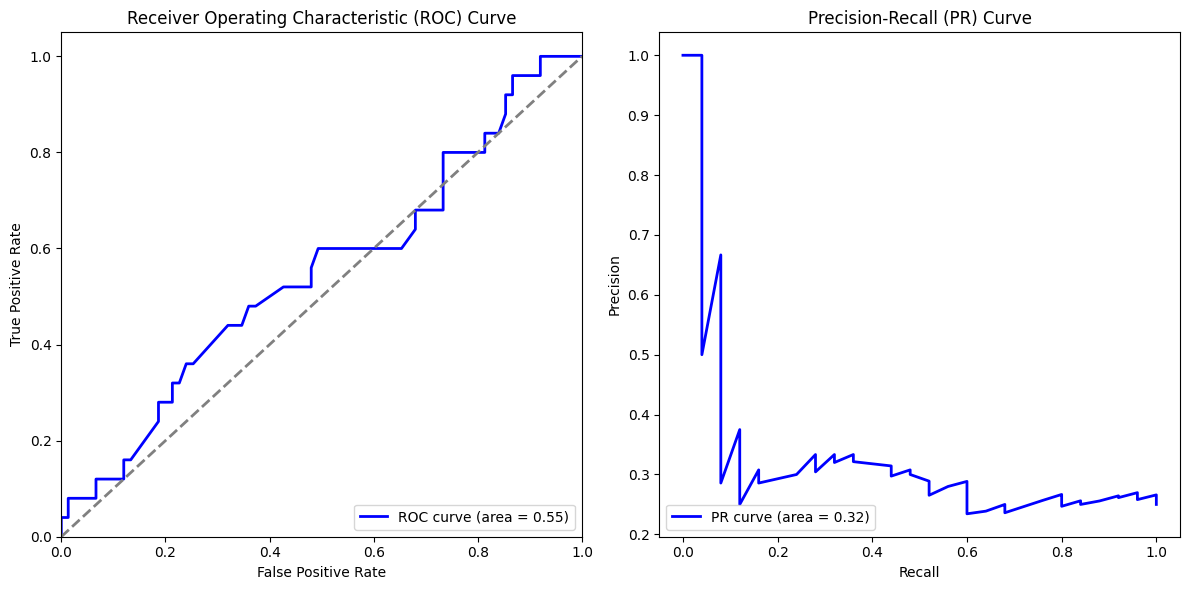

In [801]:
model_features = CatBoostClassifier(
                            **study_features.best_params,
                           iterations=1000,
                           verbose=100,
                           early_stopping_rounds=50,
                           random_seed=1010,
                           cat_features=['disc_numr'])

model_features.fit(X_train, y_train, eval_set=(X_test, y_test))

#y_pred = model.predict(test_pool)
y_pred_proba = model_features.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.1).astype(int)

metrics, summary_models_features_catboost = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.1)

Лучший порог: 0.20 с F1-score: 0.41
Evaluation Metrics:
Precision: 0.2519480519480519
Recall: 0.9948717948717949
F1-score: 0.40207253886010363
ROC AUC score: 0.6889412463915776
PR AUC score: 0.48486205576876884
Lift: 1.0323409923409923 (Max lift: 4.097435897435897 )



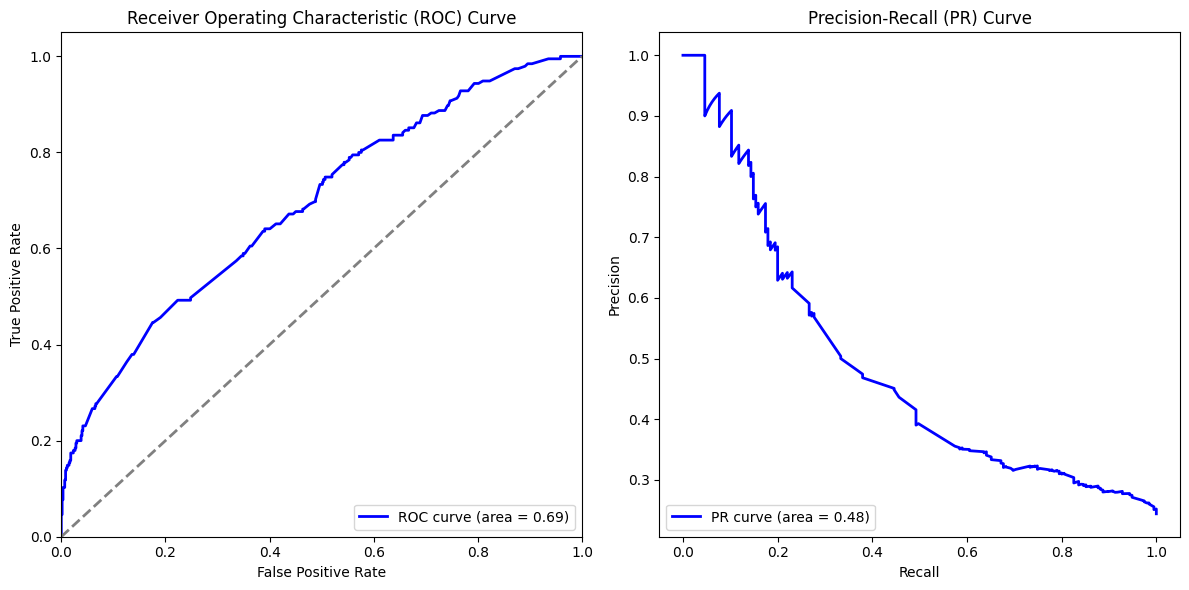

Evaluation Metrics:
Precision: 0.25773195876288657
Recall: 1.0
F1-score: 0.4098360655737705
ROC AUC score: 0.5482666666666667
PR AUC score: 0.32230251736409504
Lift: 1.0309278350515465 (Max lift: 4.0 )



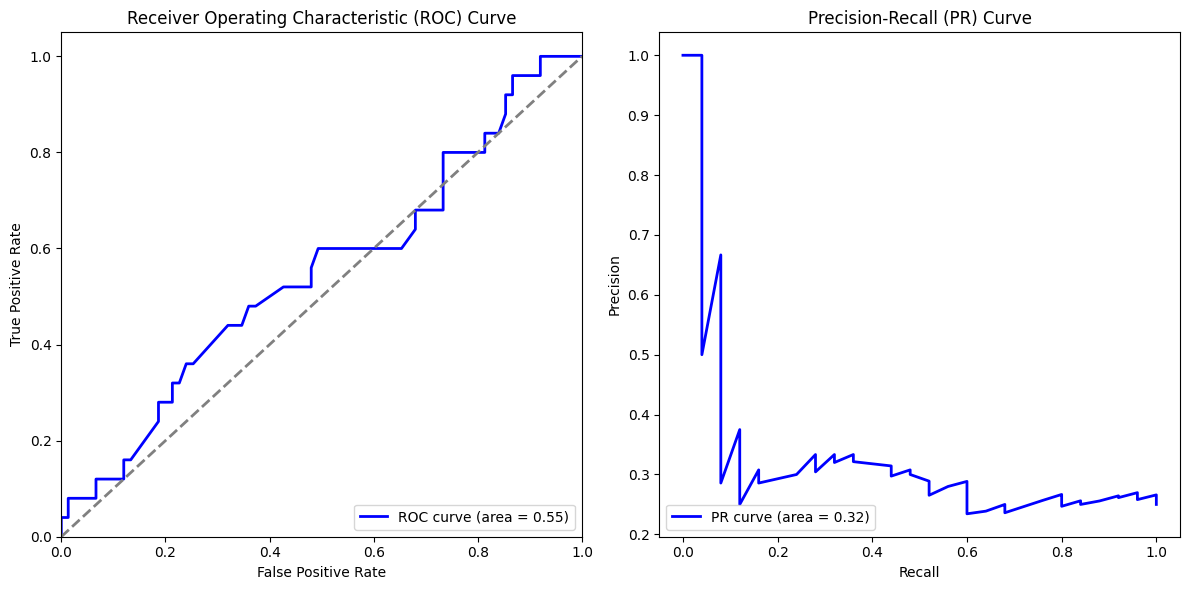

Evaluation Metrics:
Precision: 0.23469387755102042
Recall: 0.9583333333333334
F1-score: 0.3770491803278688
ROC AUC score: 0.6951754385964912
PR AUC score: 0.3519073075392834
Lift: 0.9778911564625851 (Max lift: 4.166666666666667 )



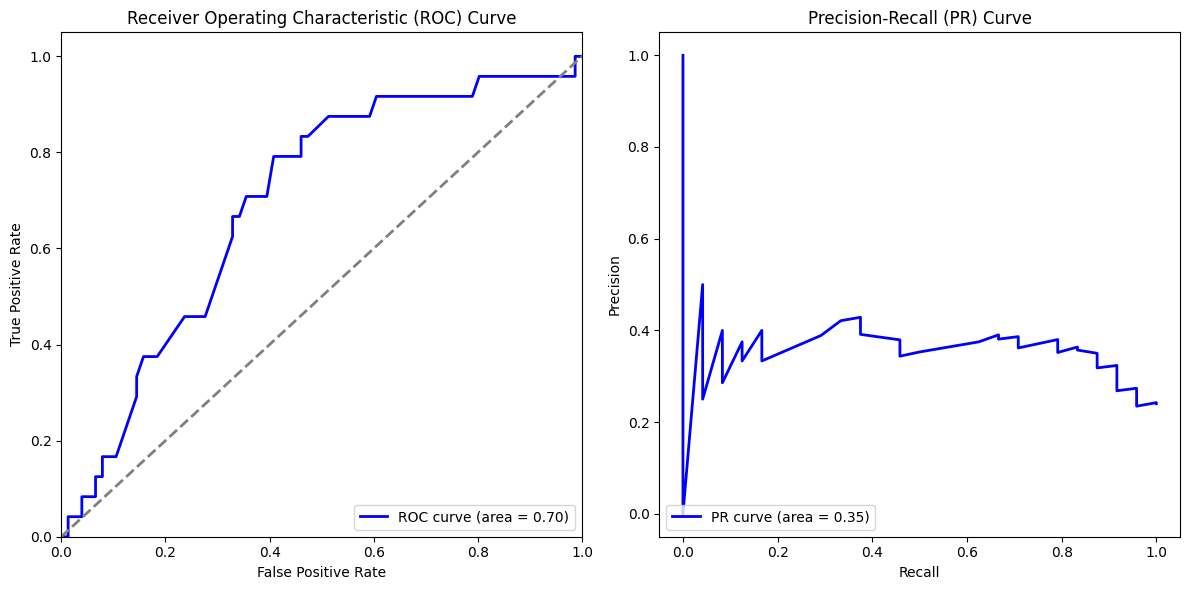

model_name precision    recall  f1_score   roc_auc  \
0  tfidf_catboost_optimal_th  0.352941  0.122449  0.181818  0.583322   
0             LaBSE_catboost      0.25  0.714286   0.37037  0.580078   
0       features_catboost_th  0.234694  0.958333  0.377049  0.695175   

     pr_auc      lift  max_lift threshold  
0  0.277428  1.440576  4.081633       0.3  
0   0.32389  1.020408  4.081633       0.2  
0  0.351907  0.977891  4.166667       0.2

In [802]:
thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    metrics, _ = evaluate_model_predictions(y_test, y_pred_proba, threshold=threshold, visual = False)
    if metrics['f1_score'] > best_f1:
        best_f1 = metrics['f1_score']
        best_threshold = threshold

print(f"Лучший порог: {best_threshold:.2f} с F1-score: {best_f1:.2f}")

#train
y_train_pred_proba = model_features.predict_proba(X_train)[:, 1]
best_metrics, train_features_catboost_th = evaluate_model_predictions(y_train, y_train_pred_proba, threshold=best_threshold,
                                          save_metrics_df=train_labse_catboost,
                                          model_name = "features_catboost_th")
#test
y_test_pred_proba = model_features.predict_proba(X_test)[:, 1]
best_metrics, test_features_catboost_th = evaluate_model_predictions(y_test, y_test_pred_proba, threshold=best_threshold,
                                          save_metrics_df=test_labse_catboost,
                                          model_name = "features_catboost_th")
#val
y_val_pred_proba = model_features.predict_proba(X_val)[:, 1]
best_metrics, val_features_catboost_th = evaluate_model_predictions(y_val, y_val_pred_proba, threshold=best_threshold,
                                          save_metrics_df=val_labse_catboost,
                                          model_name = "features_catboost_th")

val_features_catboost_th

In [726]:
def calculate_top_lemmas(train_texts, test_texts, top_n=20):
    """
    Вычисляет топ-N лемм по частотной разнице и добавляет колонки для каждой такой леммы,
    отмечая их наличие в текстах для обучающей и тестовой выборок.

    Parameters:
    train_texts (pd.Series): Колонка датафрейма с текстами для обучения.
    test_texts (pd.Series): Колонка датафрейма с текстами для тестирования.
    top_n (int): Количество топ лемм для выбора. По умолчанию 20.

    Returns:
    pd.DataFrame: Обновленные обучающая и тестовая выборки с добавленными колонками для топ-лемм.
    """
    def extract_lemmas(texts):
        vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
        X = vectorizer.fit_transform(texts)
        return X, vectorizer.get_feature_names_out()

    X_train, feature_names = extract_lemmas(train_texts)
    y_train = df.loc[train_texts.index, target_column]
    
    pos_texts = train_texts[y_train == 1]
    neg_texts = train_texts[y_train == 0]

    pos_counter = Counter(" ".join(pos_texts).split())
    neg_counter = Counter(" ".join(neg_texts).split())

    total_pos = sum(pos_counter.values())
    total_neg = sum(neg_counter.values())

    frequency_difference = {
        word: (pos_counter[word] / total_pos) - (neg_counter[word] / total_neg)
        for word in feature_names
    }

    top_lemmas = sorted(frequency_difference.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
    top_lemmas = [lemma for lemma, _ in top_lemmas]

    def add_lemma_columns(df, texts, lemmas):
        for lemma in lemmas:
            df[f'lemma_{lemma}'] = texts.apply(lambda x: int(lemma in x.split()))
        return df

    train_df = pd.DataFrame(index=train_texts.index)
    train_df = add_lemma_columns(train_df, train_texts, top_lemmas)

    test_df = pd.DataFrame(index=test_texts.index)
    test_df = add_lemma_columns(test_df, test_texts, top_lemmas)

    return train_df, test_df

In [727]:
X_train_columns = X_train.columns
train_texts = df.loc[X_train.index, 'processed_talks']
test_texts = df.loc[X_test.index, 'processed_talks']
val_texts = df.loc[X_val.index, 'processed_talks']

X_train_lemmas, X_test_lemmas = calculate_top_lemmas(train_texts, test_texts)
_, X_val_lemmas = calculate_top_lemmas(train_texts, val_texts)

X_train = pd.concat([X_train, X_train_lemmas], axis=1)
X_test = pd.concat([X_test, X_test_lemmas], axis=1)
X_val = pd.concat([X_val, X_val_lemmas], axis=1)

X_train_lemmas.columns

Index(['lemma_вопрос', 'lemma_номер', 'lemma_мог', 'lemma_телефон',
       'lemma_случа', 'lemma_ипотек', 'lemma_соответствен', 'lemma_менеджер',
       'lemma_город', 'lemma_территор', 'lemma_продаж', 'lemma_дом',
       'lemma_метр', 'lemma_дан', 'lemma_срок', 'lemma_мож', 'lemma_хорош',
       'lemma_допуст', 'lemma_школ', 'lemma_обраща'],
      dtype='object')

In [493]:
sampler = TPESampler(seed=123)
study_w_lemm = optuna.create_study(direction='maximize', sampler=sampler)
study_w_lemm.optimize(objective, n_trials=20)
study_w_lemm.best_params

[I 2024-06-24 04:58:14,475] A new study created in memory with name: no-name-a9ac27f9-c8af-4732-96b3-cf8807c0a852


0:	learn: 0.6920038	test: 0.6920063	best: 0.6920063 (0)	total: 3.79ms	remaining: 3.79s
100:	learn: 0.5867684	test: 0.5914601	best: 0.5914601 (100)	total: 246ms	remaining: 2.19s
200:	learn: 0.5619738	test: 0.5697652	best: 0.5697652 (200)	total: 532ms	remaining: 2.11s
300:	learn: 0.5533748	test: 0.5632731	best: 0.5632731 (300)	total: 873ms	remaining: 2.03s
400:	learn: 0.5475667	test: 0.5602049	best: 0.5602049 (400)	total: 1.2s	remaining: 1.79s
500:	learn: 0.5418699	test: 0.5575092	best: 0.5575092 (500)	total: 1.54s	remaining: 1.53s
600:	learn: 0.5367667	test: 0.5554440	best: 0.5554347 (599)	total: 1.87s	remaining: 1.24s
700:	learn: 0.5322186	test: 0.5537908	best: 0.5537873 (699)	total: 2.19s	remaining: 936ms
800:	learn: 0.5279931	test: 0.5525758	best: 0.5525758 (800)	total: 2.52s	remaining: 625ms
900:	learn: 0.5238898	test: 0.5513027	best: 0.5513027 (900)	total: 2.86s	remaining: 314ms


[I 2024-06-24 04:58:18,395] Trial 0 finished with value: 0.3983246332547195 and parameters: {'depth': 8, 'l2_leaf_reg': 1431.410535416947, 'subsample': 0.26550888088599295, 'colsample_bylevel': 0.5737490306287467, 'min_data_in_leaf': 72}. Best is trial 0 with value: 0.3983246332547195.


999:	learn: 0.5199809	test: 0.5503405	best: 0.5503273 (989)	total: 3.21s	remaining: 0us

bestTest = 0.550327265
bestIteration = 989

Shrink model to first 990 iterations.
0:	learn: 0.6916677	test: 0.6917030	best: 0.6917030 (0)	total: 1.74ms	remaining: 1.73s
100:	learn: 0.6212661	test: 0.6241384	best: 0.6241384 (100)	total: 152ms	remaining: 1.35s
200:	learn: 0.5903180	test: 0.5950549	best: 0.5950549 (200)	total: 302ms	remaining: 1.2s
300:	learn: 0.5715313	test: 0.5777563	best: 0.5777563 (300)	total: 463ms	remaining: 1.07s
400:	learn: 0.5642769	test: 0.5718519	best: 0.5718519 (400)	total: 648ms	remaining: 969ms
500:	learn: 0.5586117	test: 0.5678324	best: 0.5678324 (500)	total: 828ms	remaining: 825ms
600:	learn: 0.5542647	test: 0.5648852	best: 0.5648852 (600)	total: 1s	remaining: 667ms
700:	learn: 0.5506164	test: 0.5624032	best: 0.5624032 (700)	total: 1.18s	remaining: 505ms
800:	learn: 0.5474989	test: 0.5604536	best: 0.5604536 (800)	total: 1.37s	remaining: 341ms
900:	learn: 0.5447168	test

[I 2024-06-24 04:58:20,796] Trial 1 finished with value: 0.41867404105326583 and parameters: {'depth': 6, 'l2_leaf_reg': 4903.840227724692, 'subsample': 0.7005882516556201, 'colsample_bylevel': 0.5068853064101428, 'min_data_in_leaf': 40}. Best is trial 1 with value: 0.41867404105326583.


999:	learn: 0.5422532	test: 0.5574857	best: 0.5574857 (999)	total: 1.72s	remaining: 0us

bestTest = 0.5574856977
bestIteration = 999

0:	learn: 0.6926582	test: 0.6926170	best: 0.6926170 (0)	total: 1.53ms	remaining: 1.53s
100:	learn: 0.6203866	test: 0.6234816	best: 0.6234816 (100)	total: 140ms	remaining: 1.24s
200:	learn: 0.5859799	test: 0.5907816	best: 0.5907816 (200)	total: 268ms	remaining: 1.06s
300:	learn: 0.5705512	test: 0.5764050	best: 0.5764050 (300)	total: 386ms	remaining: 897ms
400:	learn: 0.5604108	test: 0.5670369	best: 0.5670369 (400)	total: 508ms	remaining: 758ms
500:	learn: 0.5543319	test: 0.5621911	best: 0.5621911 (500)	total: 627ms	remaining: 624ms
600:	learn: 0.5494388	test: 0.5586100	best: 0.5586100 (600)	total: 748ms	remaining: 497ms
700:	learn: 0.5456704	test: 0.5558206	best: 0.5558206 (700)	total: 873ms	remaining: 373ms
800:	learn: 0.5426181	test: 0.5537262	best: 0.5537262 (800)	total: 1.01s	remaining: 252ms
900:	learn: 0.5398995	test: 0.5516172	best: 0.5516172 (900)

[I 2024-06-24 04:58:22,695] Trial 2 finished with value: 0.37337638263690154 and parameters: {'depth': 5, 'l2_leaf_reg': 3645.519487212824, 'subsample': 0.46664363244564316, 'colsample_bylevel': 0.10669400177908993, 'min_data_in_leaf': 40}. Best is trial 1 with value: 0.41867404105326583.


0:	learn: 0.6900966	test: 0.6899548	best: 0.6899548 (0)	total: 1.86ms	remaining: 1.86s
100:	learn: 0.5751259	test: 0.5816358	best: 0.5816358 (100)	total: 239ms	remaining: 2.13s
200:	learn: 0.5528759	test: 0.5632300	best: 0.5632300 (200)	total: 509ms	remaining: 2.02s
300:	learn: 0.5432910	test: 0.5576167	best: 0.5576065 (298)	total: 844ms	remaining: 1.96s
400:	learn: 0.5361902	test: 0.5543771	best: 0.5543771 (400)	total: 1.17s	remaining: 1.74s
500:	learn: 0.5297025	test: 0.5523216	best: 0.5523216 (500)	total: 1.49s	remaining: 1.49s
600:	learn: 0.5231918	test: 0.5500406	best: 0.5500406 (600)	total: 1.83s	remaining: 1.21s
700:	learn: 0.5172680	test: 0.5484885	best: 0.5484885 (700)	total: 2.17s	remaining: 924ms
800:	learn: 0.5119348	test: 0.5475401	best: 0.5475282 (796)	total: 2.51s	remaining: 624ms
900:	learn: 0.5066951	test: 0.5466236	best: 0.5466072 (899)	total: 2.84s	remaining: 312ms


[I 2024-06-24 04:58:26,617] Trial 3 finished with value: 0.4022566520400376 and parameters: {'depth': 8, 'l2_leaf_reg': 913.2761605370464, 'subsample': 0.2166791683401179, 'colsample_bylevel': 0.5549738051497465, 'min_data_in_leaf': 54}. Best is trial 1 with value: 0.41867404105326583.


999:	learn: 0.5016040	test: 0.5459754	best: 0.5459680 (996)	total: 3.17s	remaining: 0us

bestTest = 0.5459680226
bestIteration = 996

Shrink model to first 997 iterations.
0:	learn: 0.6928174	test: 0.6928086	best: 0.6928086 (0)	total: 3.63ms	remaining: 3.63s
100:	learn: 0.6400269	test: 0.6438319	best: 0.6438319 (100)	total: 267ms	remaining: 2.38s
200:	learn: 0.5954211	test: 0.6012346	best: 0.6012346 (200)	total: 504ms	remaining: 2s
300:	learn: 0.5754663	test: 0.5827278	best: 0.5827278 (300)	total: 754ms	remaining: 1.75s
400:	learn: 0.5675565	test: 0.5770959	best: 0.5770959 (400)	total: 1.08s	remaining: 1.61s
500:	learn: 0.5625084	test: 0.5739862	best: 0.5739862 (500)	total: 1.42s	remaining: 1.42s
600:	learn: 0.5584081	test: 0.5713904	best: 0.5713904 (600)	total: 1.78s	remaining: 1.19s
700:	learn: 0.5539227	test: 0.5686913	best: 0.5686913 (700)	total: 2.14s	remaining: 915ms
800:	learn: 0.5506327	test: 0.5669078	best: 0.5669078 (800)	total: 2.5s	remaining: 621ms
900:	learn: 0.5478481	tes

[I 2024-06-24 04:58:30,497] Trial 4 finished with value: 0.38946236606722395 and parameters: {'depth': 8, 'l2_leaf_reg': 4247.30953859487, 'subsample': 0.7382325586176035, 'colsample_bylevel': 0.6304723351437037, 'min_data_in_leaf': 73}. Best is trial 1 with value: 0.41867404105326583.


999:	learn: 0.5450659	test: 0.5641987	best: 0.5641987 (999)	total: 3.19s	remaining: 0us

bestTest = 0.5641986885
bestIteration = 999

0:	learn: 0.6917702	test: 0.6917184	best: 0.6917184 (0)	total: 2.04ms	remaining: 2.04s
100:	learn: 0.5970872	test: 0.6023328	best: 0.6023328 (100)	total: 150ms	remaining: 1.34s
200:	learn: 0.5658989	test: 0.5725225	best: 0.5725225 (200)	total: 286ms	remaining: 1.14s
300:	learn: 0.5533569	test: 0.5631225	best: 0.5631225 (300)	total: 422ms	remaining: 980ms
400:	learn: 0.5462586	test: 0.5588410	best: 0.5588410 (400)	total: 568ms	remaining: 848ms
500:	learn: 0.5406258	test: 0.5552640	best: 0.5552640 (500)	total: 719ms	remaining: 716ms
600:	learn: 0.5361897	test: 0.5533277	best: 0.5533277 (600)	total: 854ms	remaining: 567ms
700:	learn: 0.5321143	test: 0.5517009	best: 0.5517009 (700)	total: 992ms	remaining: 423ms
800:	learn: 0.5284343	test: 0.5503942	best: 0.5503942 (800)	total: 1.13s	remaining: 280ms
900:	learn: 0.5251824	test: 0.5490769	best: 0.5490769 (900)

[I 2024-06-24 04:58:32,572] Trial 5 finished with value: 0.3888289804777254 and parameters: {'depth': 5, 'l2_leaf_reg': 1809.5814894559483, 'subsample': 0.2668500693350078, 'colsample_bylevel': 0.32902834406938786, 'min_data_in_leaf': 64}. Best is trial 1 with value: 0.41867404105326583.


0:	learn: 0.6919653	test: 0.6919489	best: 0.6919489 (0)	total: 1.78ms	remaining: 1.78s
100:	learn: 0.5896609	test: 0.5928313	best: 0.5928313 (100)	total: 121ms	remaining: 1.07s
200:	learn: 0.5602004	test: 0.5658304	best: 0.5658304 (200)	total: 237ms	remaining: 943ms
300:	learn: 0.5488343	test: 0.5571058	best: 0.5571058 (300)	total: 351ms	remaining: 815ms
400:	learn: 0.5413800	test: 0.5523654	best: 0.5523654 (400)	total: 466ms	remaining: 696ms
500:	learn: 0.5363383	test: 0.5501659	best: 0.5501659 (500)	total: 583ms	remaining: 581ms
600:	learn: 0.5321952	test: 0.5487939	best: 0.5487939 (600)	total: 703ms	remaining: 467ms
700:	learn: 0.5286281	test: 0.5472927	best: 0.5472824 (698)	total: 827ms	remaining: 353ms
800:	learn: 0.5257071	test: 0.5463817	best: 0.5463513 (799)	total: 966ms	remaining: 240ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5462983181
bestIteration = 811

Shrink model to first 812 iterations.


[I 2024-06-24 04:58:34,239] Trial 6 finished with value: 0.42263071225738774 and parameters: {'depth': 3, 'l2_leaf_reg': 2169.0721622249616, 'subsample': 0.45931962516316155, 'colsample_bylevel': 0.5190008427677909, 'min_data_in_leaf': 43}. Best is trial 6 with value: 0.42263071225738774.


0:	learn: 0.6921914	test: 0.6922830	best: 0.6922830 (0)	total: 2.12ms	remaining: 2.12s
100:	learn: 0.5933023	test: 0.5995187	best: 0.5995187 (100)	total: 170ms	remaining: 1.51s
200:	learn: 0.5582873	test: 0.5682314	best: 0.5682314 (200)	total: 322ms	remaining: 1.28s
300:	learn: 0.5483776	test: 0.5605314	best: 0.5605314 (300)	total: 472ms	remaining: 1.09s
400:	learn: 0.5430563	test: 0.5583671	best: 0.5583671 (400)	total: 628ms	remaining: 938ms
500:	learn: 0.5385454	test: 0.5561951	best: 0.5561951 (500)	total: 794ms	remaining: 791ms
600:	learn: 0.5344589	test: 0.5544901	best: 0.5544901 (600)	total: 969ms	remaining: 644ms
700:	learn: 0.5308383	test: 0.5527073	best: 0.5527073 (700)	total: 1.14s	remaining: 484ms
800:	learn: 0.5275678	test: 0.5511621	best: 0.5511528 (793)	total: 1.29s	remaining: 321ms
900:	learn: 0.5245307	test: 0.5497820	best: 0.5497648 (899)	total: 1.44s	remaining: 159ms
999:	learn: 0.5215755	test: 0.5488959	best: 0.5488590 (993)	total: 1.6s	remaining: 0us


[I 2024-06-24 04:58:36,478] Trial 7 finished with value: 0.3807498413493644 and parameters: {'depth': 5, 'l2_leaf_reg': 2132.3301835070783, 'subsample': 0.8987197049612781, 'colsample_bylevel': 0.9469520172936856, 'min_data_in_leaf': 51}. Best is trial 6 with value: 0.42263071225738774.



bestTest = 0.5488590241
bestIteration = 993

Shrink model to first 994 iterations.
0:	learn: 0.6896751	test: 0.6898556	best: 0.6898556 (0)	total: 2.9ms	remaining: 2.9s
100:	learn: 0.5684742	test: 0.5761825	best: 0.5761825 (100)	total: 213ms	remaining: 1.9s
200:	learn: 0.5426756	test: 0.5564145	best: 0.5564145 (200)	total: 411ms	remaining: 1.64s
300:	learn: 0.5307771	test: 0.5508052	best: 0.5507973 (290)	total: 632ms	remaining: 1.47s
400:	learn: 0.5209477	test: 0.5478599	best: 0.5478398 (396)	total: 862ms	remaining: 1.29s
500:	learn: 0.5122317	test: 0.5450064	best: 0.5449954 (497)	total: 1.08s	remaining: 1.08s
600:	learn: 0.5043649	test: 0.5441627	best: 0.5439468 (581)	total: 1.31s	remaining: 867ms
700:	learn: 0.4969553	test: 0.5431905	best: 0.5431905 (700)	total: 1.54s	remaining: 656ms
800:	learn: 0.4900874	test: 0.5425931	best: 0.5425931 (800)	total: 1.77s	remaining: 439ms
900:	learn: 0.4835581	test: 0.5422120	best: 0.5421903 (865)	total: 2s	remaining: 220ms
999:	learn: 0.4775152	tes

[I 2024-06-24 04:58:39,454] Trial 8 finished with value: 0.4023765949392061 and parameters: {'depth': 7, 'l2_leaf_reg': 578.9763570013993, 'subsample': 0.35142120772930485, 'colsample_bylevel': 0.4440849013559502, 'min_data_in_leaf': 87}. Best is trial 6 with value: 0.42263071225738774.


0:	learn: 0.6902198	test: 0.6902002	best: 0.6902002 (0)	total: 1.33ms	remaining: 1.33s
100:	learn: 0.5979404	test: 0.6033193	best: 0.6033193 (100)	total: 146ms	remaining: 1.3s
200:	learn: 0.5631409	test: 0.5709405	best: 0.5709405 (200)	total: 288ms	remaining: 1.15s
300:	learn: 0.5524830	test: 0.5621144	best: 0.5621144 (300)	total: 444ms	remaining: 1.03s
400:	learn: 0.5464613	test: 0.5582366	best: 0.5582366 (400)	total: 594ms	remaining: 887ms
500:	learn: 0.5417507	test: 0.5557020	best: 0.5557020 (500)	total: 748ms	remaining: 745ms
600:	learn: 0.5375170	test: 0.5539371	best: 0.5539366 (599)	total: 918ms	remaining: 609ms
700:	learn: 0.5338958	test: 0.5524048	best: 0.5524048 (700)	total: 1.07s	remaining: 455ms
800:	learn: 0.5308121	test: 0.5511569	best: 0.5511569 (800)	total: 1.21s	remaining: 302ms
900:	learn: 0.5277742	test: 0.5498833	best: 0.5498833 (900)	total: 1.37s	remaining: 151ms
999:	learn: 0.5250477	test: 0.5488139	best: 0.5488139 (999)	total: 1.53s	remaining: 0us

bestTest = 0.54

[I 2024-06-24 04:58:41,970] Trial 9 finished with value: 0.3945716896365983 and parameters: {'depth': 5, 'l2_leaf_reg': 2415.688287049259, 'subsample': 0.9862817963301698, 'colsample_bylevel': 0.5435108632968189, 'min_data_in_leaf': 62}. Best is trial 6 with value: 0.42263071225738774.


0:	learn: 0.6907553	test: 0.6911472	best: 0.6911472 (0)	total: 1.64ms	remaining: 1.64s
100:	learn: 0.5987045	test: 0.6043064	best: 0.6043064 (100)	total: 132ms	remaining: 1.17s
200:	learn: 0.5680961	test: 0.5751185	best: 0.5751185 (200)	total: 290ms	remaining: 1.15s
300:	learn: 0.5552383	test: 0.5641603	best: 0.5641603 (300)	total: 442ms	remaining: 1.03s
400:	learn: 0.5470356	test: 0.5582751	best: 0.5582751 (400)	total: 586ms	remaining: 875ms
500:	learn: 0.5414688	test: 0.5550838	best: 0.5550838 (500)	total: 723ms	remaining: 720ms
600:	learn: 0.5376506	test: 0.5531937	best: 0.5531937 (600)	total: 840ms	remaining: 558ms
700:	learn: 0.5340793	test: 0.5520897	best: 0.5520897 (700)	total: 962ms	remaining: 410ms
800:	learn: 0.5309977	test: 0.5510867	best: 0.5510867 (800)	total: 1.09s	remaining: 270ms
900:	learn: 0.5282516	test: 0.5502998	best: 0.5502180 (890)	total: 1.21s	remaining: 133ms
999:	learn: 0.5258482	test: 0.5496241	best: 0.5496206 (997)	total: 1.33s	remaining: 0us

bestTest = 0.5

[I 2024-06-24 04:58:44,100] Trial 10 finished with value: 0.37958249464403737 and parameters: {'depth': 3, 'l2_leaf_reg': 3112.6038635231657, 'subsample': 0.568568860185097, 'colsample_bylevel': 0.8229809512646523, 'min_data_in_leaf': 6}. Best is trial 6 with value: 0.42263071225738774.


0:	learn: 0.6922065	test: 0.6921590	best: 0.6921590 (0)	total: 1.89ms	remaining: 1.89s
100:	learn: 0.6365203	test: 0.6391309	best: 0.6391309 (100)	total: 317ms	remaining: 2.83s
200:	learn: 0.6024751	test: 0.6070026	best: 0.6070026 (200)	total: 683ms	remaining: 2.71s
300:	learn: 0.5835339	test: 0.5893751	best: 0.5893751 (300)	total: 1.07s	remaining: 2.48s
400:	learn: 0.5747511	test: 0.5821021	best: 0.5821021 (400)	total: 1.69s	remaining: 2.53s
500:	learn: 0.5693445	test: 0.5782703	best: 0.5782703 (500)	total: 2.35s	remaining: 2.34s
600:	learn: 0.5644578	test: 0.5746222	best: 0.5746222 (600)	total: 3.1s	remaining: 2.06s
700:	learn: 0.5607353	test: 0.5718815	best: 0.5718815 (700)	total: 3.79s	remaining: 1.62s
800:	learn: 0.5575249	test: 0.5698060	best: 0.5698060 (800)	total: 4.55s	remaining: 1.13s
900:	learn: 0.5546749	test: 0.5680096	best: 0.5680096 (900)	total: 5.26s	remaining: 578ms
999:	learn: 0.5520063	test: 0.5664025	best: 0.5664025 (999)	total: 6.02s	remaining: 0us

bestTest = 0.56

[I 2024-06-24 04:58:50,948] Trial 11 finished with value: 0.3949262099258905 and parameters: {'depth': 10, 'l2_leaf_reg': 4783.469732220135, 'subsample': 0.6516433259804484, 'colsample_bylevel': 0.30169657418057505, 'min_data_in_leaf': 28}. Best is trial 6 with value: 0.42263071225738774.


0:	learn: 0.6918974	test: 0.6919232	best: 0.6919232 (0)	total: 2.24ms	remaining: 2.24s
100:	learn: 0.5981625	test: 0.6035718	best: 0.6035718 (100)	total: 128ms	remaining: 1.14s
200:	learn: 0.5676242	test: 0.5753349	best: 0.5753349 (200)	total: 257ms	remaining: 1.02s
300:	learn: 0.5544358	test: 0.5638178	best: 0.5638178 (300)	total: 384ms	remaining: 891ms
400:	learn: 0.5468479	test: 0.5587019	best: 0.5587019 (400)	total: 506ms	remaining: 756ms
500:	learn: 0.5412910	test: 0.5552696	best: 0.5552696 (500)	total: 627ms	remaining: 624ms
600:	learn: 0.5368066	test: 0.5527234	best: 0.5527234 (600)	total: 748ms	remaining: 496ms
700:	learn: 0.5333438	test: 0.5513305	best: 0.5513305 (700)	total: 876ms	remaining: 374ms
800:	learn: 0.5305485	test: 0.5507281	best: 0.5507264 (799)	total: 996ms	remaining: 247ms
900:	learn: 0.5281089	test: 0.5502837	best: 0.5502837 (900)	total: 1.11s	remaining: 122ms
999:	learn: 0.5258010	test: 0.5497786	best: 0.5497452 (984)	total: 1.23s	remaining: 0us

bestTest = 0.5

[I 2024-06-24 04:58:52,987] Trial 12 finished with value: 0.3809364812142375 and parameters: {'depth': 3, 'l2_leaf_reg': 3197.4819676046873, 'subsample': 0.7668828880149997, 'colsample_bylevel': 0.7154510881060792, 'min_data_in_leaf': 26}. Best is trial 6 with value: 0.42263071225738774.


0:	learn: 0.6857072	test: 0.6863618	best: 0.6863618 (0)	total: 2.23ms	remaining: 2.23s
100:	learn: 0.5249341	test: 0.5504084	best: 0.5497772 (97)	total: 134ms	remaining: 1.2s
200:	learn: 0.5053058	test: 0.5435636	best: 0.5433395 (197)	total: 259ms	remaining: 1.03s
300:	learn: 0.4897123	test: 0.5417587	best: 0.5417587 (300)	total: 382ms	remaining: 887ms
400:	learn: 0.4790646	test: 0.5402394	best: 0.5402394 (400)	total: 510ms	remaining: 762ms
500:	learn: 0.4668396	test: 0.5396803	best: 0.5383682 (474)	total: 642ms	remaining: 640ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5383682075
bestIteration = 474

Shrink model to first 475 iterations.


[I 2024-06-24 04:58:54,390] Trial 13 finished with value: 0.43044311639006927 and parameters: {'depth': 4, 'l2_leaf_reg': 77.61112511143756, 'subsample': 0.06563945847721842, 'colsample_bylevel': 0.37053689801228185, 'min_data_in_leaf': 34}. Best is trial 13 with value: 0.43044311639006927.


0:	learn: 0.6836183	test: 0.6842365	best: 0.6842365 (0)	total: 1.59ms	remaining: 1.58s
100:	learn: 0.5190926	test: 0.5496151	best: 0.5493827 (96)	total: 114ms	remaining: 1.01s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5474345
bestIteration = 136

Shrink model to first 137 iterations.


[I 2024-06-24 04:58:55,108] Trial 14 finished with value: 0.38493654564851565 and parameters: {'depth': 3, 'l2_leaf_reg': 1.821038331060663, 'subsample': 0.08918518810581054, 'colsample_bylevel': 0.19943567249554603, 'min_data_in_leaf': 11}. Best is trial 13 with value: 0.43044311639006927.


0:	learn: 0.6846128	test: 0.6844183	best: 0.6844183 (0)	total: 1.63ms	remaining: 1.63s
100:	learn: 0.5104283	test: 0.5444449	best: 0.5444449 (100)	total: 129ms	remaining: 1.15s


[I 2024-06-24 04:58:55,679] Trial 15 finished with value: 0.43538069539288016 and parameters: {'depth': 4, 'l2_leaf_reg': 27.729795306624112, 'subsample': 0.06023584359380176, 'colsample_bylevel': 0.31770469170142557, 'min_data_in_leaf': 34}. Best is trial 15 with value: 0.43538069539288016.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5408095232
bestIteration = 145

Shrink model to first 146 iterations.
0:	learn: 0.6854424	test: 0.6863463	best: 0.6863463 (0)	total: 1.4ms	remaining: 1.4s
100:	learn: 0.5228923	test: 0.5480143	best: 0.5478999 (99)	total: 138ms	remaining: 1.22s
200:	learn: 0.5023560	test: 0.5440051	best: 0.5434439 (178)	total: 279ms	remaining: 1.11s
300:	learn: 0.4865441	test: 0.5424582	best: 0.5419366 (278)	total: 408ms	remaining: 947ms


[I 2024-06-24 04:58:56,488] Trial 16 finished with value: 0.4152713179364411 and parameters: {'depth': 4, 'l2_leaf_reg': 73.14864852333454, 'subsample': 0.12371879180801185, 'colsample_bylevel': 0.3450482475131164, 'min_data_in_leaf': 21}. Best is trial 15 with value: 0.43538069539288016.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5419366356
bestIteration = 278

Shrink model to first 279 iterations.
0:	learn: 0.6898259	test: 0.6899793	best: 0.6899793 (0)	total: 1.43ms	remaining: 1.43s
100:	learn: 0.5778801	test: 0.5834040	best: 0.5834040 (100)	total: 117ms	remaining: 1.04s
200:	learn: 0.5535698	test: 0.5619749	best: 0.5619749 (200)	total: 231ms	remaining: 917ms
300:	learn: 0.5428783	test: 0.5542247	best: 0.5542247 (300)	total: 352ms	remaining: 816ms
400:	learn: 0.5361922	test: 0.5506483	best: 0.5506483 (400)	total: 469ms	remaining: 701ms
500:	learn: 0.5310624	test: 0.5485054	best: 0.5484461 (496)	total: 592ms	remaining: 590ms
600:	learn: 0.5267861	test: 0.5473432	best: 0.5472819 (597)	total: 721ms	remaining: 479ms
700:	learn: 0.5230222	test: 0.5460325	best: 0.5460325 (700)	total: 839ms	remaining: 358ms
800:	learn: 0.5199871	test: 0.5452093	best: 0.5452093 (800)	total: 958ms	remaining: 238ms
900:	learn: 0.5168339	test: 0.5445681	best: 0.5445681 (

[I 2024-06-24 04:58:58,224] Trial 17 finished with value: 0.4026288082531317 and parameters: {'depth': 4, 'l2_leaf_reg': 988.5411694514689, 'subsample': 0.07774396134061845, 'colsample_bylevel': 0.17276755983132785, 'min_data_in_leaf': 98}. Best is trial 15 with value: 0.43538069539288016.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5443877002
bestIteration = 906

Shrink model to first 907 iterations.
0:	learn: 0.6852246	test: 0.6854115	best: 0.6854115 (0)	total: 1.12ms	remaining: 1.12s
100:	learn: 0.5518194	test: 0.5596583	best: 0.5596583 (100)	total: 107ms	remaining: 950ms
200:	learn: 0.5405879	test: 0.5505674	best: 0.5505674 (200)	total: 226ms	remaining: 899ms
300:	learn: 0.5343258	test: 0.5458806	best: 0.5458806 (300)	total: 336ms	remaining: 780ms
400:	learn: 0.5286338	test: 0.5437266	best: 0.5437266 (400)	total: 452ms	remaining: 675ms
500:	learn: 0.5231549	test: 0.5417367	best: 0.5417123 (499)	total: 576ms	remaining: 573ms
600:	learn: 0.5189305	test: 0.5400872	best: 0.5400245 (587)	total: 701ms	remaining: 466ms


[I 2024-06-24 04:58:59,476] Trial 18 finished with value: 0.41878693407011647 and parameters: {'depth': 6, 'l2_leaf_reg': 530.4622995902932, 'subsample': 0.16982914508913707, 'colsample_bylevel': 0.05632311538367657, 'min_data_in_leaf': 19}. Best is trial 15 with value: 0.43538069539288016.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5396522993
bestIteration = 629

Shrink model to first 630 iterations.
0:	learn: 0.6904789	test: 0.6904047	best: 0.6904047 (0)	total: 1.97ms	remaining: 1.97s
100:	learn: 0.5790644	test: 0.5843248	best: 0.5843248 (100)	total: 132ms	remaining: 1.18s
200:	learn: 0.5540484	test: 0.5618268	best: 0.5618268 (200)	total: 266ms	remaining: 1.06s
300:	learn: 0.5449540	test: 0.5557767	best: 0.5557767 (300)	total: 393ms	remaining: 912ms
400:	learn: 0.5381927	test: 0.5525912	best: 0.5525912 (400)	total: 520ms	remaining: 777ms
500:	learn: 0.5330406	test: 0.5501125	best: 0.5501125 (500)	total: 647ms	remaining: 645ms
600:	learn: 0.5282137	test: 0.5487003	best: 0.5486168 (587)	total: 776ms	remaining: 515ms
700:	learn: 0.5244488	test: 0.5474853	best: 0.5474700 (697)	total: 906ms	remaining: 387ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5473303831
bestIteration = 730

Shrink model to first 731 iterations.


[I 2024-06-24 04:59:01,044] Trial 19 finished with value: 0.45277221376677584 and parameters: {'depth': 4, 'l2_leaf_reg': 1453.108464562055, 'subsample': 0.34840268142848535, 'colsample_bylevel': 0.3822892776627673, 'min_data_in_leaf': 35}. Best is trial 19 with value: 0.45277221376677584.


{'depth': 4,
 'l2_leaf_reg': 1453.108464562055,
 'subsample': 0.34840268142848535,
 'colsample_bylevel': 0.3822892776627673,
 'min_data_in_leaf': 35}

0:	learn: 0.6904789	test: 0.6904047	best: 0.6904047 (0)	total: 2.16ms	remaining: 2.16s
100:	learn: 0.5790644	test: 0.5843248	best: 0.5843248 (100)	total: 129ms	remaining: 1.15s
200:	learn: 0.5540484	test: 0.5618268	best: 0.5618268 (200)	total: 267ms	remaining: 1.06s
300:	learn: 0.5449540	test: 0.5557767	best: 0.5557767 (300)	total: 408ms	remaining: 947ms
400:	learn: 0.5381927	test: 0.5525912	best: 0.5525912 (400)	total: 531ms	remaining: 793ms
500:	learn: 0.5330406	test: 0.5501125	best: 0.5501125 (500)	total: 661ms	remaining: 658ms
600:	learn: 0.5282137	test: 0.5487003	best: 0.5486168 (587)	total: 793ms	remaining: 526ms
700:	learn: 0.5244488	test: 0.5474853	best: 0.5474700 (697)	total: 921ms	remaining: 393ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5473303831
bestIteration = 730

Shrink model to first 731 iterations.
Evaluation Metrics:
Precision: 0.25
Recall: 1.0
F1-score: 0.4
ROC AUC score: 0.6138666666666667
PR AUC score: 0.45277221376677584
Lift: 1.0 (Max 

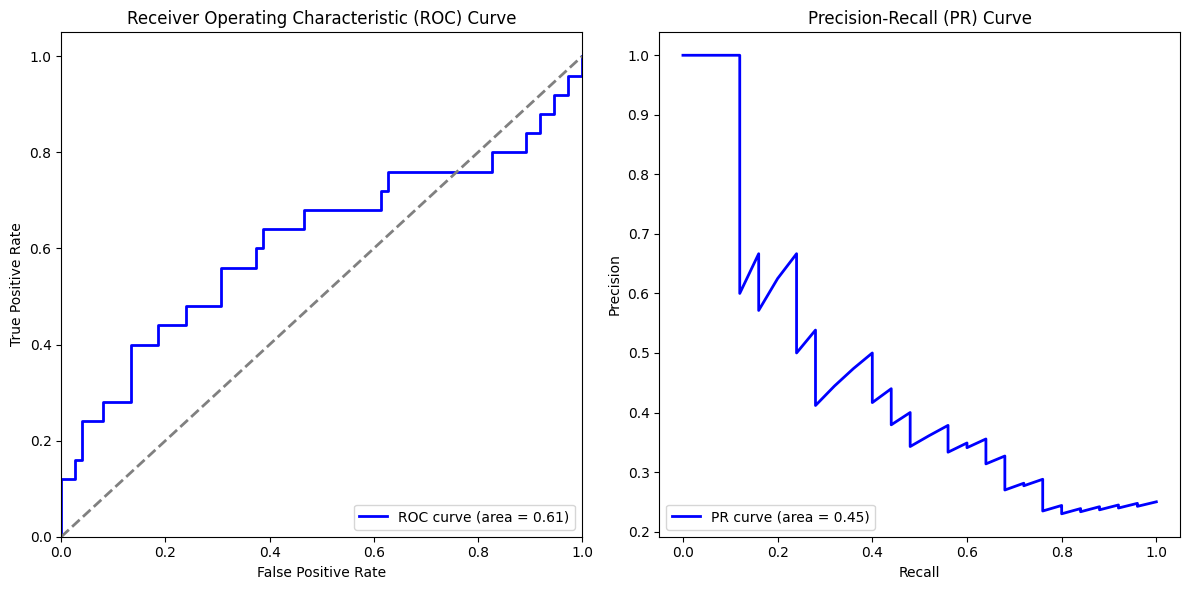

In [728]:
model = CatBoostClassifier(
                           **study_w_lemm.best_params,
                           iterations=1000,
                           verbose=100,
                           early_stopping_rounds=50,
                           random_seed=42,
                           cat_features=['disc_numr']
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test))

#y_pred = model.predict(test_pool)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.1).astype(int)

metrics, summary_models_features_catboost = evaluate_model_predictions(y_test, y_pred_proba, threshold=0.1)

Лучший порог: 0.30 с F1-score: 0.43
Evaluation Metrics:
Precision: 0.48484848484848486
Recall: 0.41025641025641024
F1-score: 0.4444444444444444
ROC AUC score: 0.7079470198675497
PR AUC score: 0.4689847323891832
Lift: 1.9866355866355867 (Max lift: 4.097435897435897 )



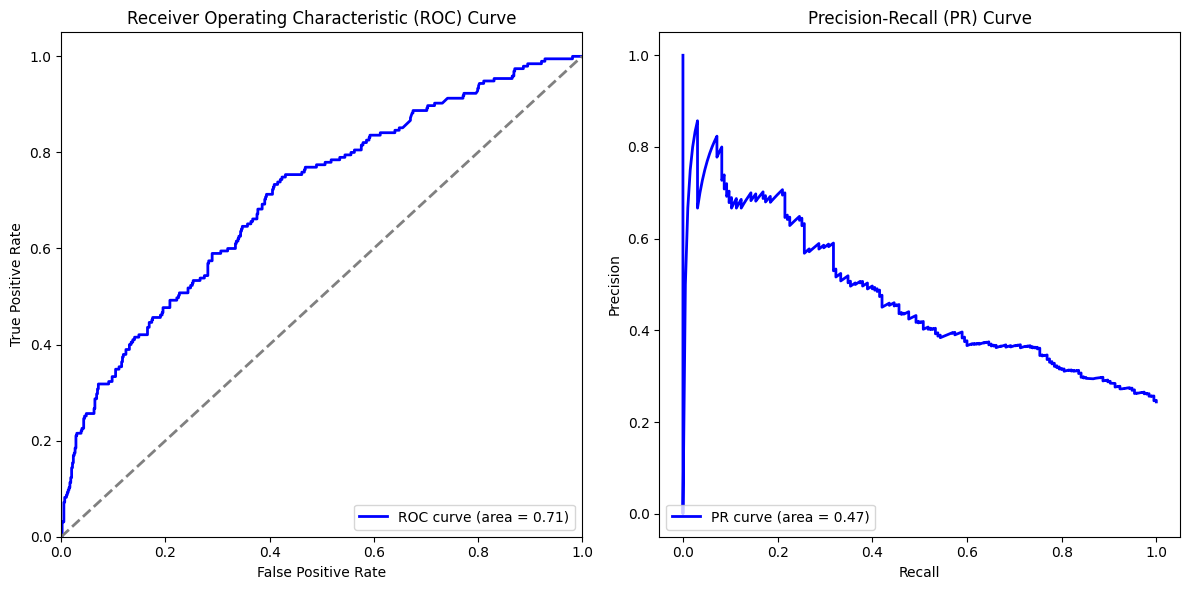

Evaluation Metrics:
Precision: 0.45454545454545453
Recall: 0.4
F1-score: 0.425531914893617
ROC AUC score: 0.6138666666666667
PR AUC score: 0.45277221376677584
Lift: 1.8181818181818183 (Max lift: 4.0 )



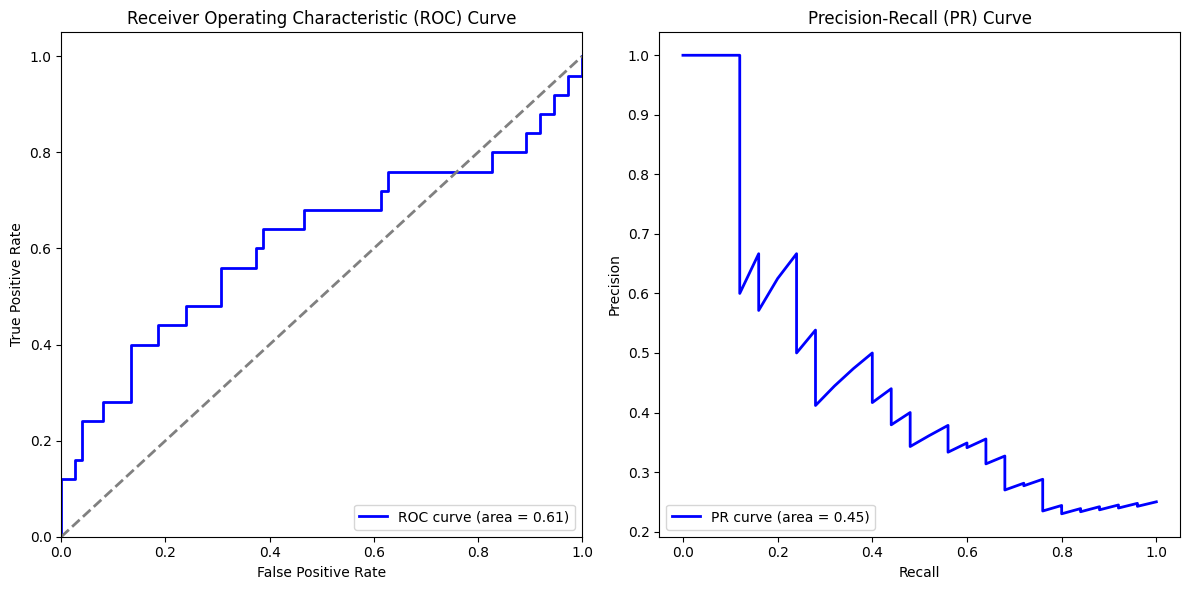

Evaluation Metrics:
Precision: 0.27586206896551724
Recall: 0.3333333333333333
F1-score: 0.3018867924528302
ROC AUC score: 0.5603070175438596
PR AUC score: 0.2706190674761756
Lift: 1.149425287356322 (Max lift: 4.166666666666667 )



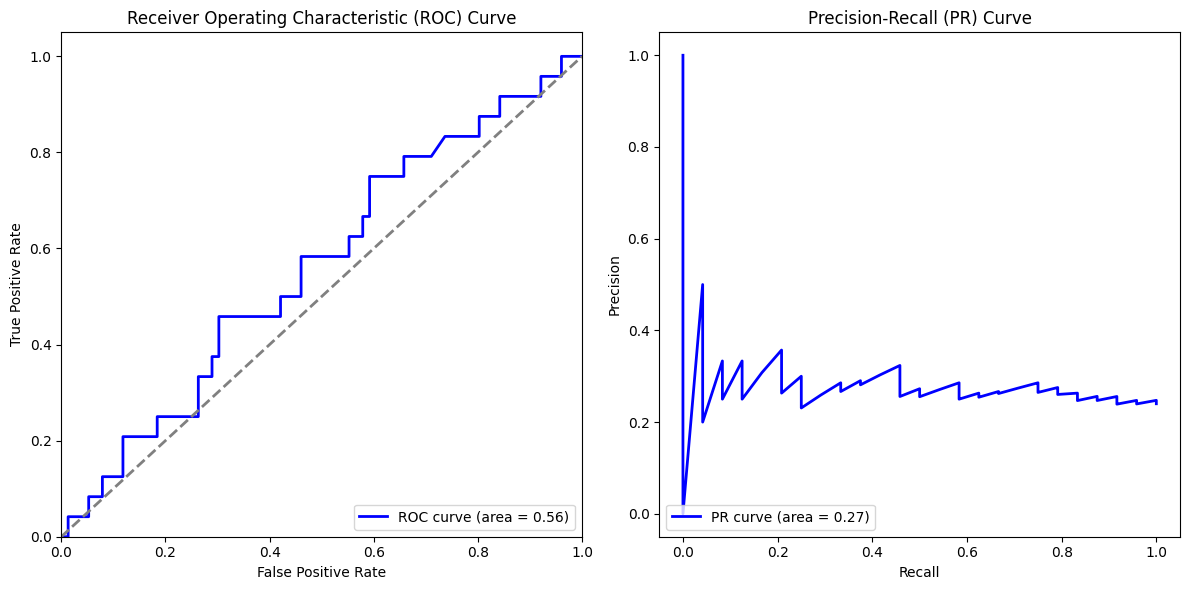

model_name precision    recall  f1_score   roc_auc  \
0    tfidf_catboost_optimal_th  0.352941  0.122449  0.181818  0.583322   
0               LaBSE_catboost      0.25  0.714286   0.37037  0.580078   
0         features_catboost_th      0.24       1.0  0.387097  0.632127   
0  features_w_lemm_catboost_th  0.275862  0.333333  0.301887  0.560307   

     pr_auc      lift  max_lift threshold  
0  0.277428  1.440576  4.081633       0.3  
0   0.32389  1.020408  4.081633       0.2  
0  0.294141       1.0  4.166667       0.1  
0  0.270619  1.149425  4.166667       0.3

In [729]:
thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    metrics, _ = evaluate_model_predictions(y_test, y_pred_proba, threshold=threshold, visual = False)
    if metrics['f1_score'] > best_f1:
        best_f1 = metrics['f1_score']
        best_threshold = threshold

print(f"Лучший порог: {best_threshold:.2f} с F1-score: {best_f1:.2f}")

#train
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
best_metrics, train_features_w_lemm_catboost_th = evaluate_model_predictions(y_train, y_train_pred_proba, threshold=best_threshold,
                                          save_metrics_df=train_features_catboost_th,
                                          model_name = "features_w_lemm_catboost_th")
#test
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
best_metrics, test_features_w_lemm_catboost_th = evaluate_model_predictions(y_test, y_test_pred_proba, threshold=best_threshold,
                                          save_metrics_df=test_features_catboost_th,
                                          model_name = "features_w_lemm_catboost_th")
#val
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
best_metrics, val_features_w_lemm_catboost_th = evaluate_model_predictions(y_val, y_val_pred_proba, threshold=best_threshold,
                                          save_metrics_df=val_features_catboost_th,
                                          model_name = "features_w_lemm_catboost_th")

val_features_w_lemm_catboost_th

In [730]:
feature_importances = model_features.get_feature_importance()
importance_df = pd.DataFrame({'feature': X_train_columns, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("Топ важных признаков:")
print(importance_df.head(20))

Топ важных признаков:
                   feature  importance
6            dialog_length   44.263124
2  first_discount_location   11.208498
4   word_ngrams_similarity   11.026675
3   last_discount_location   10.688539
5                disc_numr    9.784605
1        discount_mentions    8.971329
0             has_discount    4.057229


In [731]:
df_features.groupby(target_column).dialog_length.mean()

target_client
0    416.166887
1    379.770492
Name: dialog_length, dtype: float64

In [732]:
df_features.groupby(target_column).first_discount_location.mean(), \
df_features.groupby(target_column).last_discount_location.mean()

(target_client
 0    0.181772
 1    0.189302
 Name: first_discount_location, dtype: float64,
 target_client
 0    0.233521
 1    0.231476
 Name: last_discount_location, dtype: float64)

In [733]:
df_features.groupby(target_column).discount_mentions.mean()

target_client
0    0.757616
1    0.750000
Name: discount_mentions, dtype: float64

In [803]:
features = ['has_discount', 'discount_mentions',
    'first_discount_location', 'last_discount_location', 
    'word_ngrams_similarity', 'disc_numr', 'dialog_length']
X_train, X_test, y_train, y_test = train_test_split(df_features[features], df_features[target_column],
                                                    test_size=0.2, random_state=42, stratify=df_features[target_column])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                  test_size=0.5, random_state=42, stratify=y_test)


In [804]:
calibrated_clf = CalibratedClassifierCV(model_features, cv="prefit", method="sigmoid")
calibrated_clf.fit(X_train, y_train)

probs_val_platt = calibrated_clf.predict_proba(X_val)[:,1]

In [805]:
probs_val_platt.mean(), y_val.mean()

(0.2611201414197109, 0.24)

### Тест изменения числительного

In [806]:
test_df_new_pred = pd.DataFrame(zip(calibrated_clf.predict_proba(X_train)[:, 1], y_train), columns = ['proba', 'target'])
test_df_new_pred.groupby('target').proba.describe()

count      mean       std       min       25%       50%       75%  \
target                                                                      
0       604.0  0.217228  0.104605  0.010461  0.115340  0.226883  0.295057   
1       195.0  0.327185  0.194772  0.070965  0.212472  0.295057  0.327018   

             max  
target            
0       0.787567  
1       0.991382

Text(0.5, 1.0, 'Распределение вероятности по таргету')

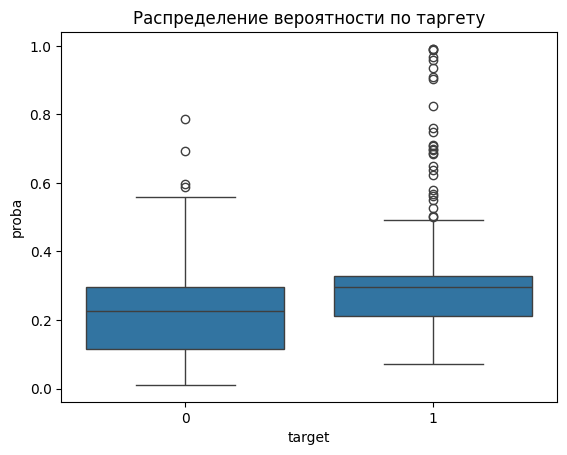

In [807]:
sns.boxplot(test_df_new_pred, x = 'target', y = 'proba')
plt.title('Распределение вероятности по таргету')

In [808]:
df_features.disc_numr.value_counts()[:10]

disc_numr
ноль          864
два            40
десять         26
четыре         22
три            15
пять            6
двадцать        6
пятнадцать      3
двенадцать      3
тридцать        2
Name: count, dtype: int64

In [809]:
def discounts_effect(start_disc, end_disc):
    exp_df = df_features.loc[df_features.disc_numr == start_disc].copy()
    #predict_proba_base = model_features.predict_proba(np.array(exp_df[features]))[:, 1]
    predict_proba_base = calibrated_clf.predict_proba(np.array(exp_df[features]))[:, 1]

    test_exp_df = exp_df.copy()
    test_exp_df['disc_numr'] = end_disc
    #predict_proba_new = model_features.predict_proba(np.array(test_exp_df[features]))[:, 1]
    predict_proba_new = calibrated_clf.predict_proba(np.array(test_exp_df[features]))[:, 1]

    diff = (predict_proba_new - predict_proba_base).mean()
    return predict_proba_base.mean(), diff, round(diff / predict_proba_base.mean(),2)

In [810]:
discounts_effect('два', 'четыре'), discounts_effect('четыре', 'два')

((0.28236765246047835, 0.03706233036773238, 0.13),
 (0.2778578024513811, -0.05265793903150951, -0.19))

In [811]:
discounts_effect('два', 'десять'), discounts_effect('десять', 'два')

((0.28236765246047835, 0.05540206210161325, 0.2),
 (0.16989704811871068, -0.01854171326109482, -0.11))

In [812]:
discounts_effect('ноль', 'два'), discounts_effect('два', 'ноль')

((0.24419552870987335, -0.08679541863891149, -0.36),
 (0.28236765246047835, 0.1000062433598548, 0.35))

Text(0.5, 1.0, 'Изменение вероятности при изменении числительного скидки')

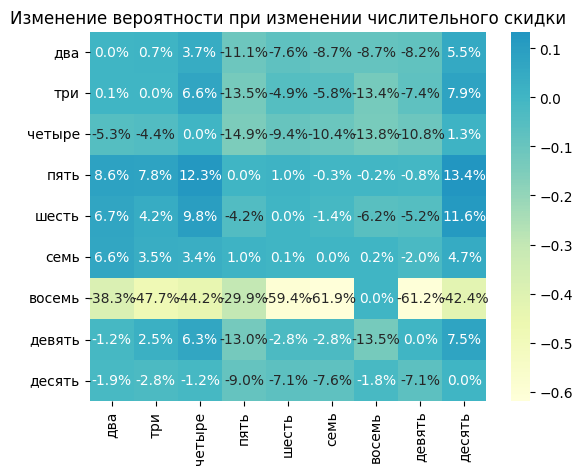

In [813]:
df_effect_disc = pd.DataFrame()
disc_list = ['два', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь', 'девять', 'десять']
for elem_base in disc_list:
    for elem_lift in disc_list:
        df_effect_disc.loc[elem_base, elem_lift] = discounts_effect(elem_base, elem_lift)[1]
sns.heatmap(df_effect_disc, annot=True, fmt=".1%", center = 0, cmap="YlGnBu")
plt.title('Изменение вероятности при изменении числительного скидки')

Text(0.5, 1.0, 'Изменение вероятности при изменении числительного скидки')

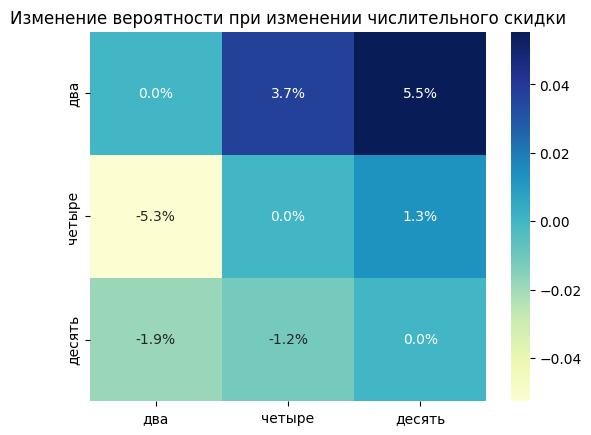

In [814]:
df_effect_disc = pd.DataFrame()
disc_list = ['два', 'четыре', 'десять']
for elem_base in disc_list:
    for elem_lift in disc_list:
        df_effect_disc.loc[elem_base, elem_lift] = discounts_effect(elem_base, elem_lift)[1]
sns.heatmap(df_effect_disc, annot=True, fmt=".1%", center = 0, cmap="YlGnBu")
plt.title('Изменение вероятности при изменении числительного скидки')

In [815]:
exp_df = df_features.loc[df_features.disc_numr == 'два'].copy()
predict_proba_base = calibrated_clf.predict_proba(np.array(exp_df[features]))[:, 1]

test_exp_df = exp_df.copy()
test_exp_df['disc_numr'] = 'ноль'
test_exp_df['first_discount_location'] = 0
test_exp_df['last_discount_location'] = 0
test_exp_df['discount_mentions'] = 0
test_exp_df['word_ngrams_similarity'] = 0
test_exp_df['has_discount'] = False

predict_proba_new = calibrated_clf.predict_proba(np.array(test_exp_df[features]))[:, 1]

diff = (predict_proba_new - predict_proba_base).mean()
predict_proba_base.mean(), diff, diff / predict_proba_base.mean()

(0.28236765246047835, -0.15595490223384195, -0.5523115019546023)

In [816]:
train_features_w_lemm_catboost_th

model_name precision    recall  f1_score   roc_auc  \
0    tfidf_catboost_optimal_th  0.638298  0.205479  0.310881   0.79821   
0               LaBSE_catboost  0.344498  0.986301  0.510638  0.915268   
0         features_catboost_th  0.244055       1.0  0.392354  0.650968   
0  features_w_lemm_catboost_th  0.484848  0.410256  0.444444  0.707947   

     pr_auc      lift  max_lift threshold  
0  0.562468   2.61877   4.10274       0.3  
0  0.833808  1.413384   4.10274       0.2  
0  0.405208       1.0  4.097436       0.1  
0  0.468985  1.986636  4.097436       0.3

In [817]:
test_features_w_lemm_catboost_th

model_name precision    recall  f1_score   roc_auc  \
0    tfidf_catboost_optimal_th  0.352941  0.122449  0.181818  0.583322   
0               LaBSE_catboost  0.255952  0.877551  0.396313  0.549128   
0         features_catboost_th      0.25       1.0       0.4  0.517333   
0  features_w_lemm_catboost_th  0.454545       0.4  0.425532  0.613867   

     pr_auc      lift  max_lift threshold  
0  0.277428  1.440576  4.081633       0.3  
0  0.255413  1.044704  4.081633       0.2  
0  0.301396       1.0       4.0       0.1  
0  0.452772  1.818182       4.0       0.3

In [818]:
val_features_w_lemm_catboost_th

model_name precision    recall  f1_score   roc_auc  \
0    tfidf_catboost_optimal_th  0.352941  0.122449  0.181818  0.583322   
0               LaBSE_catboost      0.25  0.714286   0.37037  0.580078   
0         features_catboost_th      0.24       1.0  0.387097  0.632127   
0  features_w_lemm_catboost_th  0.275862  0.333333  0.301887  0.560307   

     pr_auc      lift  max_lift threshold  
0  0.277428  1.440576  4.081633       0.3  
0   0.32389  1.020408  4.081633       0.2  
0  0.294141       1.0  4.166667       0.1  
0  0.270619  1.149425  4.166667       0.3